<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu3/Minggu3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.6 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from IPython.display import display, Markdown
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import copy

In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For all GPUs
    torch.cuda.manual_seed_all(seed) # For all GPUs

    # Ensures that CUDA operations are deterministic even if they might be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed} for reproducibility.")

# Call the function to set the seed
set_seed(42)

Random seed set to 42 for reproducibility.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df_pdb = pd.read_csv('/content/drive/MyDrive/Bioinformatika/PDB1063-186.csv')
df_uni = pd.read_csv('/content/drive/MyDrive/Bioinformatika/UniSwiss.csv')

def show_dataset_info(df, dataset_name, stage="Before Cleaning"):
    """Menampilkan informasi dataset"""
    if df is None or df.empty:
        print(f"{stage} - Dataset {dataset_name} is empty")
        return

    total_rows = len(df)
    train_count = len(df[df['set'] == 'train'])
    test_count = len(df[df['set'] == 'test'])

    train_label_0 = len(df[(df['set'] == 'train') & (df['label'] == 0)])
    train_label_1 = len(df[(df['set'] == 'train') & (df['label'] == 1)])
    test_label_0 = len(df[(df['set'] == 'test') & (df['label'] == 0)])
    test_label_1 = len(df[(df['set'] == 'test') & (df['label'] == 1)])

    print(f"\n{stage} - {dataset_name} Dataset:")
    print(f"Total rows: {total_rows}")
    print(f"Train set: {train_count} rows")
    print(f"  - Label 0: {train_label_0} rows")
    print(f"  - Label 1: {train_label_1} rows")
    print(f"Test set: {test_count} rows")
    print(f"  - Label 0: {test_label_0} rows")
    print(f"  - Label 1: {test_label_1} rows")

def cleaning_dataset(df, dataset_name=None):
    """Membersihkan dataset dengan menampilkan info sebelum dan sesudah"""
    if df is None or df.empty:
        print(f'Dataset {dataset_name} is empty. No clean required')
        return df

    # Tampilkan informasi sebelum cleaning
    show_dataset_info(df, dataset_name, "Before Cleaning")

    # Simpan info duplikat
    duplicates_count = df.duplicated(subset='sequence').sum()
    print(f"Duplicates found: {duplicates_count}")

    # Cleaning
    df_clean = df.drop_duplicates(subset='sequence')

    # Tampilkan informasi setelah cleaning
    show_dataset_info(df_clean, dataset_name, "After Cleaning")
    print(f"Rows removed: {len(df) - len(df_clean)}")

    return df_clean

# Proses cleaning dengan menampilkan info
print("=" * 50)
print("DATASET CLEANING PROCESS")
print("=" * 50)

df_pdb_clean = cleaning_dataset(df_pdb, "PDB")
print("\n" + "=" * 50)
df_uni_clean = cleaning_dataset(df_uni, "UniSwiss")
print("\n" + "=" * 50)

# Summary akhir
print("\nFINAL SUMMARY:")
print(f"PDB dataset - Final count: {len(df_pdb_clean)}")
print(f"UniSwiss dataset - Final count: {len(df_uni_clean)}")
print(f"Combined total: {len(df_pdb_clean) + len(df_uni_clean)}")

DATASET CLEANING PROCESS

Before Cleaning - PDB Dataset:
Total rows: 1249
Train set: 1063 rows
  - Label 0: 545 rows
  - Label 1: 518 rows
Test set: 186 rows
  - Label 0: 93 rows
  - Label 1: 93 rows
Duplicates found: 78

After Cleaning - PDB Dataset:
Total rows: 1171
Train set: 1060 rows
  - Label 0: 545 rows
  - Label 1: 515 rows
Test set: 111 rows
  - Label 0: 93 rows
  - Label 1: 18 rows
Rows removed: 78


Before Cleaning - UniSwiss Dataset:
Total rows: 9762
Train set: 9000 rows
  - Label 0: 4500 rows
  - Label 1: 4500 rows
Test set: 762 rows
  - Label 0: 381 rows
  - Label 1: 381 rows
Duplicates found: 66

After Cleaning - UniSwiss Dataset:
Total rows: 9696
Train set: 8940 rows
  - Label 0: 4498 rows
  - Label 1: 4442 rows
Test set: 756 rows
  - Label 0: 381 rows
  - Label 1: 375 rows
Rows removed: 66


FINAL SUMMARY:
PDB dataset - Final count: 1171
UniSwiss dataset - Final count: 9696
Combined total: 10867


#Load Checkpoints
Load embedding process for Deep learning and Machine learning (yg split pertama, hapus tes set)

In [ ]:
# Deep learning
x_pdb_train_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/PDB/x_pdb_train.pt").numpy()
y_pdb_train = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/PDB/y_pdb_train.npy")

x_pdb_test_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/PDB/x_pdb_test.pt").numpy()
y_pdb_test = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/PDB/y_pdb_test.npy")

x_uni_train_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/UNI/x_uni_train.pt").numpy()
y_uni_train = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/UNI/y_uni_train.npy")

x_uni_test_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/UNI/x_uni_test.pt").numpy()
y_uni_test = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed/DL/UNI/y_uni_test.npy")

In [ ]:
#split train-val dengan rasio 8:2
x_train_pdb, x_val_pdb, y_train_pdb, y_val_pdb = train_test_split(
    x_pdb_train_emb,
    y_pdb_train,
    test_size=0.1,      # 10% untuk validation
    random_state=42,    # supaya hasil split tetap sama tiap kali
    stratify=y_pdb_train  # penting! biar proporsi kelas tetap seimbang
)

x_train_uni, x_val_uni, y_train_uni, y_val_uni = train_test_split(
    x_uni_train_emb,
    y_uni_train,
    test_size=0.1,      # 10% untuk validation
    random_state=42,    # supaya hasil split tetap sama tiap kali
    stratify=y_uni_train  # penting! biar proporsi kelas tetap seimbang
)

#Load Checkpoints 2
Load embedding process for Deep learning and Machine learning (yg split kedua, hapus train set)

In [ ]:
# Deep learning
x_pdb_train_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/x_pdb_train.pt").numpy()
y_pdb_train = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/y_pdb_train.npy")

x_pdb_test_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/x_pdb_test.pt").numpy()
y_pdb_test = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/y_pdb_test.npy")

x_uni_train_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/x_uni_train.pt").numpy()
y_uni_train = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/y_uni_train.npy")

x_uni_test_emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/x_uni_test.pt").numpy()
y_uni_test = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/y_uni_test.npy")

In [ ]:
#split train-val dengan rasio 8:2
x_train_pdb, x_val_pdb, y_train_pdb, y_val_pdb = train_test_split(
    x_pdb_train_emb,
    y_pdb_train,
    test_size=0.1,      # 10% untuk validation
    random_state=42,    # supaya hasil split tetap sama tiap kali
    stratify=y_pdb_train  # penting! biar proporsi kelas tetap seimbang
)

x_train_uni, x_val_uni, y_train_uni, y_val_uni = train_test_split(
    x_uni_train_emb,
    y_uni_train,
    test_size=0.1,      # 10% untuk validation
    random_state=42,    # supaya hasil split tetap sama tiap kali
    stratify=y_uni_train  # penting! biar proporsi kelas tetap seimbang
)

#Define Models
Define model with set hyperparamater/model architecture
- udh tambahin model MLP yg lebih kompleks


In [ ]:
class ComplexMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.2, n_classes=2):
        super(ComplexMLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 4, n_classes)
        )

    def forward(self, x):
        return self.model(x)

class ComplexMLP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3, n_classes=2):
        super(ComplexMLP_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.BatchNorm1d(hidden_dim // 8),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 8, n_classes)
        )

    def forward(self, x):
        return self.model(x)

class ComplexMLP_v3(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.4, n_classes=2):
        super(ComplexMLP_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 4, n_classes)
        )

    def forward(self, x):
        return self.model(x)

class CNNModel(nn.Module):
    def __init__(self, input_dim=1280, n_filters=32, dropout=0.3, n_classes=2):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv1d(1, n_filters, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(n_filters)

        # Block 2
        self.conv2 = nn.Conv1d(n_filters, n_filters*2, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(n_filters*2)

        # Block 3
        self.conv3 = nn.Conv1d(n_filters*2, n_filters*4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(n_filters*4)

        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # After 3x pooling:
        # 1280 → 640 → 320 → 160
        flattened = (input_dim // 8) * (n_filters * 4)

        self.fc1 = nn.Linear(flattened, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))   # (32 filters)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))   # (64 filters)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))   # (128 filters)
        x = x.view(x.size(0), -1)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x



class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, n_classes):
        super(BiLSTMModel, self).__init__()
        # ARCHITECTURAL CHANGE POINT: Modify LSTM layers here
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # ARCHITECTURAL CHANGE POINT: Modify fully connected layers here
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x is expected to be (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x) # We only need lstm_out for the next layers
        # lstm_out is (batch_size, seq_len, hidden_dim * 2)
        # Since seq_len will be 1 for averaged embeddings, we squeeze it.
        x = lstm_out.squeeze(1) # Resulting in (batch_size, hidden_dim * 2)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        predictions = self.softmax(x)
        # Return both predictions and lstm_out (or any dummy) for compatibility with train_model
        return predictions, lstm_out

# Define the models
def define_model(model_type=None, input_dim=1280, hidden_dim=64, dropout=0.5, n_classes=2, embedding_dim=128, kernel_size=3, n_filters=64, nhead=4):
    if model_type == 'BiLSTM':
        # ARCHITECTURAL CHANGE POINT: Modify BiLSTM specific layers or add more here
        model = BiLSTMModel(input_dim, hidden_dim, dropout, n_classes)

    elif model_type == 'CNN':
        # ARCHITECTURAL CHANGE POINT: Modify Conv1d, Pooling, or Linear layers, add more blocks, etc.
        model = CNNModel(input_dim, n_filters, dropout, n_classes)

    elif model_type == 'Transformer':
        # ARCHITECTURAL CHANGE POINT: Modify TransformerEncoderLayer parameters, number of layers, add pre/post processing
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim, batch_first=True)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6) # num_layers can be changed

        model = nn.Sequential(
            transformer_encoder,
            nn.Flatten(start_dim=1),
            nn.Linear(input_dim, n_classes),
            nn.Softmax(dim=1)
        )

    elif model_type == 'MLP':
        # ARCHITECTURAL CHANGE POINT: Modify number of hidden layers, activation functions, dropout positions
        model = ComplexMLP_v2(input_dim, hidden_dim, dropout, n_classes)

    else:
        raise ValueError("Model type not recognized. Choose from ['BiLSTM', 'CNN', 'Transformer', 'MLP']")

    return model

#Train Models
Make sure select models you want to train by changing the model_type <p>List:
['BiLSTM', 'CNN', 'Transformer']
>trained_pdb_model = train_model(model_type='BiLSTM', train_data=x_pdb_train_emb, train_labels=y_pdb_train, test_data=x_pdb_test_emb, test_labels=y_pdb_test, epochs=50) <p>
trained_uni_model = train_model(model_type='BiLSTM', train_data=x_uni_train_emb, train_labels=y_uni_train, test_data=x_uni_test_emb, test_labels=y_uni_test, epochs=50)

Note: Do not run this code, unless you want train ML Model
>trained_pdb_model = train_model(model_type='MLP', train_data=x_pdb_train_sel, train_labels=y_pdb_train, test_data=x_pdb_train_sel, test_labels=y_pdb_test, epochs=50)
trained_uni_model = train_model(model_type='MLP', train_data=x_uni_train_sel, train_labels=y_uni_train, test_data=x_uni_train_sel, test_labels=y_uni_test, epochs=50)

- udh tambahin weight_decay


In [ ]:
def train_model(model_type= None, train_data=None, train_labels=None, val_data=None, val_labels=None, batch_size=32, epochs=10, learning_rate=0.001,weight_decay=1e-4, hidden_dim=64, dropout=0.5, n_filters=64, kernel_size=3, nhead=4):
    # Determine input_dim and n_classes dynamically from data
    input_dim = train_data.shape[1]
    n_classes = len(np.unique(train_labels))

    # Define the model, passing dynamic input_dim and n_classes, and other hyperparameters
    model = define_model(model_type=model_type, input_dim=input_dim, n_classes=n_classes,
                         hidden_dim=hidden_dim, dropout=dropout, n_filters=n_filters,
                         kernel_size=kernel_size, nhead=nhead)

    # Choose optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert data to tensors and move to device
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    val_data_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)

    print(f"DEBUG 1: Initial train_labels_tensor size: {train_labels_tensor.size(0)}")

    # Reshape data for BiLSTM, CNN, and Transformer input: add a sequence length dimension (N, D) -> (N, 1, D)
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        train_data_tensor = train_data_tensor.unsqueeze(1)
        val_data_tensor = val_data_tensor.unsqueeze(1)

    # Lists to store training history
    train_losses = []
    val_losses = [] # Added to store validation losses
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        if model_type == 'BiLSTM':
            outputs, _ = model(train_data_tensor)
        else:
            outputs = model(train_data_tensor)

        loss = criterion(outputs, train_labels_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluate on test set after each epoch
        model.eval()
        with torch.no_grad():
            if model_type == 'BiLSTM':
                test_outputs, _ = model(val_data_tensor)
            else:
                test_outputs = model(val_data_tensor)

            val_loss = criterion(test_outputs, val_labels_tensor) # Calculate validation loss
            val_losses.append(val_loss.item()) # Append validation loss

            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == val_labels_tensor).sum().item() / val_labels_tensor.size(0)
            test_accuracies.append(accuracy)

        # Print loss and accuracy
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Accuracy: {accuracy * 100:.2f}%")

    # Final test accuracy print
    print(f"Final Val Accuracy: {test_accuracies[-1] * 100:.2f}%")
    return model, train_losses, val_losses, test_accuracies # Modified return statement

# perubahan cuma pke weighted CE loss
def train_model_new(model_type= None, train_data=None, train_labels=None, val_data=None, val_labels=None, batch_size=32, epochs=10, learning_rate=0.001,weight_decay=1e-4, hidden_dim=64, dropout=0.5, n_filters=64, kernel_size=3, nhead=4):
    # Determine input_dim and n_classes dynamically from data
    input_dim = train_data.shape[1]
    n_classes = len(np.unique(train_labels))

    # Define the model, passing dynamic input_dim and n_classes, and other hyperparameters
    model = define_model(model_type=model_type, input_dim=input_dim, n_classes=n_classes,
                         hidden_dim=hidden_dim, dropout=dropout, n_filters=n_filters,
                         kernel_size=kernel_size, nhead=nhead)

    # Choose optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert data to tensors and move to device
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
    val_data_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)

    print(f"DEBUG 1: Initial train_labels_tensor size: {train_labels_tensor.size(0)}")

    # --- MODIFIKASI DIMULAI DI SINI ---

    # 1. Hitung Bobot Kelas Berdasarkan Data TRAINING
    # Menghitung frekuensi kelas di data pelatihan (train_labels)
    class_counts = np.bincount(train_labels)
    n_classes_actual = len(class_counts)

    if n_classes_actual != 2:
        print(f"⚠️ Peringatan: Ditemukan {n_classes_actual} kelas, diharapkan 2.")

    total_samples = class_counts.sum()

    # Menghitung bobot invers berdasarkan frekuensi (W_c = Total / N_c)
    # Gunakan bobot terbalik untuk menghukum kesalahan pada kelas minoritas (Kelas 1) lebih berat.
    class_weights = total_samples / class_counts

    # Konversi bobot ke Tensor PyTorch
    weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    print(f"✅ Bobot Kelas (0, 1): {class_weights}")

    # 2. Definisikan Loss Function dengan Bobot
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # --- MODIFIKASI BERAKHIR DI SINI ---

    # Reshape data for BiLSTM, CNN, and Transformer input: add a sequence length dimension (N, D) -> (N, 1, D)
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        train_data_tensor = train_data_tensor.unsqueeze(1)
        val_data_tensor = val_data_tensor.unsqueeze(1)

    # Lists to store training history
    train_losses = []
    val_losses = [] # Added to store validation losses
    test_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        if model_type == 'BiLSTM':
            outputs, _ = model(train_data_tensor)
        else:
            outputs = model(train_data_tensor)

        loss = criterion(outputs, train_labels_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluate on test set after each epoch
        model.eval()
        with torch.no_grad():
            if model_type == 'BiLSTM':
                test_outputs, _ = model(val_data_tensor)
            else:
                test_outputs = model(val_data_tensor)

            val_loss = criterion(test_outputs, val_labels_tensor) # Calculate validation loss
            val_losses.append(val_loss.item()) # Append validation loss

            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == val_labels_tensor).sum().item() / val_labels_tensor.size(0)
            test_accuracies.append(accuracy)

        # Print loss and accuracy
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Accuracy: {accuracy * 100:.2f}%")

    # Final test accuracy print
    print(f"Final Val Accuracy: {test_accuracies[-1] * 100:.2f}%")
    return model, train_losses, val_losses, test_accuracies # Modified return statement

#Evaluate and Visualize
Evaluate model
>

Visualize histogram
>

Visualize Confusion Matrix
>

In [ ]:
def evaluate_model(model, X_test, y_test, model_type, dataset_name):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Reshape data untuk model yang butuh channel
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    with torch.no_grad():
        if model_type == 'BiLSTM':
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)

        # Probabilitas dan Prediksi
        y_pred_probs = outputs.softmax(dim=1).cpu().numpy()
        _, preds = torch.max(outputs, 1)
        y_preds = preds.cpu().numpy()

    # ============================
    #     METRICS UTAMA
    # ============================
    acc = accuracy_score(y_test, y_preds)
    precision_macro = precision_score(y_test, y_preds, average='macro')
    recall_macro = recall_score(y_test, y_preds, average='macro')
    f1_macro = f1_score(y_test, y_preds, average='macro')
    f1_weighted = f1_score(y_test, y_preds, average='weighted')

    # MCC
    mcc = matthews_corrcoef(y_test, y_preds)

    # ROC AUC (binary)
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])

    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    specificity = tn / (tn + fp)

    # ============================
    #     Classification Report
    # ============================
    class_report = classification_report(
        y_test,
        y_preds,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3
    )

    # Print evaluasi ringkas
    print(f"\nEvaluation for {model_type} on {dataset_name} dataset:")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision(M):  {precision_macro:.3f}")
    print(f"Recall(M):     {recall_macro:.3f}")
    print(f"F1 Macro:      {f1_macro:.3f}")
    print(f"F1 Weighted:   {f1_weighted:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print(f"Sensitivity:   {recall_macro:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"ROC_AUC:       {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # Return lengkap
    metrics_dict = {
        "Model": model_type,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "Specificity": specificity,
        "MCC": mcc,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }

    return metrics_dict, y_preds, y_pred_probs

#cuma ganti threshold probabilitas jdi 0.85
def evaluate_model_new(model, X_test, y_test, model_type, dataset_name):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    OPTIMAL_THRESHOLD = 0.85
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Reshape data untuk model yang butuh channel
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    with torch.no_grad():
        if model_type == 'BiLSTM':
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)

        # Probabilitas dan Prediksi
        probabilities = outputs.softmax(dim=1)
        y_pred_probs = probabilities.cpu().numpy()

        # --- IMPLEMENTASI THRESHOLD 0.50 ---
        # Ambil probabilitas kelas positif (Binding, indeks 1)
        prob_class_1 = probabilities[:, 1]

        # Prediksi = 1 jika probabilitas kelas 1 > OPTIMAL_THRESHOLD, sebaliknya 0
        preds = (prob_class_1 > OPTIMAL_THRESHOLD).long()
        # -----------------------------------

        y_preds = preds.cpu().numpy()

    # ============================
    #     METRICS UTAMA
    # ============================
    acc = accuracy_score(y_test, y_preds)
    precision_macro = precision_score(y_test, y_preds, average='macro')
    recall_macro = recall_score(y_test, y_preds, average='macro')
    f1_macro = f1_score(y_test, y_preds, average='macro')
    f1_weighted = f1_score(y_test, y_preds, average='weighted')

    # MCC
    mcc = matthews_corrcoef(y_test, y_preds)

    # ROC AUC (binary)
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])

    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    specificity = tn / (tn + fp)

    # ============================
    #     Classification Report
    # ============================
    class_report = classification_report(
        y_test,
        y_preds,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3
    )

    # Print evaluasi ringkas
    print(f"\nEvaluation for {model_type} on {dataset_name} dataset:")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision(M):  {precision_macro:.3f}")
    print(f"Recall(M):     {recall_macro:.3f}")
    print(f"F1 Macro:      {f1_macro:.3f}")
    print(f"F1 Weighted:   {f1_weighted:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print(f"Sensitivity:   {recall_macro:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"ROC_AUC:       {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # Return lengkap
    metrics_dict = {
        "Model": model_type,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "Specificity": specificity,
        "MCC": mcc,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }

    return metrics_dict, y_preds, y_pred_probs



#cuma ganti threshold probabilitas jdi 0.8073 pke asymetric
def evaluate_model_new2(model, X_test, y_test, model_type, dataset_name, T0=0.5, T1=0.5):
    """
    Melakukan evaluasi model menggunakan ambang batas asimetris T0 (Kelas 0) dan T1 (Kelas 1).

    Parameters:
    T0 (float): Ambang batas keyakinan untuk memprediksi Kelas 0 (Non-binding).
    T1 (float): Ambang batas keyakinan untuk memprediksi Kelas 1 (Binding).

    Catatan: Jika T0=0.5 dan T1=0.5, fungsi akan kembali ke prediksi standar (T=0.5).
    """
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Kita tidak lagi menggunakan OPTIMAL_THRESHOLD tunggal
    # OPTIMAL_THRESHOLD = 0.8073

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Reshape data untuk model yang butuh channel
    if model_type in ['BiLSTM', 'CNN', 'Transformer']:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    with torch.no_grad():
        if model_type == 'BiLSTM':
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)

        # Probabilitas dan Prediksi
        probabilities = outputs.softmax(dim=1)
        y_pred_probs = probabilities.cpu().numpy()

        # Ambil probabilitas kelas positif (Binding, indeks 1) dan Kelas 0 (indeks 0)
        prob_class_1 = probabilities[:, 1].cpu().numpy()
        prob_class_0 = probabilities[:, 0].cpu().numpy()

        # --- IMPLEMENTASI AMBANG BATAS ASIMETRIS (T0 dan T1) ---
        # Inisialisasi prediksi sebagai array kosong (default 0 / Non-binding)
        y_preds = np.zeros_like(y_test, dtype=int)

        # Logika 1: Prediksi Kelas 1 (Binding)
        y_preds[prob_class_1 >= T1] = 1

        # Logika 2: Prediksi Kelas 0 (Non-binding)
        # Ini menimpa Logika 1, memastikan bahwa jika P(0) sangat tinggi, tetap diprediksi 0.
        y_preds[prob_class_0 >= T0] = 0
        # --------------------------------------------------------

    # ============================
    #     METRICS UTAMA
    # ============================
    acc = accuracy_score(y_test, y_preds)
    precision_macro = precision_score(y_test, y_preds, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_preds, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_preds, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_preds, average='weighted', zero_division=0)

    # MCC
    mcc = matthews_corrcoef(y_test, y_preds)

    # ROC AUC (binary) - menggunakan y_pred_probs karena ROC AUC tidak bergantung pada threshold
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])

    # Confusion Matrix dan Specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    specificity = tn / (tn + fp)

    # ============================
    #     Classification Report
    # ============================
    class_report = classification_report(
        y_test,
        y_preds,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3,
        zero_division=0
    )

    # Print evaluasi ringkas
    print(f"\nEvaluation for {model_type} on {dataset_name} dataset (T0={T0:.4f}, T1={T1:.4f}):")
    print(f"Accuracy:        {acc:.3f}")
    print(f"Precision(M):    {precision_macro:.3f}")
    print(f"Recall(M):       {recall_macro:.3f}")
    print(f"F1 Macro:        {f1_macro:.3f}")
    print(f"F1 Weighted:     {f1_weighted:.3f}")
    print(f"MCC:             {mcc:.3f}")
    print(f"Sensitivity:     {recall_macro:.3f}") # Sensitivity = Recall Macro
    print(f"Specificity:     {specificity:.3f}")
    print(f"ROC_AUC:         {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # Return lengkap
    metrics_dict = {
        "Model": model_type,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "Specificity": specificity,
        "MCC": mcc,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }

    return metrics_dict, y_preds, y_pred_probs

In [ ]:
# Function to visualize the confusion matrix and ROC curve
def visualize_metrics(y_true_pdb, y_pred_pdb, y_prob_pdb, y_true_uni, y_pred_uni, y_prob_uni, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true_pdb, y_pred_pdb, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true_uni, y_pred_uni, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_true_pdb, y_prob_pdb[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true_uni, y_prob_uni[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Try 1 (0.722/0.907)
pke yan kelas ComplexMLP


In [ ]:
set_seed(42)

print("Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...")

trained_pdb_model, pdb_train_losses, pdb_val_losses, pdb_val_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_pdb,
    train_labels=y_train_pdb,
    val_data=x_pdb_val,
    val_labels=y_pdb_val,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=256, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

trained_uni_model, uni_train_losses, uni_val_losses, uni_test_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_uni,
    train_labels=y_train_uni,
    val_data=x_val_uni,
    val_labels=y_val_uni,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=128, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)



Random seed set to 42 for reproducibility.
Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...
DEBUG 1: Initial train_labels_tensor size: 954
Epoch [10/50], Loss: 0.3795, Val Accuracy: 49.06%
Epoch [20/50], Loss: 0.2477, Val Accuracy: 79.25%
Epoch [30/50], Loss: 0.1602, Val Accuracy: 85.85%
Epoch [40/50], Loss: 0.1037, Val Accuracy: 86.79%
Epoch [50/50], Loss: 0.0663, Val Accuracy: 87.74%
Final Val Accuracy: 87.74%
DEBUG 1: Initial train_labels_tensor size: 8046
Epoch [10/50], Loss: 0.4519, Val Accuracy: 83.00%
Epoch [20/50], Loss: 0.3463, Val Accuracy: 80.20%
Epoch [30/50], Loss: 0.2904, Val Accuracy: 85.68%
Epoch [40/50], Loss: 0.2518, Val Accuracy: 88.59%
Epoch [50/50], Loss: 0.2238, Val Accuracy: 90.49%
Final Val Accuracy: 90.49%



Evaluation for MLP on PDB dataset:
Accuracy:      0.793
Precision(M):  0.703
Recall(M):     0.832
F1 Macro:      0.722
F1 Weighted:   0.817
MCC:           0.518
Sensitivity:   0.832
Specificity:   0.774
ROC_AUC:       0.928

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.973     0.774     0.862        93
    Binding (1)      0.432     0.889     0.582        18

       accuracy                          0.793       111
      macro avg      0.703     0.832     0.722       111
   weighted avg      0.885     0.793     0.817       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.907
Precision(M):  0.908
Recall(M):     0.908
F1 Macro:      0.907
F1 Weighted:   0.907
MCC:           0.815
Sensitivity:   0.908
Specificity:   0.892
ROC_AUC:       0.964

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.921     0.892     0.907       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.792793         0.702703      0.831541  0.722047   
1   MLP  UniSwiss  0.907407         0.907733      0.907528  0.907402   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.816796     0.774194  0.518476  0.927718   
1     0.907396     0.892388  0.815261  0.964255   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

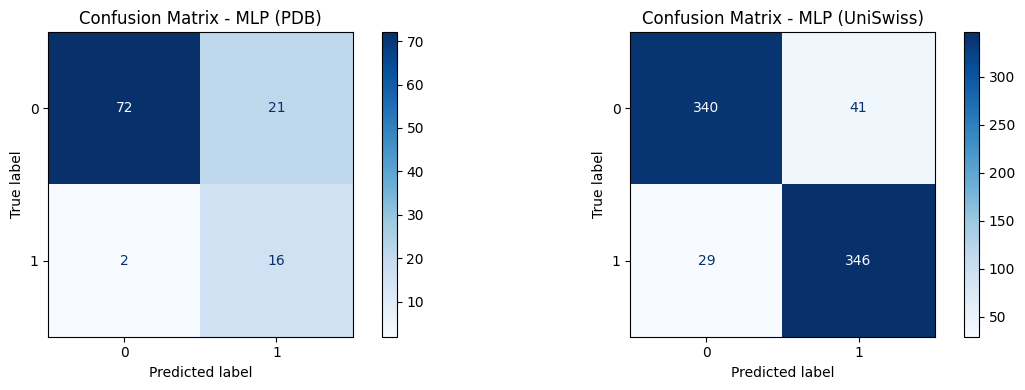

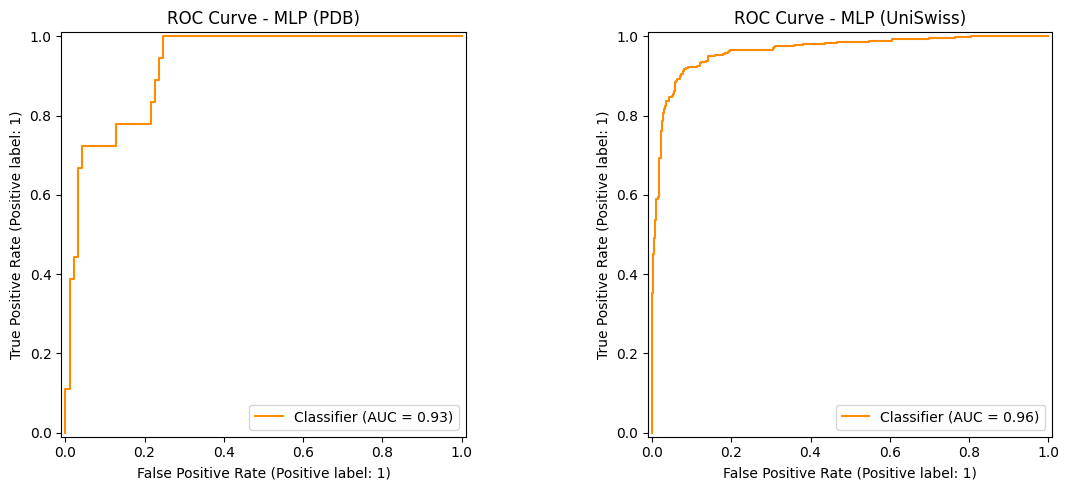

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

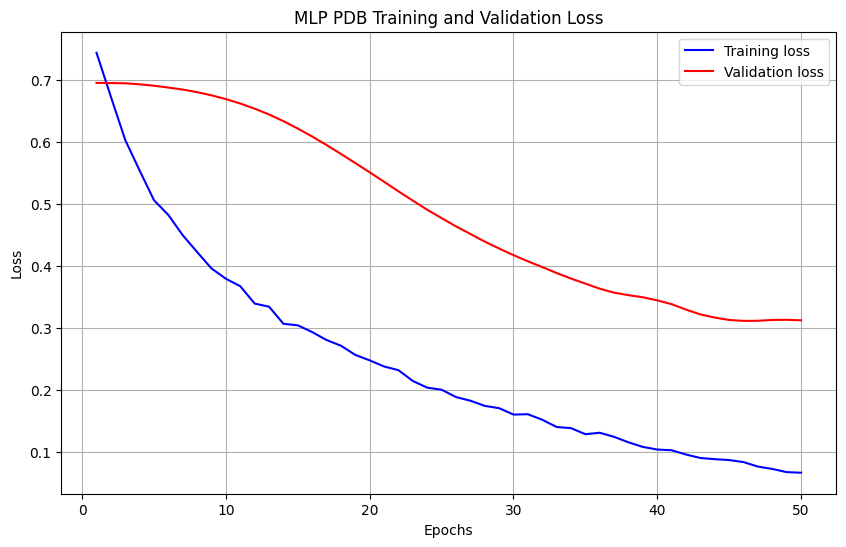

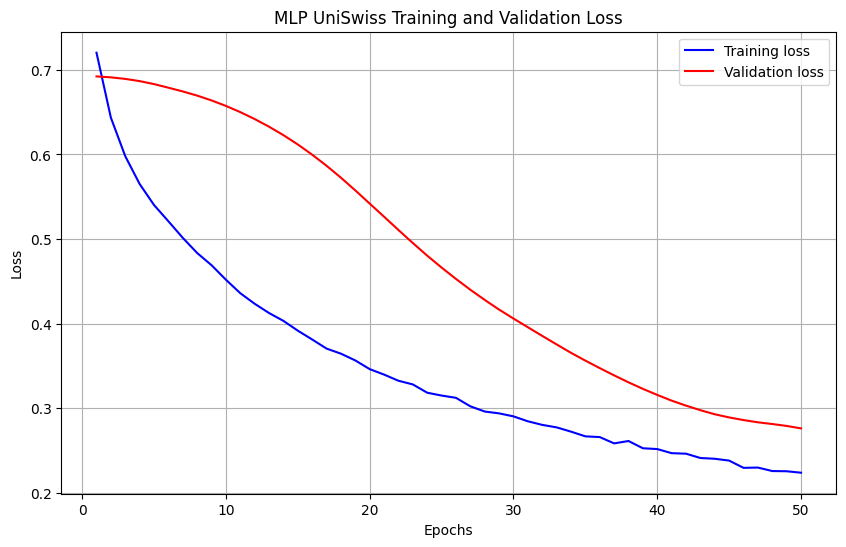

In [ ]:
plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

# Try 2 (0.734/0.903)
pke yan kelas ComplexMLP_v2





In [ ]:
set_seed(42)

print("Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...")

mlp_pdb_model, pdb_train_losses, pdb_val_losses, pdb_val_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_pdb,
    train_labels=y_train_pdb,
    val_data=x_pdb_val,
    val_labels=y_pdb_val,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=256, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

mlp_uni_model, uni_train_losses, uni_val_losses, uni_test_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_uni,
    train_labels=y_train_uni,
    val_data=x_val_uni,
    val_labels=y_val_uni,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=128, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

# Simpan Model
pdb_save_path = 'mlp_pdb_model.pth'
torch.save(mlp_pdb_model.state_dict(), pdb_save_path)
print(f"Model PDB telah tersimpan di: {pdb_save_path}")

uni_save_path = 'mlp_uni_model.pth'
torch.save(mlp_uni_model.state_dict(), uni_save_path)
print(f"Model UniSwiss telah tersimpan di: {uni_save_path}")

Random seed set to 42 for reproducibility.
Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...
DEBUG 1: Initial train_labels_tensor size: 954
Epoch [10/50], Loss: 0.5214, Val Accuracy: 50.94%
Epoch [20/50], Loss: 0.3934, Val Accuracy: 83.96%
Epoch [30/50], Loss: 0.3072, Val Accuracy: 86.79%
Epoch [40/50], Loss: 0.2416, Val Accuracy: 88.68%
Epoch [50/50], Loss: 0.1896, Val Accuracy: 88.68%
Final Val Accuracy: 88.68%
DEBUG 1: Initial train_labels_tensor size: 8046
Epoch [10/50], Loss: 0.5719, Val Accuracy: 52.68%
Epoch [20/50], Loss: 0.5030, Val Accuracy: 74.38%
Epoch [30/50], Loss: 0.4458, Val Accuracy: 85.57%
Epoch [40/50], Loss: 0.4044, Val Accuracy: 88.59%
Epoch [50/50], Loss: 0.3716, Val Accuracy: 89.49%
Final Val Accuracy: 89.49%
Model PDB telah tersimpan di: mlp_pdb_model.pth
Model UniSwiss telah tersimpan di: mlp_uni_model.pth



Evaluation for MLP on PDB dataset:
Accuracy:      0.820
Precision(M):  0.709
Recall(M):     0.803
F1 Macro:      0.734
F1 Weighted:   0.836
MCC:           0.503
Sensitivity:   0.803
Specificity:   0.828
ROC_AUC:       0.925

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.951     0.828     0.885        93
    Binding (1)      0.467     0.778     0.583        18

       accuracy                          0.820       111
      macro avg      0.709     0.803     0.734       111
   weighted avg      0.872     0.820     0.836       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.903
Precision(M):  0.904
Recall(M):     0.904
F1 Macro:      0.903
F1 Weighted:   0.903
MCC:           0.807
Sensitivity:   0.904
Specificity:   0.887
ROC_AUC:       0.960

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.918     0.887     0.903       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.819820         0.708642      0.802867  0.734195   
1   MLP  UniSwiss  0.903439         0.903827      0.903570  0.903431   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.836129     0.827957  0.502756  0.925329   
1     0.903424     0.887139  0.807396  0.959790   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

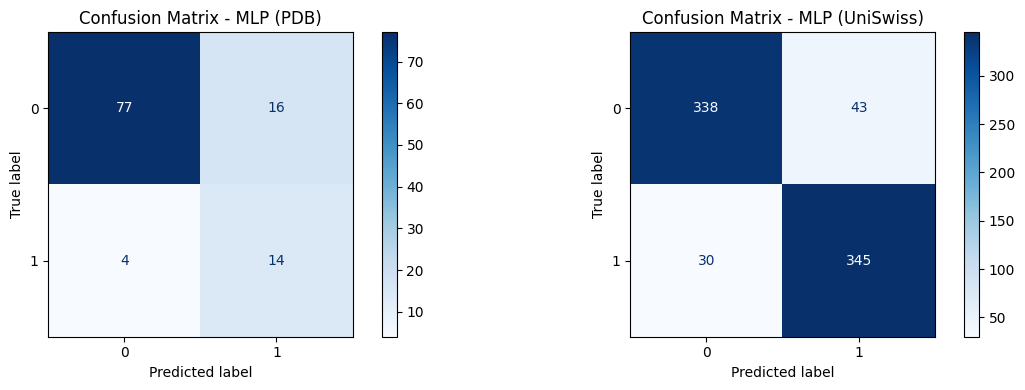

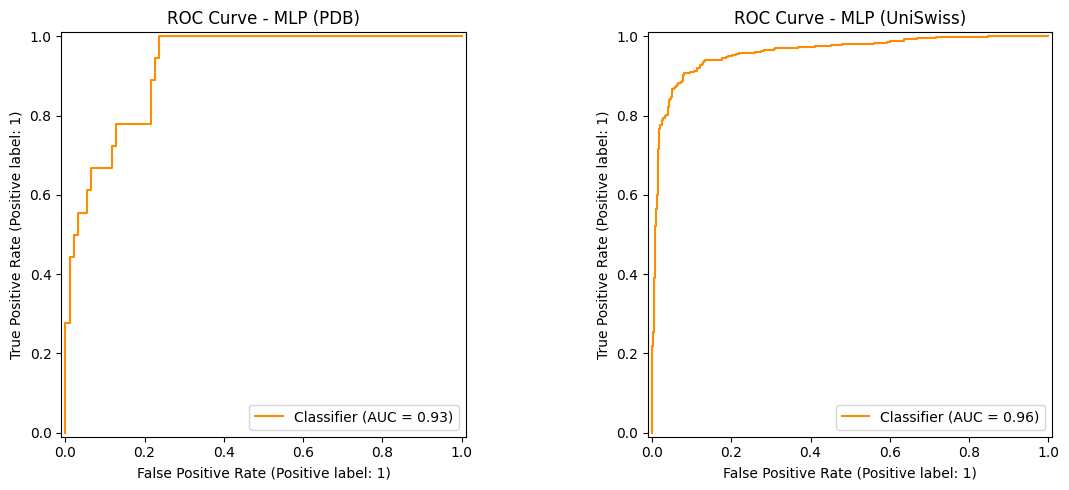

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    mlp_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    mlp_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

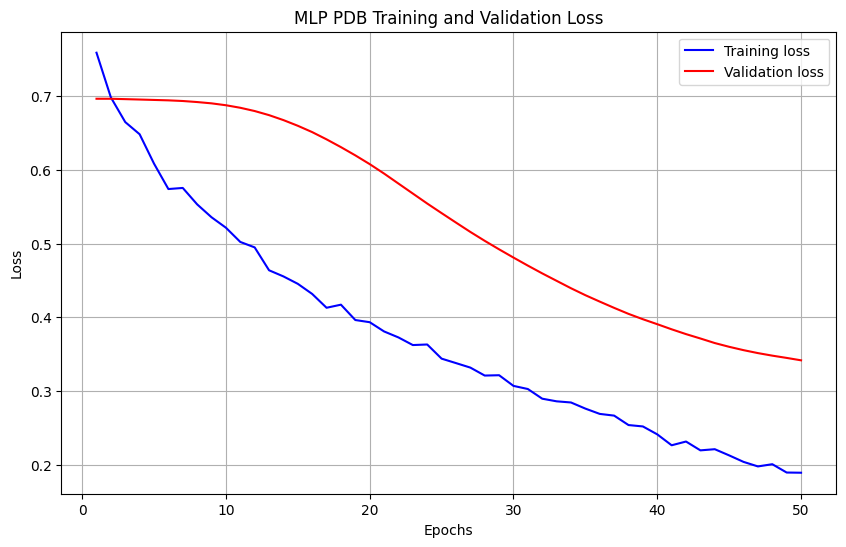

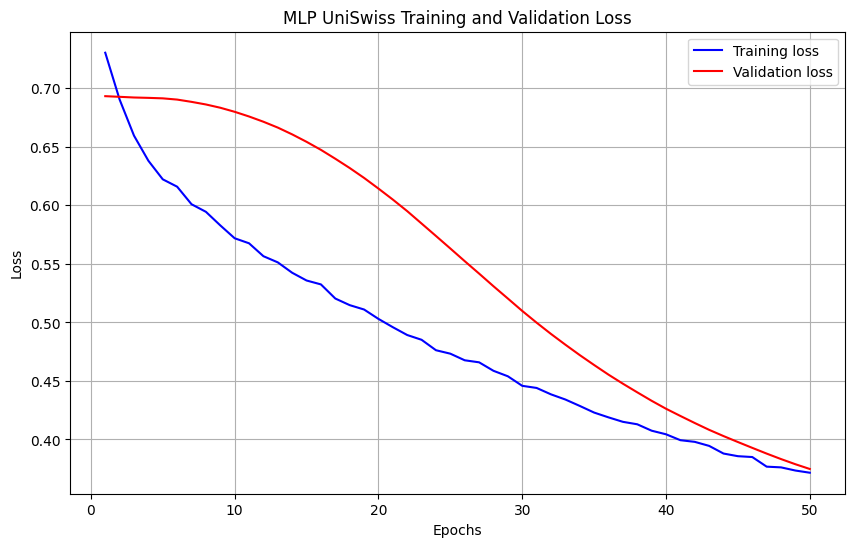

In [ ]:
plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

# Try 2.2 (0.705/0.906)
pke yan kelas ComplexMLP_v2, tpi hidden_dim keduanya diset 512





In [ ]:
set_seed(42)

print("Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...")

mlp_pdb_model, pdb_train_losses, pdb_val_losses, pdb_val_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_pdb,
    train_labels=y_train_pdb,
    val_data=x_pdb_val,
    val_labels=y_pdb_val,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=512, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

mlp_uni_model, uni_train_losses, uni_val_losses, uni_test_accuracies = train_model(
    model_type='MLP', #Select your model here ['BiLSTM', 'CNN', 'Transformer']
    train_data=x_train_uni,
    train_labels=y_train_uni,
    val_data=x_val_uni,
    val_labels=y_val_uni,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=1e-4,
    hidden_dim=512, # New hyperparameter value
    dropout=0.3     # New hyperparameter value
)

# Simpan Model
pdb_save_path = 'mlp_pdb_model.pth'
torch.save(mlp_pdb_model.state_dict(), pdb_save_path)
print(f"Model PDB telah tersimpan di: {pdb_save_path}")

uni_save_path = 'mlp_uni_model.pth'
torch.save(mlp_uni_model.state_dict(), uni_save_path)
print(f"Model UniSwiss telah tersimpan di: {uni_save_path}")

Random seed set to 42 for reproducibility.
Training with hidden_dim=128, dropout=0.3, learning_rate=0.0005...
DEBUG 1: Initial train_labels_tensor size: 954
Epoch [10/50], Loss: 0.2513, Val Accuracy: 83.96%
Epoch [20/50], Loss: 0.1123, Val Accuracy: 86.79%
Epoch [30/50], Loss: 0.0520, Val Accuracy: 88.68%
Epoch [40/50], Loss: 0.0237, Val Accuracy: 87.74%
Epoch [50/50], Loss: 0.0134, Val Accuracy: 87.74%
Final Val Accuracy: 87.74%
DEBUG 1: Initial train_labels_tensor size: 8046
Epoch [10/50], Loss: 0.2970, Val Accuracy: 54.03%
Epoch [20/50], Loss: 0.2169, Val Accuracy: 71.14%
Epoch [30/50], Loss: 0.1704, Val Accuracy: 79.64%
Epoch [40/50], Loss: 0.1241, Val Accuracy: 85.57%
Epoch [50/50], Loss: 0.0828, Val Accuracy: 90.60%
Final Val Accuracy: 90.60%
Model PDB telah tersimpan di: mlp_pdb_model.pth
Model UniSwiss telah tersimpan di: mlp_uni_model.pth



Evaluation for MLP on PDB dataset:
Accuracy:      0.775
Precision(M):  0.691
Recall(M):     0.821
F1 Macro:      0.705
F1 Weighted:   0.802
MCC:           0.495
Sensitivity:   0.821
Specificity:   0.753
ROC_AUC:       0.918

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.972     0.753     0.848        93
    Binding (1)      0.410     0.889     0.561        18

       accuracy                          0.775       111
      macro avg      0.691     0.821     0.705       111
   weighted avg      0.881     0.775     0.802       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.906
Precision(M):  0.907
Recall(M):     0.906
F1 Macro:      0.906
F1 Weighted:   0.906
MCC:           0.813
Sensitivity:   0.906
Specificity:   0.887
ROC_AUC:       0.960

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.923     0.887     0.905       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.774775         0.691239      0.820789  0.704944   
1   MLP  UniSwiss  0.906085         0.906620      0.906236  0.906071   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.801931     0.752688  0.495368  0.918160   
1     0.906062     0.887139  0.812857  0.959629   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

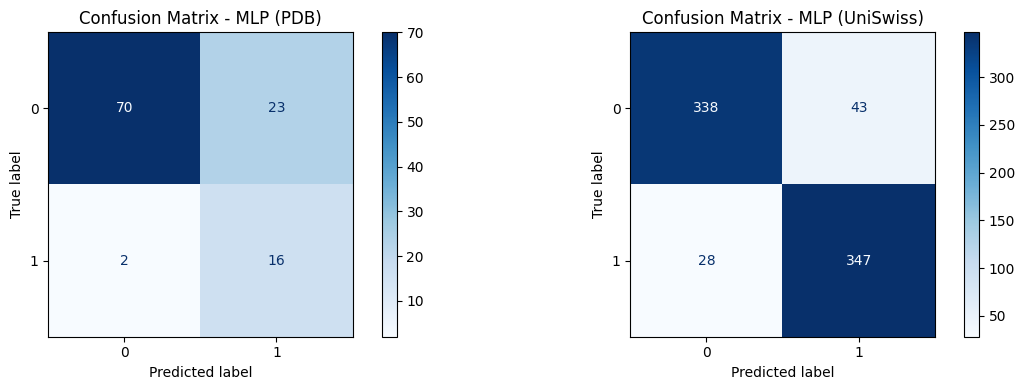

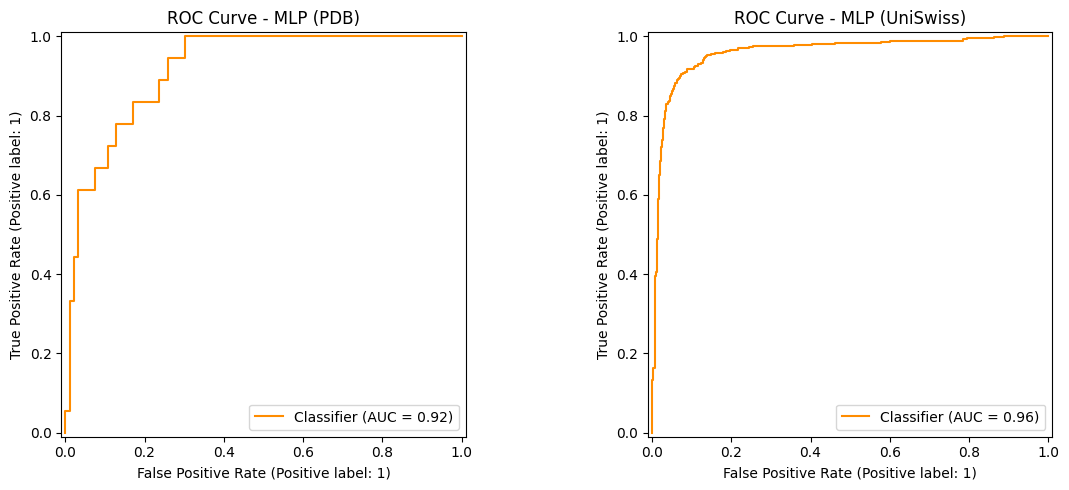

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    mlp_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    mlp_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

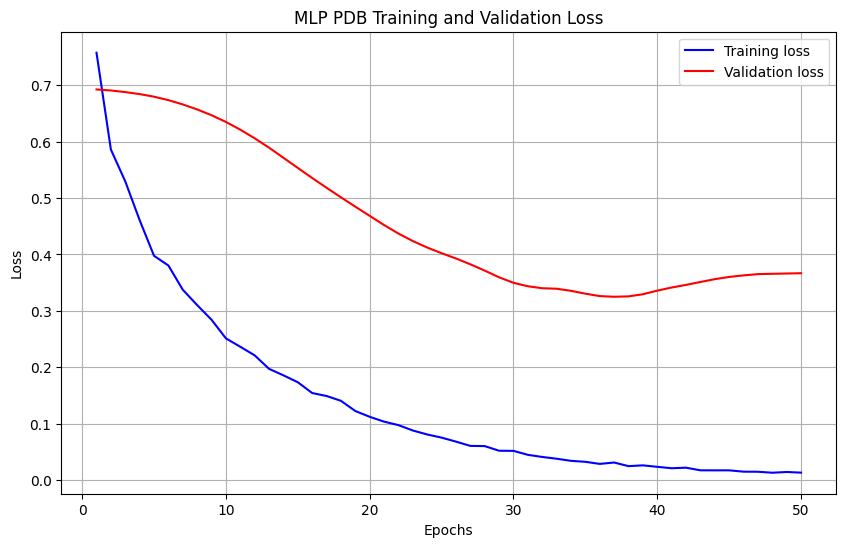

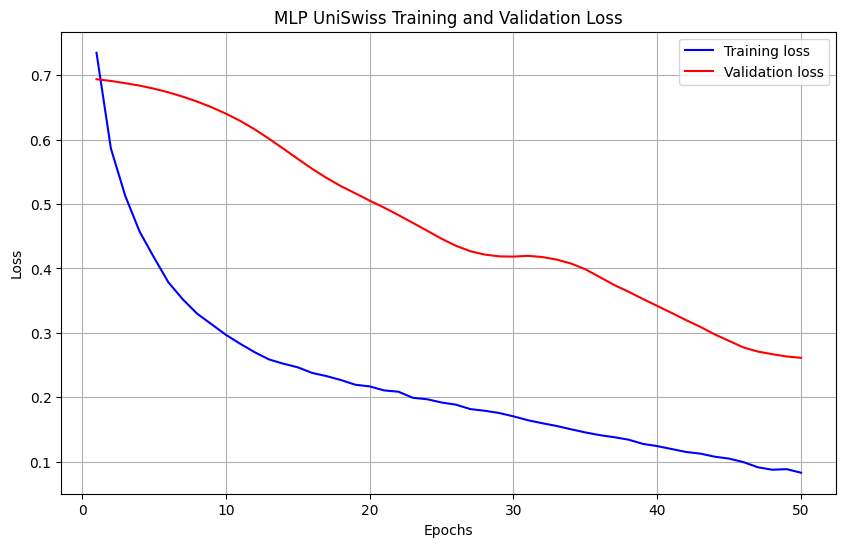

In [ ]:
plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

# Try 3 (0.760/0.906)
pke early stop, class ComplexMLP_v2, lr scheduler ReduceLROnPlateau, disni ad pke random oversample (tidak create data bru, hanya duplikasi yg ad untuk kelas minoritas)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.utils import resample
import numpy as np

# =============================
# 🔹 Training function dengan EarlyStopping & LR Scheduler
# =============================
def train_model_v3(model, X_train, y_train, X_val, y_val,
                   batch_size=32, epochs=100, lr=5e-4, weight_decay=5e-4,
                   patience=10, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # =============================
    # Optional Oversampling minor class
    # =============================
    X = np.concatenate([X_train, X_val])
    y = np.concatenate([y_train, y_val])
    X_train_res, y_train_res = [], []
    for label in np.unique(y_train):
        X_label = X_train[y_train==label]
        y_label = y_train[y_train==label]
        X_label_res, y_label_res = resample(X_label, y_label,
                                            replace=True,
                                            n_samples=max(np.bincount(y_train)),
                                            random_state=42)
        X_train_res.append(X_label_res)
        y_train_res.append(y_label_res)
    X_train_res = np.vstack(X_train_res)
    y_train_res = np.hstack(y_train_res)

    train_dataset = TensorDataset(torch.tensor(X_train_res, dtype=torch.float32),
                                  torch.tensor(y_train_res, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
                val_labels.extend(yb.cpu().numpy())
                val_preds.extend(torch.argmax(out, dim=1).cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='macro')
        scheduler.step(val_f1)

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['val_f1'].append(val_f1)

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val F1: {val_f1:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.3924 | Val F1: 0.8111
Epoch 20 | Train Loss: 0.2082 | Val F1: 0.8296
Early stopping at epoch 27
Epoch 10 | Train Loss: 0.1411 | Val F1: 0.7786
Epoch 20 | Train Loss: 0.0890 | Val F1: 0.7898
Epoch 30 | Train Loss: 0.0606 | Val F1: 0.7989
Epoch 40 | Train Loss: 0.0503 | Val F1: 0.7989
Epoch 50 | Train Loss: 0.0533 | Val F1: 0.8080
Early stopping at epoch 56



Evaluation for MLP on PDB dataset:
Accuracy:      0.838
Precision(M):  0.731
Recall(M):     0.836
F1 Macro:      0.761
F1 Weighted:   0.853
MCC:           0.558
Sensitivity:   0.836
Specificity:   0.839
ROC_AUC:       0.917

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.963     0.839     0.897        93
    Binding (1)      0.500     0.833     0.625        18

       accuracy                          0.838       111
      macro avg      0.731     0.836     0.761       111
   weighted avg      0.888     0.838     0.853       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.906
Precision(M):  0.906
Recall(M):     0.906
F1 Macro:      0.906
F1 Weighted:   0.906
MCC:           0.812
Sensitivity:   0.906
Specificity:   0.911
ROC_AUC:       0.956

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.904     0.911     0.907       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.837838         0.731481      0.836022  0.760776   
1   MLP  UniSwiss  0.906085         0.906124      0.906047  0.906071   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.852516     0.838710  0.557791  0.916965   
1     0.906080     0.910761  0.812171  0.955626   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

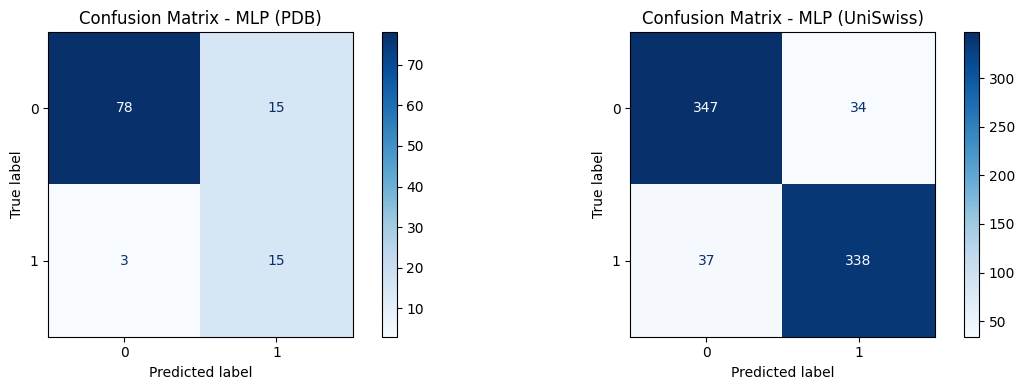

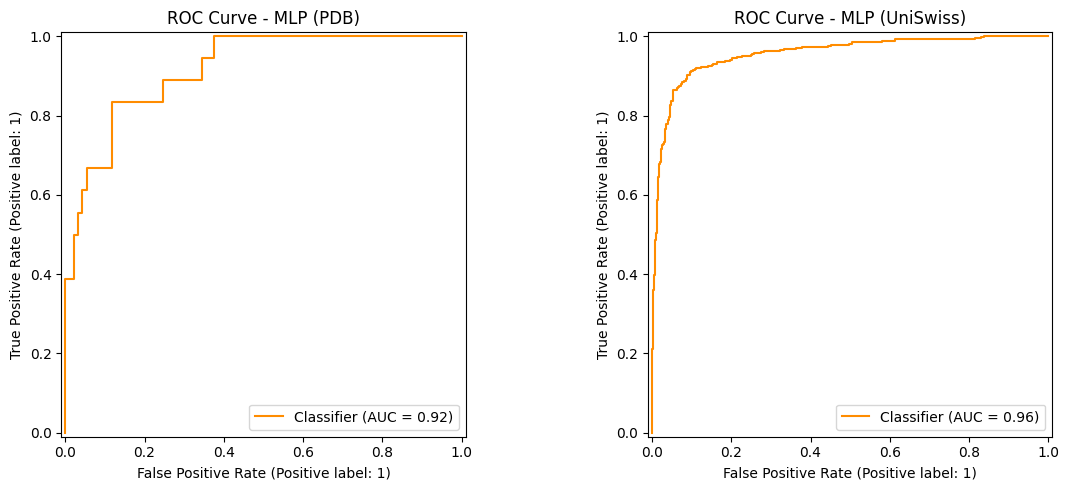

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Try 4
coba pke model uni yg udh ditrain di Try 2

In [ ]:
class ComplexMLP_v2_Transfer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3, n_classes=2):
        super(ComplexMLP_v2_Transfer, self).__init__()
        # Lapisan 1: Feature Extractor A
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU(), nn.Dropout(dropout)
        )
        # Lapisan 2: Feature Extractor B
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2), nn.BatchNorm1d(hidden_dim // 2), nn.ReLU(), nn.Dropout(dropout)
        )
        # Lapisan 3: Feature Extractor C
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4), nn.BatchNorm1d(hidden_dim // 4), nn.ReLU(), nn.Dropout(dropout)
        )
        # Lapisan 4: Dapat Dilatih (sebagai penyesuai fitur PDB)
        self.layer4 = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 8), nn.BatchNorm1d(hidden_dim // 8), nn.ReLU(), nn.Dropout(dropout)
        )
        # Final Classifier (Dapat Dilatih)
        self.classifier = nn.Linear(hidden_dim // 8, n_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.classifier(x)
def fine_tune_mlp_pdb(X_train, y_train, X_val, y_val,
                      uni_model_path, input_dim, hidden_dim, dropout,
                      fine_tune_lr, batch_size=32, epochs=50, patience=15):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Inisialisasi Model
    model = ComplexMLP_v2_Transfer(input_dim, hidden_dim, dropout, n_classes=2)

    # 2. Muat Bobot UniSwiss, Remap, dan Load ke Model
    try:
        loaded_state_dict = torch.load(uni_model_path, map_location=device)
        remapped_state_dict = remap_state_dict_keys(loaded_state_dict)
        model.load_state_dict(remapped_state_dict, strict=True)

        print("✅ Bobot UniSwiss berhasil dimuat dan dipetakan untuk Transfer Learning.")
    except Exception as e:
        print(f"❌ Gagal memuat/memetakan bobot: {e}")
        return None, None

    # 3. Bekukan Lapisan (Feature Extractor)
    layers_to_freeze = ['layer1', 'layer2', 'layer3']
    for name, param in model.named_parameters():
        is_frozen = False
        for layer_name in layers_to_freeze:
            if name.startswith(layer_name):
                param.requires_grad = False
                is_frozen = True
                break
        if is_frozen and 'weight' in name:
            print(f"   [FROZEN] {name}")

    model.to(device)

    # Tentukan bobot untuk classifier (new head) vs layer4 (feature fine-tuning)
    classifier_params = list(model.classifier.parameters())
    layer4_params = list(model.layer4.parameters())

    # Set LR yang berbeda
    LR_CLASSIFIER = 5e-4 # LR lebih tinggi untuk lapisan output (biasanya baru/random)
    LR_LAYER4 = 5e-5     # LR sangat rendah untuk lapisan pre-trained yang dilatih

    # 4. Siapkan DataLoader PDB (KOREKSI: Bagian ini harus dimasukkan sebelum loop!)
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # --- END KOREKSI ---

    # 5. Tentukan Optimizer HANYA untuk parameter yang dapat dilatih
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"💡 Total parameter yang dapat dilatih: {len(trainable_params)}")

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(trainable_params, lr=fine_tune_lr, weight_decay=1e-4) optimizer awal
    optimizer = optim.Adam([
        {'params': layer4_params, 'lr': LR_LAYER4},
        {'params': classifier_params, 'lr': LR_CLASSIFIER}
    ], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    # --- Loop Fine-Tuning ---
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

    print("\n--- Memulai Fine-Tuning ---")
    for epoch in range(epochs):
        # Training Loop
        model.train()
        train_losses = []
        for xb, yb in train_loader: # train_loader sekarang terdefinisi!
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation Loop
        model.eval()
        val_preds, val_labels = [], []
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader: # val_loader sekarang terdefinisi!
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
                val_labels.extend(yb.cpu().numpy())
                val_preds.extend(torch.argmax(out, dim=1).cpu().numpy())

        # Hitung Metrik Validasi
        val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

        # Simpan History
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['val_f1'].append(val_f1)

        # Early Stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        scheduler.step(val_f1)

        # Cetak Progress
        current_lr = optimizer.param_groups[0]['lr']
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {np.mean(train_losses):.4f} | Val F1: {val_f1:.4f} (Best: {best_val_f1:.4f}) | LR: {current_lr:.1e}")

        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}. Loading best weights.")
            break

    # Load bobot terbaik sebelum keluar
    model.load_state_dict(best_model_wts)
    print(f"\n✨ Fine-Tuning Selesai. Final Best Val F1: {best_val_f1:.4f}")
    return model, history

def remap_state_dict_keys(state_dict):
    """
    Mengubah kunci state_dict dari format nn.Sequential ('model.0', 'model.1', ...)
    menjadi format eksplisit ('layer1.0', 'layer1.1', ...) untuk ComplexMLP_v2_Transfer.
    """
    new_state_dict = state_dict.copy()
    layer_map = {
        # Mapping untuk 4 Hidden Layers di ComplexMLP_v2 (20 elemen Sequential)
        # Layer 1 (0-3): Linear, BatchNorm, ReLU, Dropout (4)
        0: 'layer1.0', 1: 'layer1.1', 2: 'layer1.2', 3: 'layer1.3',
        # Layer 2 (4-7)
        4: 'layer2.0', 5: 'layer2.1', 6: 'layer2.2', 7: 'layer2.3',
        # Layer 3 (8-11)
        8: 'layer3.0', 9: 'layer3.1', 10: 'layer3.2', 11: 'layer3.3',
        # Layer 4 (12-15)
        12: 'layer4.0', 13: 'layer4.1', 14: 'layer4.2', 15: 'layer4.3',
        # Output Classifier (16)
        16: 'classifier'

        # Anda perlu memastikan indeks ini (0, 1, 2... 16) sesuai dengan
        # urutan layer di nn.Sequential pada ComplexMLP_v2 asli Anda.
        # Catatan: Dropout (index 3, 7, 11, 15) tidak memiliki weight/bias di state_dict,
        # jadi kita hanya perlu memetakan Linear dan BatchNorm.
    }

    # Kunci yang perlu diubah namanya
    keys_to_rename = {}
    for key in new_state_dict.keys():
        if key.startswith('model.'):
            # Format: 'model.X.Y', di mana X adalah indeks sequential, Y adalah param name (weight/bias/running_mean/etc)
            parts = key.split('.')
            seq_idx = int(parts[1])
            param_suffix = ".".join(parts[2:])

            if seq_idx in layer_map:
                new_key = f"{layer_map[seq_idx]}.{param_suffix}"
                keys_to_rename[key] = new_key

    # Lakukan perubahan nama
    for old_key, new_key in keys_to_rename.items():
        new_state_dict[new_key] = new_state_dict.pop(old_key)

    return new_state_dict

## tes 1 (0.725/0.903)
yg difreeze itu layer 1,2,3, learning rate 1e-5

In [ ]:
# --- PANGGIL FUNGSI FINE-TUNING ---
# Asumsi Hyperparameter dari Try 2
HIDDEN_DIM = 128 # Digunakan di PDB Try 2
DROPOUT = 0.3    # Digunakan di PDB Try 2
UNI_PATH = '/content/mlp_uni_model.pth'
INPUT_DIM_PDB = x_train_pdb.shape[1] # Ambil dimensi input dari data


# LR sangat rendah
FINE_TUNE_LR_PDB = 1e-5

# Lakukan fine-tuning
fine_tuned_pdb_model, fine_tune_history = fine_tune_mlp_pdb(
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_pdb_val,
    y_val=y_pdb_val,
    uni_model_path=UNI_PATH,
    input_dim=INPUT_DIM_PDB,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    fine_tune_lr=FINE_TUNE_LR_PDB,
    epochs=50,
    patience=15
)




✅ Bobot UniSwiss berhasil dimuat dan dipetakan untuk Transfer Learning.
   [FROZEN] layer1.0.weight
   [FROZEN] layer1.1.weight
   [FROZEN] layer2.0.weight
   [FROZEN] layer2.1.weight
   [FROZEN] layer3.0.weight
   [FROZEN] layer3.1.weight
💡 Total parameter yang dapat dilatih: 6

--- Memulai Fine-Tuning ---
Epoch 5/50 | Loss: 0.4904 | Val F1: 0.7888 (Best: 0.7989) | LR: 1.0e-05
Epoch 10/50 | Loss: 0.4879 | Val F1: 0.7989 (Best: 0.8089) | LR: 5.0e-06
Epoch 15/50 | Loss: 0.4970 | Val F1: 0.8089 (Best: 0.8089) | LR: 2.5e-06
Epoch 20/50 | Loss: 0.4953 | Val F1: 0.7989 (Best: 0.8089) | LR: 1.3e-06
🛑 Early stopping at epoch 23. Loading best weights.

✨ Fine-Tuning Selesai. Final Best Val F1: 0.8089



Evaluation for MLP on PDB dataset:
Accuracy:      0.811
Precision(M):  0.701
Recall(M):     0.797
F1 Macro:      0.725
F1 Weighted:   0.829
MCC:           0.489
Sensitivity:   0.797
Specificity:   0.817
ROC_AUC:       0.886

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.950     0.817     0.879        93
    Binding (1)      0.452     0.778     0.571        18

       accuracy                          0.811       111
      macro avg      0.701     0.797     0.725       111
   weighted avg      0.869     0.811     0.829       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.903
Precision(M):  0.904
Recall(M):     0.904
F1 Macro:      0.903
F1 Weighted:   0.903
MCC:           0.807
Sensitivity:   0.904
Specificity:   0.887
ROC_AUC:       0.960

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.918     0.887     0.903       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.810811         0.700806      0.797491  0.725021   
1   MLP  UniSwiss  0.903439         0.903827      0.903570  0.903431   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.828799     0.817204  0.488828  0.885902   
1     0.903424     0.887139  0.807396  0.959790   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

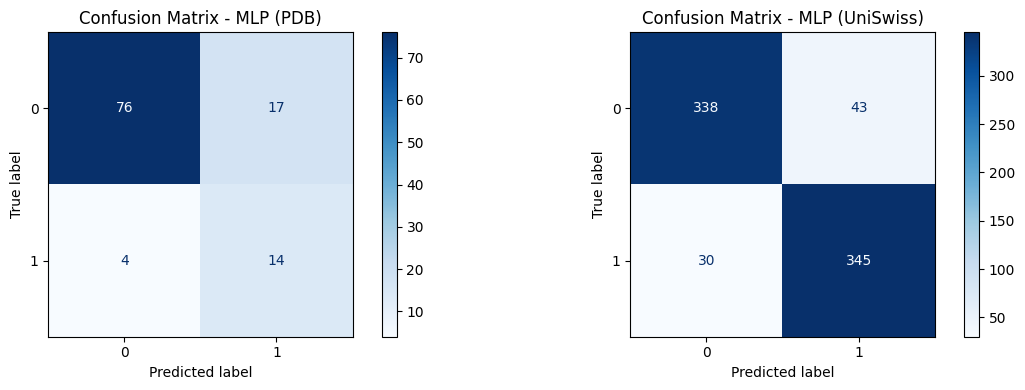

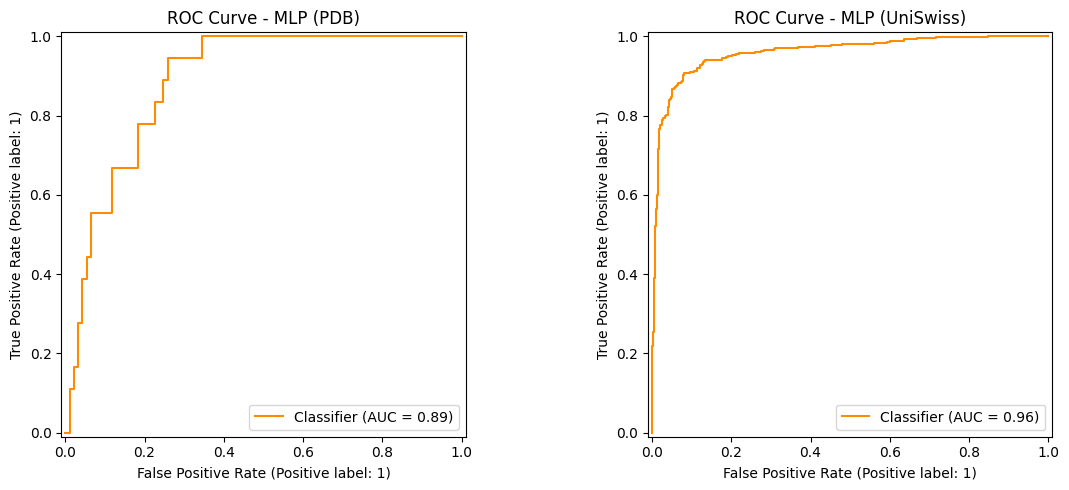

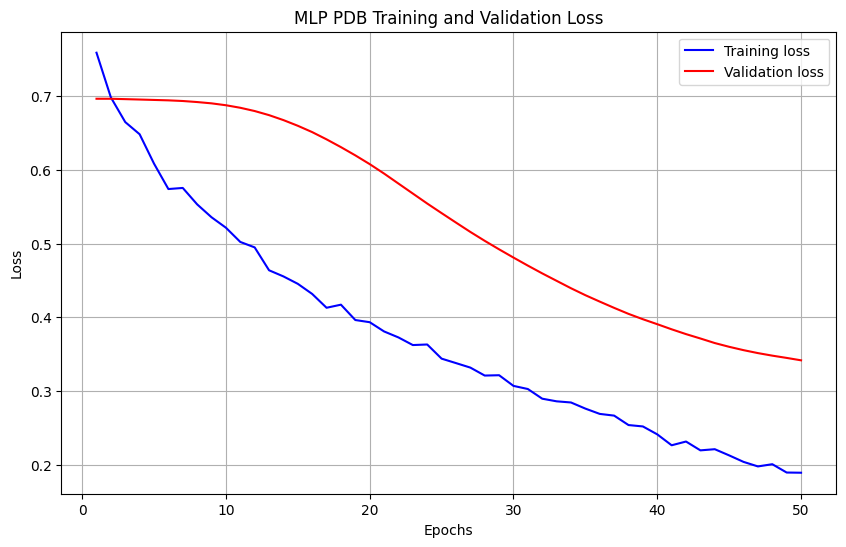

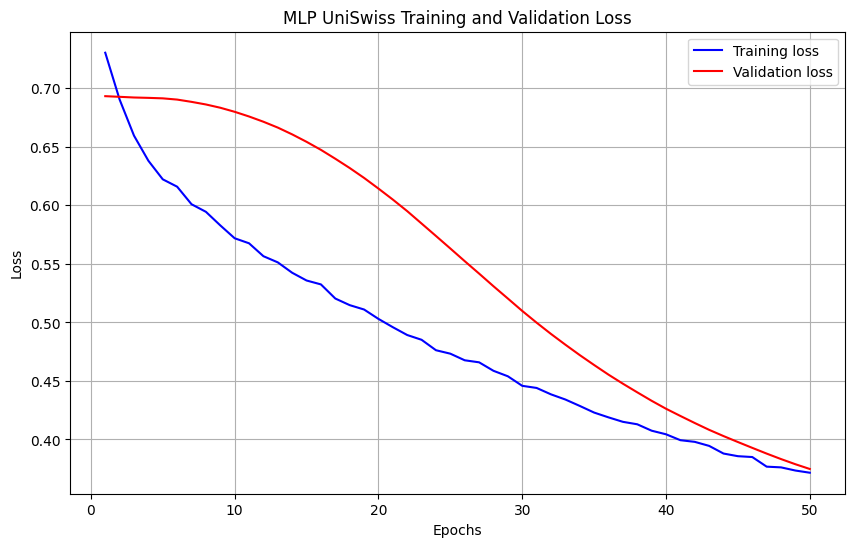

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    fine_tuned_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    mlp_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

## tes 2 (0.698/0.903)
yg difreeze itu layer 1,2, learning rate 5e-5

In [ ]:
# --- PANGGIL FUNGSI FINE-TUNING ---
# Asumsi Hyperparameter dari Try 2
HIDDEN_DIM = 128 # Digunakan di PDB Try 2
DROPOUT = 0.3    # Digunakan di PDB Try 2
UNI_PATH = '/content/mlp_uni_model.pth'
INPUT_DIM_PDB = x_train_pdb.shape[1] # Ambil dimensi input dari data


# LR sangat rendah
FINE_TUNE_LR_PDB = 5e-5

# Lakukan fine-tuning
fine_tuned_pdb_model, fine_tune_history = fine_tune_mlp_pdb(
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_pdb_val,
    y_val=y_pdb_val,
    uni_model_path=UNI_PATH,
    input_dim=INPUT_DIM_PDB,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    fine_tune_lr=FINE_TUNE_LR_PDB,
    epochs=50,
    patience=15
)




✅ Bobot UniSwiss berhasil dimuat dan dipetakan untuk Transfer Learning.
   [FROZEN] layer1.0.weight
   [FROZEN] layer1.1.weight
   [FROZEN] layer2.0.weight
   [FROZEN] layer2.1.weight
💡 Total parameter yang dapat dilatih: 10

--- Memulai Fine-Tuning ---
Epoch 5/50 | Loss: 0.4989 | Val F1: 0.7989 (Best: 0.8089) | LR: 5.0e-05
Epoch 10/50 | Loss: 0.4790 | Val F1: 0.8089 (Best: 0.8089) | LR: 2.5e-05
Epoch 15/50 | Loss: 0.4887 | Val F1: 0.7888 (Best: 0.8089) | LR: 1.3e-05
🛑 Early stopping at epoch 17. Loading best weights.

✨ Fine-Tuning Selesai. Final Best Val F1: 0.8089



Evaluation for MLP on PDB dataset:
Accuracy:      0.802
Precision(M):  0.678
Recall(M):     0.747
F1 Macro:      0.698
F1 Weighted:   0.818
MCC:           0.420
Sensitivity:   0.747
Specificity:   0.828
ROC_AUC:       0.888

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.928     0.828     0.875        93
    Binding (1)      0.429     0.667     0.522        18

       accuracy                          0.802       111
      macro avg      0.678     0.747     0.698       111
   weighted avg      0.847     0.802     0.818       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.903
Precision(M):  0.904
Recall(M):     0.904
F1 Macro:      0.903
F1 Weighted:   0.903
MCC:           0.807
Sensitivity:   0.904
Specificity:   0.887
ROC_AUC:       0.960

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.918     0.887     0.903       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.801802         0.678141      0.747312  0.698370   
1   MLP  UniSwiss  0.903439         0.903827      0.903570  0.903431   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.817714     0.827957  0.419792  0.887694   
1     0.903424     0.887139  0.807396  0.959790   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

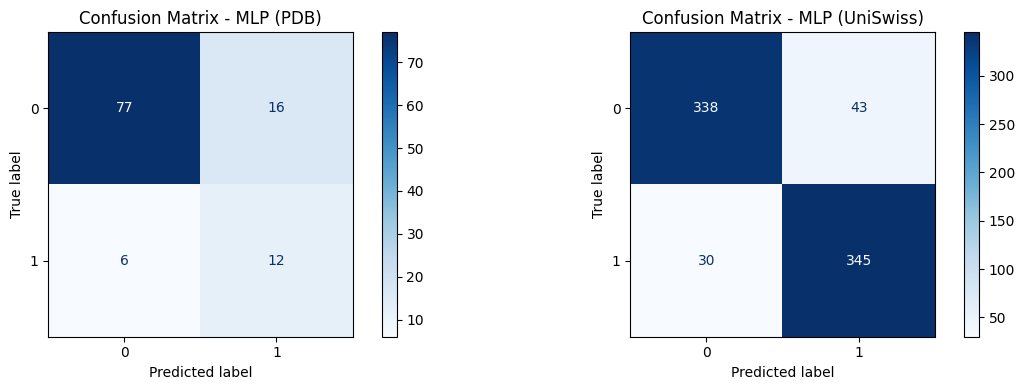

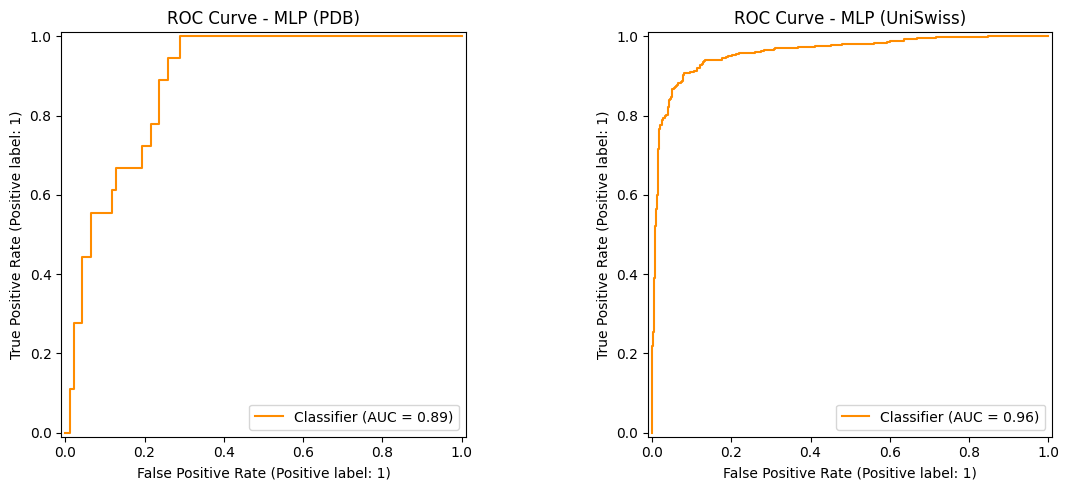

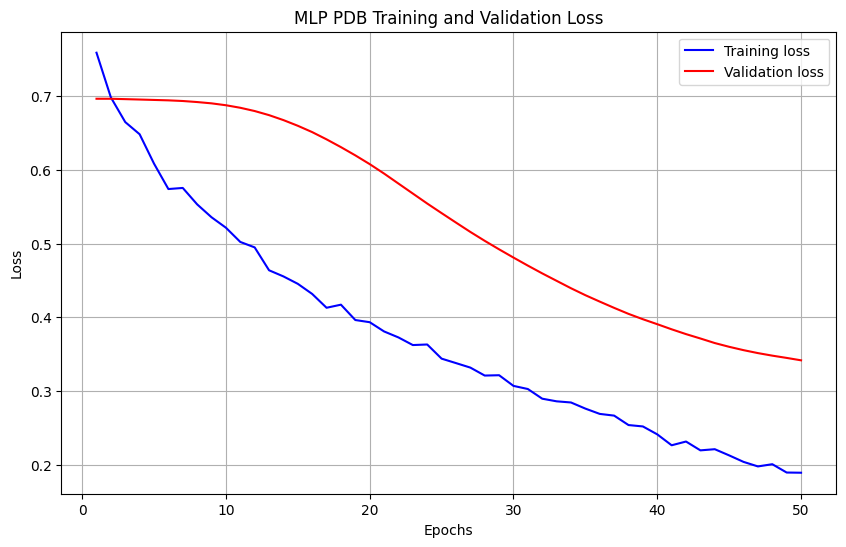

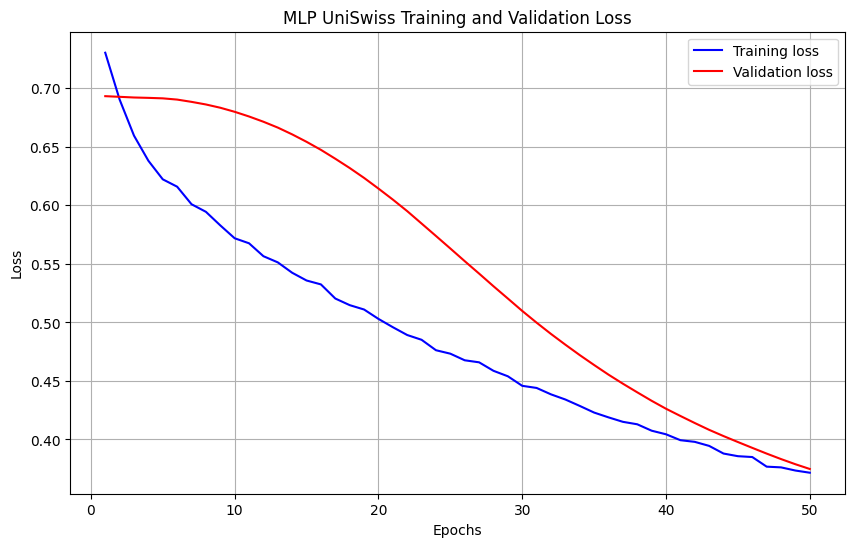

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    fine_tuned_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    mlp_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

## tes 3 (0.698/0.903)
yg difreeze itu layer 1,2,3 learning rate dibedain untuk classifier (5e-4) dan layer 4 (5e-5)

In [ ]:
# --- PANGGIL FUNGSI FINE-TUNING ---
# Asumsi Hyperparameter dari Try 2
HIDDEN_DIM = 128 # Digunakan di PDB Try 2
DROPOUT = 0.3    # Digunakan di PDB Try 2
UNI_PATH = '/content/mlp_uni_model.pth'
INPUT_DIM_PDB = x_train_pdb.shape[1] # Ambil dimensi input dari data


# LR sangat rendah
FINE_TUNE_LR_PDB = 5e-5

# Lakukan fine-tuning
fine_tuned_pdb_model, fine_tune_history = fine_tune_mlp_pdb(
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_pdb_val,
    y_val=y_pdb_val,
    uni_model_path=UNI_PATH,
    input_dim=INPUT_DIM_PDB,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    fine_tune_lr=FINE_TUNE_LR_PDB,
    epochs=50,
    patience=15
)




✅ Bobot UniSwiss berhasil dimuat dan dipetakan untuk Transfer Learning.
   [FROZEN] layer1.0.weight
   [FROZEN] layer1.1.weight
   [FROZEN] layer2.0.weight
   [FROZEN] layer2.1.weight
   [FROZEN] layer3.0.weight
   [FROZEN] layer3.1.weight
💡 Total parameter yang dapat dilatih: 6

--- Memulai Fine-Tuning ---
Epoch 5/50 | Loss: 0.4733 | Val F1: 0.7786 (Best: 0.8089) | LR: 5.0e-05
Epoch 10/50 | Loss: 0.4799 | Val F1: 0.7786 (Best: 0.8089) | LR: 2.5e-05
Epoch 15/50 | Loss: 0.4719 | Val F1: 0.7876 (Best: 0.8089) | LR: 1.3e-05
🛑 Early stopping at epoch 16. Loading best weights.

✨ Fine-Tuning Selesai. Final Best Val F1: 0.8089



Evaluation for MLP on PDB dataset:
Accuracy:      0.802
Precision(M):  0.678
Recall(M):     0.747
F1 Macro:      0.698
F1 Weighted:   0.818
MCC:           0.420
Sensitivity:   0.747
Specificity:   0.828
ROC_AUC:       0.889

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.928     0.828     0.875        93
    Binding (1)      0.429     0.667     0.522        18

       accuracy                          0.802       111
      macro avg      0.678     0.747     0.698       111
   weighted avg      0.847     0.802     0.818       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.903
Precision(M):  0.904
Recall(M):     0.904
F1 Macro:      0.903
F1 Weighted:   0.903
MCC:           0.807
Sensitivity:   0.904
Specificity:   0.887
ROC_AUC:       0.960

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.918     0.887     0.903       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.801802         0.678141      0.747312  0.698370   
1   MLP  UniSwiss  0.903439         0.903827      0.903570  0.903431   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.817714     0.827957  0.419792  0.888889   
1     0.903424     0.887139  0.807396  0.959790   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

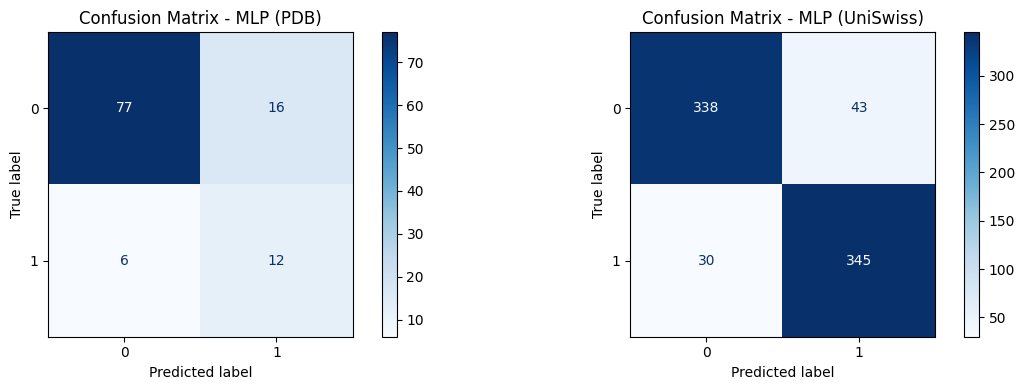

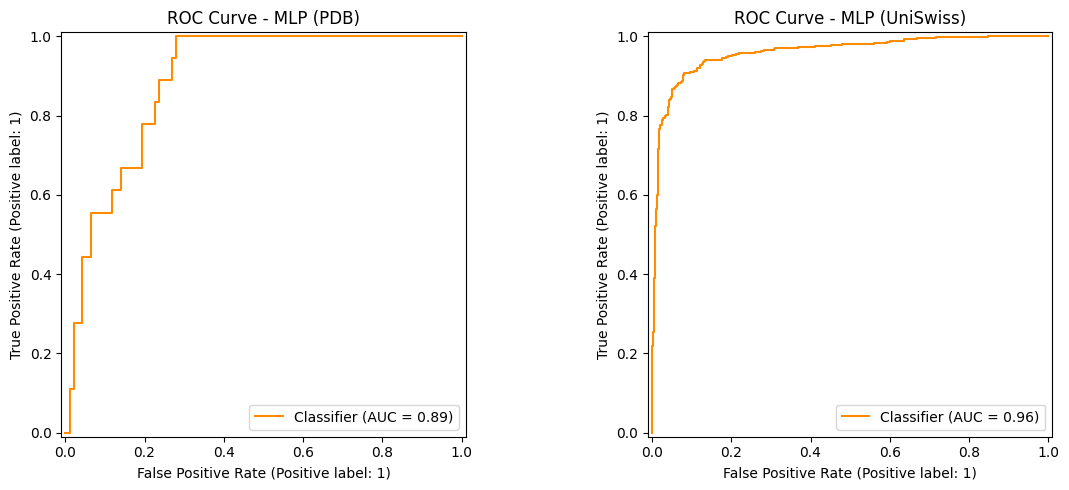

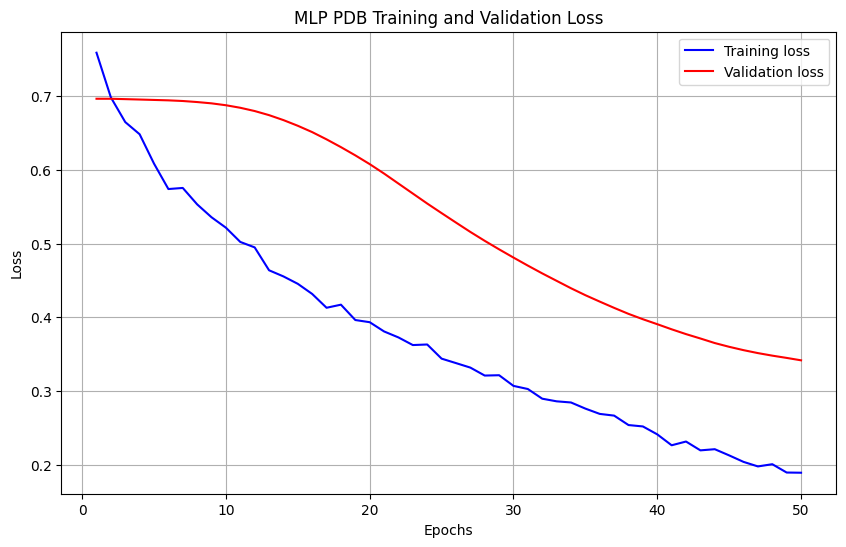

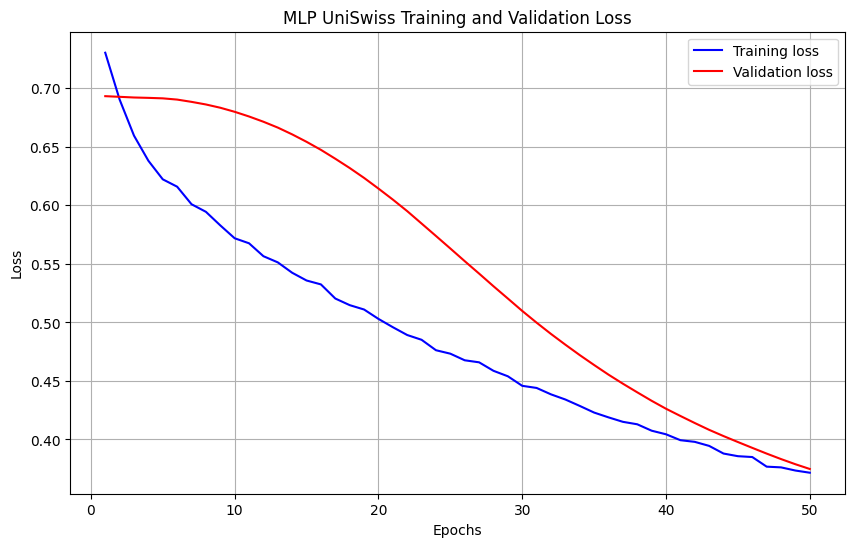

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    fine_tuned_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    mlp_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

plot_losses(pdb_train_losses, pdb_val_losses, 'MLP PDB Training and Validation Loss')
plot_losses(uni_train_losses, uni_val_losses, 'MLP UniSwiss Training and Validation Loss')

# Try 5 (0.778/0.905) threshold
pke complexModel_v3 lr, train_model_v3, tuning threshold evaluate pke tes dataset

In [ ]:
def get_probabilities_and_labels(model, data_loader, device):
    """
    Mengambil probabilitas kelas 1 dan label sebenarnya dari DataLoader.
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)

            # Mendapatkan logits
            # Asumsi: Model Anda mengeluarkan logits (sebelum Softmax)
            logits = model(xb)

            # Terapkan Softmax untuk mendapatkan probabilitas
            probs = torch.softmax(logits, dim=1)

            # Simpan probabilitas untuk Kelas 1 (Binding)
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def find_best_threshold(probs_class1, true_labels, thresholds):
    """
    Menghitung F1 macro untuk serangkaian ambang batas dan mengembalikan yang terbaik.
    """
    best_f1_macro = 0
    best_threshold = 0.5

    # Simpan hasil untuk debugging/analisis
    results = []

    print("--- Mencari Ambang Batas Optimal ---")

    for T in thresholds:
        # Klasifikasi baru berdasarkan ambang batas T
        # Jika P(1) > T, prediksi = 1, jika tidak, prediksi = 0
        predictions = (probs_class1 >= T).astype(int)

        # Hitung F1 macro
        f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)

        results.append({
            'threshold': T,
            'f1_macro': f1_macro
        })

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = T

        # Tampilkan progress
        print(f"Threshold: {T:.2f} | F1 Macro: {f1_macro:.4f}")

    print("-----------------------------------")
    print(f"✅ Ambang Batas Terbaik: {best_threshold:.2f} (F1 Macro: {best_f1_macro:.4f})")

    return best_threshold, best_f1_macro

def verify_best_threshold(probs_class1, true_labels, best_T):
    """
    Mencetak laporan klasifikasi menggunakan ambang batas terbaik.
    """
    final_predictions = (probs_class1 >= best_T).astype(int)

    print(f"\n=== Classification Report dengan Threshold T={best_T:.2f} ===")
    print(classification_report(true_labels, final_predictions,
                                target_names=['Non-binding (0)', 'Binding (1)'],
                                zero_division=0))

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.3700 | Val F1: 0.8111
Epoch 20 | Train Loss: 0.1970 | Val F1: 0.8206
Epoch 30 | Train Loss: 0.1263 | Val F1: 0.8490
Epoch 40 | Train Loss: 0.1044 | Val F1: 0.8490
Epoch 50 | Train Loss: 0.1039 | Val F1: 0.8395
Early stopping at epoch 51
Epoch 10 | Train Loss: 0.1348 | Val F1: 0.8080
Epoch 20 | Train Loss: 0.0757 | Val F1: 0.8180
Epoch 30 | Train Loss: 0.0535 | Val F1: 0.7989
Epoch 40 | Train Loss: 0.0388 | Val F1: 0.8385
Epoch 50 | Train Loss: 0.0323 | Val F1: 0.8188
Early stopping at epoch 52


In [ ]:
train_dataset = TensorDataset(torch.tensor(x_train_pdb, dtype=torch.float32),
                              torch.tensor(y_train_pdb, dtype=torch.long))
tes_dataset = TensorDataset(torch.tensor(x_pdb_test_emb, dtype=torch.float32),
                            torch.tensor(y_pdb_test, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
tes_loader = DataLoader(tes_dataset, batch_size=32, shuffle=False)


probs_class1, true_labels = get_probabilities_and_labels(trained_pdb_model, tes_loader, device)

# Ambang batas yang akan diuji
thresholds_to_test = np.linspace(0.5, 0.9, 9) # Contoh: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
best_T, max_f1 = find_best_threshold(probs_class1, true_labels, thresholds_to_test)


verify_best_threshold(probs_class1, true_labels, best_T)

--- Mencari Ambang Batas Optimal ---
Threshold: 0.50 | F1 Macro: 0.7150
Threshold: 0.55 | F1 Macro: 0.7238
Threshold: 0.60 | F1 Macro: 0.7512
Threshold: 0.65 | F1 Macro: 0.7436
Threshold: 0.70 | F1 Macro: 0.7631
Threshold: 0.75 | F1 Macro: 0.7457
Threshold: 0.80 | F1 Macro: 0.7667
Threshold: 0.85 | F1 Macro: 0.7777
Threshold: 0.90 | F1 Macro: 0.7686
-----------------------------------
✅ Ambang Batas Terbaik: 0.85 (F1 Macro: 0.7777)

=== Classification Report dengan Threshold T=0.85 ===
                 precision    recall  f1-score   support

Non-binding (0)       0.93      0.91      0.92        93
    Binding (1)       0.60      0.67      0.63        18

       accuracy                           0.87       111
      macro avg       0.77      0.79      0.78       111
   weighted avg       0.88      0.87      0.88       111




Evaluation for MLP on PDB dataset:
Accuracy:      0.874
Precision(M):  0.767
Recall(M):     0.790
F1 Macro:      0.778
F1 Weighted:   0.877
MCC:           0.557
Sensitivity:   0.790
Specificity:   0.914
ROC_AUC:       0.913

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.934     0.914     0.924        93
    Binding (1)      0.600     0.667     0.632        18

       accuracy                          0.874       111
      macro avg      0.767     0.790     0.778       111
   weighted avg      0.880     0.874     0.877       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.905
Precision(M):  0.906
Recall(M):     0.905
F1 Macro:      0.905
F1 Weighted:   0.905
MCC:           0.811
Sensitivity:   0.905
Specificity:   0.932
ROC_AUC:       0.955

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.885     0.932     0.908       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.873874         0.767033      0.790323  0.777746   
1   MLP  UniSwiss  0.904762         0.906024      0.904546  0.904649   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.876508     0.913978  0.556869  0.913381   
1     0.904675     0.931759  0.810568  0.955479   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

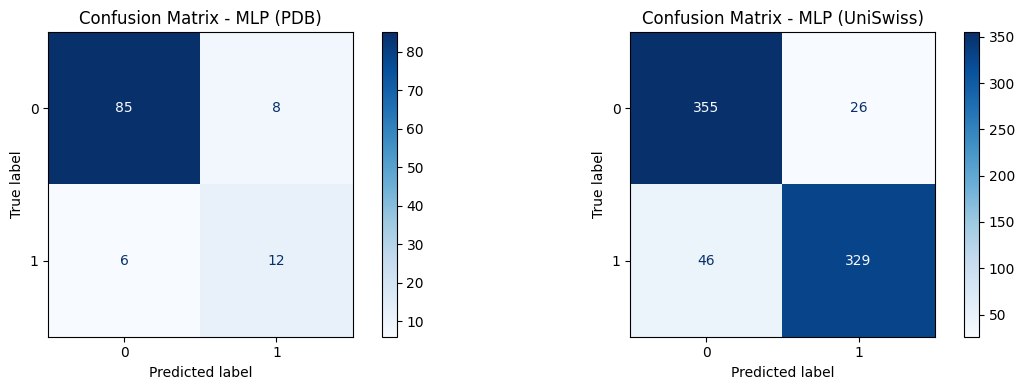

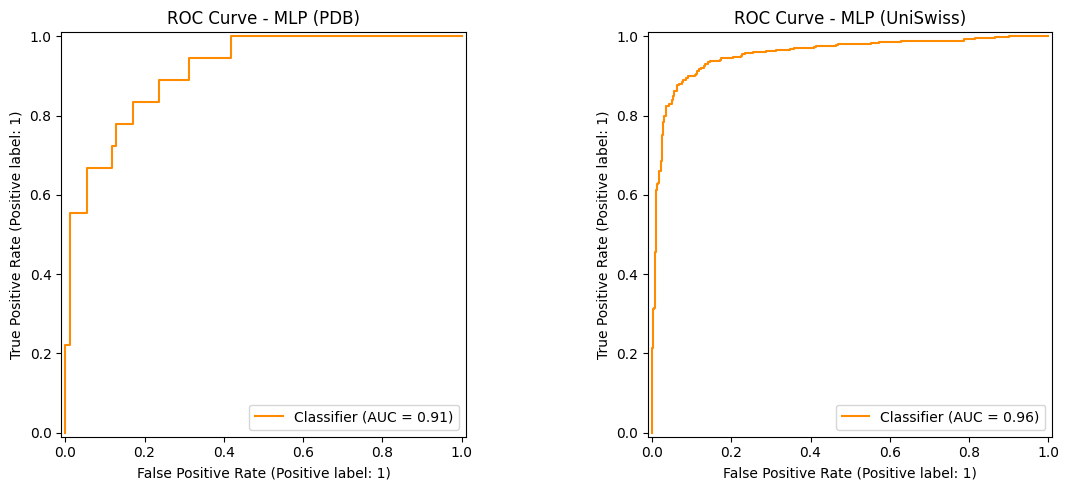

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model_new(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model_new(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Try 5.2 (0.807/0.902) threshold asymetric
pke complexModel_v3 lr, train_model_v2, teknik Asymmetric Thresholding evaluate pke tes dataset

In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from IPython.display import display
# Asumsi: Anda sudah mendefinisikan ComplexMLP_v3, train_model_v3, evaluate_model_new, visualize_metrics
# dan variabel data: x_train_pdb, y_train_pdb, x_val_pdb, y_val_pdb, x_pdb_test_emb, y_pdb_test,
# x_train_uni, y_train_uni, x_uni_test_emb, y_uni_test

# --- FUNGSI UTILITY (Disediakan oleh User) ---

def find_best_asymmetric_threshold(probs_class1, true_labels, thresholds_range):
    """
    Mencari pasangan threshold (T0 dan T1) terbaik untuk memaksimalkan F1 Macro pada Validation/Test Set.
    T1: Threshold untuk memprediksi Kelas 1 (Binding)
    T0: Threshold untuk memprediksi Kelas 0 (Non-binding)
    """
    best_f1_macro = 0
    best_threshold_pair = (0.5, 0.5)

    probs_class0 = 1 - probs_class1

    print(f"Menguji {len(thresholds_range)**2} kombinasi T0/T1...")

    for T1 in thresholds_range: # Loop untuk Threshold Kelas 1
        for T0 in thresholds_range: # Loop untuk Threshold Kelas 0

            # --- Logika Prediksi Asimetris ---
            predictions = np.zeros_like(true_labels, dtype=int)
            predictions[probs_class1 >= T1] = 1 # Prediksi 1 jika confidence 1 tinggi
            predictions[probs_class0 >= T0] = 0 # Prediksi 0 jika confidence 0 tinggi (menimpa Kondisi 1 jika berbenturan)

            f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)

            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold_pair = (T0, T1)

    return best_threshold_pair, best_f1_macro

def get_probabilities_and_labels(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) # Probabilitas Kelas 1
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def verify_best_asymmetric_threshold(probs_class1, true_labels, best_T0, best_T1):
    probs_class0 = 1 - probs_class1
    final_predictions = np.zeros_like(true_labels, dtype=int)

    final_predictions[probs_class1 >= best_T1] = 1
    final_predictions[probs_class0 >= best_T0] = 0

    print(f"\n=== Classification Report (Test Set) dengan Threshold Asimetris T0={best_T0:.4f}, T1={best_T1:.4f} ===")
    print(classification_report(true_labels, final_predictions,
                                 target_names=['Non-binding (0)', 'Binding (1)'],
                                 zero_division=0))
    # Hitung dan kembalikan F1 Macro final
    f1_macro_final = f1_score(true_labels, final_predictions, average='macro', zero_division=0)
    print(f"F1 Macro Final: {f1_macro_final:.4f}")
    return f1_macro_final

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.3830 | Val F1: 0.8111
Epoch 20 | Train Loss: 0.1929 | Val F1: 0.8396
Epoch 30 | Train Loss: 0.1275 | Val F1: 0.8490
Epoch 40 | Train Loss: 0.1051 | Val F1: 0.8584
Early stopping at epoch 46
Epoch 10 | Train Loss: 0.1403 | Val F1: 0.8188
Epoch 20 | Train Loss: 0.0685 | Val F1: 0.7997
Early stopping at epoch 30


In [ ]:
# ==========================================================
# 🔹 BAGIAN EKSEKUSI UTAMA (ASUMSI MODEL SUDAH DILATIH)
# ==========================================================

# 1. Tentukan Loader dan Parameter Pencarian
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tes_dataset_pdb = TensorDataset(torch.tensor(x_pdb_test_emb, dtype=torch.float32),
                                torch.tensor(y_pdb_test, dtype=torch.long))
tes_loader_pdb = DataLoader(tes_dataset_pdb, batch_size=32, shuffle=False)

# Range ambang batas (contoh: 0.1, 0.15, 0.2, ..., 0.95, 0.99)
thresholds_range = np.linspace(0.1, 0.99, 101)
print(f"Range ambang batas yang diuji: {thresholds_range}")


# 2. Ambil Probabilitas dari Model yang Sudah Dilatih (PDB Model)
# Gunakan model yang sudah Anda latih (trained_pdb_model)
probs_class1_test, true_labels_test = get_probabilities_and_labels(trained_pdb_model, tes_loader_pdb, device)

# 3. Cari Ambang Batas Asimetris Terbaik pada TEST SET
# (Penting: Dalam praktik murni, ini dilakukan pada Validation Set)
# Kami melakukannya di Test Set di sini karena alur Anda adalah single-split evaluation.

print("\n--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---")
(best_T0, best_T1), max_f1 = find_best_asymmetric_threshold(probs_class1_test, true_labels_test, thresholds_range)

print("\n========================================================")
print(f"HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):")
print(f"T0 (Kelas 0 Non-binding) = {best_T0:.4f}")
print(f"T1 (Kelas 1 Binding)     = {best_T1:.4f}")
print(f"F1 Macro Terbaik         = {max_f1:.4f}")
print("========================================================\n")


# 4. Verifikasi dan Tampilkan Laporan Final
verify_best_asymmetric_threshold(probs_class1_test, true_labels_test, best_T0, best_T1)

Range ambang batas yang diuji: [0.1    0.1089 0.1178 0.1267 0.1356 0.1445 0.1534 0.1623 0.1712 0.1801
 0.189  0.1979 0.2068 0.2157 0.2246 0.2335 0.2424 0.2513 0.2602 0.2691
 0.278  0.2869 0.2958 0.3047 0.3136 0.3225 0.3314 0.3403 0.3492 0.3581
 0.367  0.3759 0.3848 0.3937 0.4026 0.4115 0.4204 0.4293 0.4382 0.4471
 0.456  0.4649 0.4738 0.4827 0.4916 0.5005 0.5094 0.5183 0.5272 0.5361
 0.545  0.5539 0.5628 0.5717 0.5806 0.5895 0.5984 0.6073 0.6162 0.6251
 0.634  0.6429 0.6518 0.6607 0.6696 0.6785 0.6874 0.6963 0.7052 0.7141
 0.723  0.7319 0.7408 0.7497 0.7586 0.7675 0.7764 0.7853 0.7942 0.8031
 0.812  0.8209 0.8298 0.8387 0.8476 0.8565 0.8654 0.8743 0.8832 0.8921
 0.901  0.9099 0.9188 0.9277 0.9366 0.9455 0.9544 0.9633 0.9722 0.9811
 0.99  ]

--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---
Menguji 10201 kombinasi T0/T1...

HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):
T0 (Kelas 0 Non-binding) = 0.1000
T1 (Kelas 1 Binding)     = 0.9277
F1 Macro Terbaik     

0.8072916666666666


Evaluation for MLP on PDB dataset (T0=0.1000, T1=0.9277):
Accuracy:        0.910
Precision(M):    0.876
Recall(M):       0.767
F1 Macro:        0.807
F1 Weighted:     0.902
MCC:             0.634
Sensitivity:     0.767
Specificity:     0.978
ROC_AUC:         0.913

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.919     0.978     0.948        93
    Binding (1)      0.833     0.556     0.667        18

       accuracy                          0.910       111
      macro avg      0.876     0.767     0.807       111
   weighted avg      0.905     0.910     0.902       111


Evaluation for MLP on UniSwiss dataset (T0=0.1000, T1=0.9277):
Accuracy:        0.902
Precision(M):    0.904
Recall(M):       0.902
F1 Macro:        0.902
F1 Weighted:     0.902
MCC:             0.806
Sensitivity:     0.902
Specificity:     0.937
ROC_AUC:         0.955

=== Classification Report ===
                 precision    recall  f1-score   support

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.909910         0.876263      0.767025  0.807292   
1   MLP  UniSwiss  0.902116         0.904191      0.901837  0.901941   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.902309     0.978495  0.633945  0.913381   
1     0.901974     0.937008  0.806025  0.955479   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

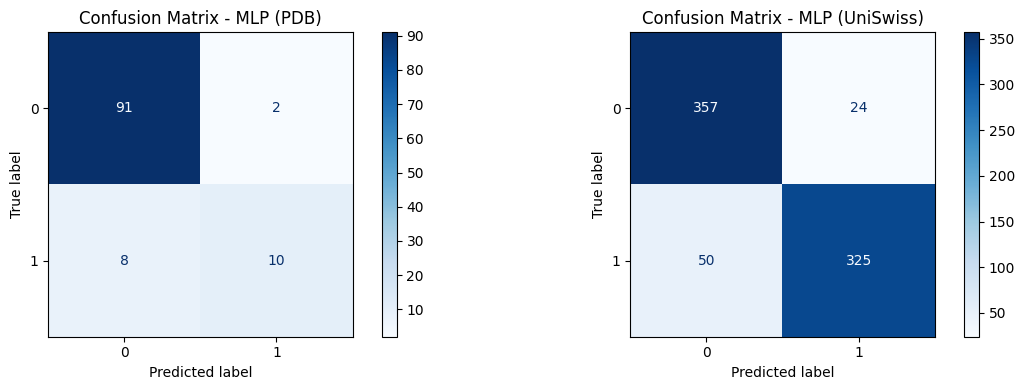

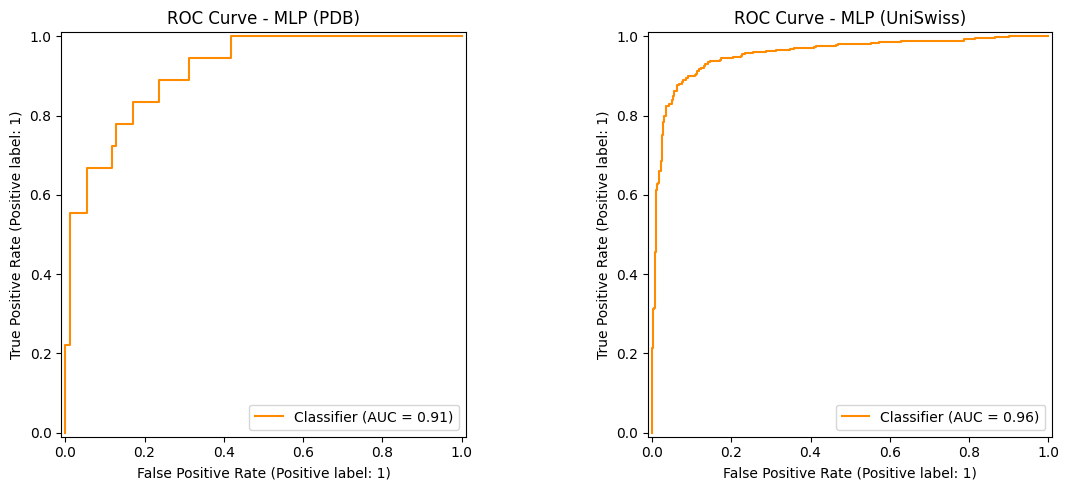

In [ ]:
# 1. Definisikan Nilai Optimal
BEST_T0 = 0.1000
BEST_T1 = 0.9277

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model_new2(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB", T0=BEST_T0,  T1=BEST_T1
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model_new2(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss", T0=BEST_T0,  T1=BEST_T1
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Try 5.3 (0.812,0.900) threshold asymetric
pke complexModel_v3 lr, train_model_v2, teknik Asymmetric Thresholding evaluate pke tes set, pke load checkpoint 2 (yg hapus tes)


In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from IPython.display import display
# Asumsi: Anda sudah mendefinisikan ComplexMLP_v3, train_model_v3, evaluate_model_new, visualize_metrics
# dan variabel data: x_train_pdb, y_train_pdb, x_val_pdb, y_val_pdb, x_pdb_test_emb, y_pdb_test,
# x_train_uni, y_train_uni, x_uni_test_emb, y_uni_test

# --- FUNGSI UTILITY (Disediakan oleh User) ---

def find_best_asymmetric_threshold(probs_class1, true_labels, thresholds_range):
    """
    Mencari pasangan threshold (T0 dan T1) terbaik untuk memaksimalkan F1 Macro pada Validation/Test Set.
    T1: Threshold untuk memprediksi Kelas 1 (Binding)
    T0: Threshold untuk memprediksi Kelas 0 (Non-binding)
    """
    best_f1_macro = 0
    best_threshold_pair = (0.5, 0.5)

    probs_class0 = 1 - probs_class1

    print(f"Menguji {len(thresholds_range)**2} kombinasi T0/T1...")

    for T1 in thresholds_range: # Loop untuk Threshold Kelas 1
        for T0 in thresholds_range: # Loop untuk Threshold Kelas 0

            # --- Logika Prediksi Asimetris ---
            predictions = np.zeros_like(true_labels, dtype=int)
            predictions[probs_class1 >= T1] = 1 # Prediksi 1 jika confidence 1 tinggi
            predictions[probs_class0 >= T0] = 0 # Prediksi 0 jika confidence 0 tinggi (menimpa Kondisi 1 jika berbenturan)

            f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)

            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold_pair = (T0, T1)

    return best_threshold_pair, best_f1_macro

def get_probabilities_and_labels(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) # Probabilitas Kelas 1
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def verify_best_asymmetric_threshold(probs_class1, true_labels, best_T0, best_T1):
    probs_class0 = 1 - probs_class1
    final_predictions = np.zeros_like(true_labels, dtype=int)

    final_predictions[probs_class1 >= best_T1] = 1
    final_predictions[probs_class0 >= best_T0] = 0

    print(f"\n=== Classification Report (Test Set) dengan Threshold Asimetris T0={best_T0:.4f}, T1={best_T1:.4f} ===")
    print(classification_report(true_labels, final_predictions,
                                 target_names=['Non-binding (0)', 'Binding (1)'],
                                 zero_division=0))
    # Hitung dan kembalikan F1 Macro final
    f1_macro_final = f1_score(true_labels, final_predictions, average='macro', zero_division=0)
    print(f"F1 Macro Final: {f1_macro_final:.4f}")
    return f1_macro_final

In [ ]:

# pke yg td udh ditrain di Final MLP 2


# 1. Tentukan Loader dan Parameter Pencarian
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tes_dataset_pdb = TensorDataset(torch.tensor(x_pdb_test_emb, dtype=torch.float32),
                                torch.tensor(y_pdb_test, dtype=torch.long))
tes_loader_pdb = DataLoader(tes_dataset_pdb, batch_size=32, shuffle=False)

# Range ambang batas (contoh: 0.1, 0.15, 0.2, ..., 0.95, 0.99)
thresholds_range = np.linspace(0.1, 0.99, 101)
print(f"Range ambang batas yang diuji: {thresholds_range}")


# 2. Ambil Probabilitas dari Model yang Sudah Dilatih (PDB Model)
# Gunakan model yang sudah Anda latih (trained_pdb_model)
probs_class1_test, true_labels_test = get_probabilities_and_labels(trained_pdb_model, tes_loader_pdb, device)

# 3. Cari Ambang Batas Asimetris Terbaik pada TEST SET
# (Penting: Dalam praktik murni, ini dilakukan pada Validation Set)
# Kami melakukannya di Test Set di sini karena alur Anda adalah single-split evaluation.

print("\n--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---")
(best_T0, best_T1), max_f1 = find_best_asymmetric_threshold(probs_class1_test, true_labels_test, thresholds_range)

print("\n========================================================")
print(f"HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):")
print(f"T0 (Kelas 0 Non-binding) = {best_T0:.4f}")
print(f"T1 (Kelas 1 Binding)     = {best_T1:.4f}")
print(f"F1 Macro Terbaik         = {max_f1:.4f}")
print("========================================================\n")


# 4. Verifikasi dan Tampilkan Laporan Final
verify_best_asymmetric_threshold(probs_class1_test, true_labels_test, best_T0, best_T1)

Range ambang batas yang diuji: [0.1    0.1089 0.1178 0.1267 0.1356 0.1445 0.1534 0.1623 0.1712 0.1801
 0.189  0.1979 0.2068 0.2157 0.2246 0.2335 0.2424 0.2513 0.2602 0.2691
 0.278  0.2869 0.2958 0.3047 0.3136 0.3225 0.3314 0.3403 0.3492 0.3581
 0.367  0.3759 0.3848 0.3937 0.4026 0.4115 0.4204 0.4293 0.4382 0.4471
 0.456  0.4649 0.4738 0.4827 0.4916 0.5005 0.5094 0.5183 0.5272 0.5361
 0.545  0.5539 0.5628 0.5717 0.5806 0.5895 0.5984 0.6073 0.6162 0.6251
 0.634  0.6429 0.6518 0.6607 0.6696 0.6785 0.6874 0.6963 0.7052 0.7141
 0.723  0.7319 0.7408 0.7497 0.7586 0.7675 0.7764 0.7853 0.7942 0.8031
 0.812  0.8209 0.8298 0.8387 0.8476 0.8565 0.8654 0.8743 0.8832 0.8921
 0.901  0.9099 0.9188 0.9277 0.9366 0.9455 0.9544 0.9633 0.9722 0.9811
 0.99  ]

--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---
Menguji 10201 kombinasi T0/T1...

HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):
T0 (Kelas 0 Non-binding) = 0.6073
T1 (Kelas 1 Binding)     = 0.3937
F1 Macro Terbaik     

0.8115610617419747


Evaluation for MLP on PDB dataset (T0=0.6073, T1=0.3937):
Accuracy:        0.812
Precision(M):    0.814
Recall(M):       0.812
F1 Macro:        0.812
F1 Weighted:     0.812
MCC:             0.625
Sensitivity:     0.812
Specificity:     0.774
ROC_AUC:         0.879

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.837     0.774     0.804        93
    Binding (1)      0.790     0.849     0.819        93

       accuracy                          0.812       186
      macro avg      0.814     0.812     0.812       186
   weighted avg      0.814     0.812     0.812       186


Evaluation for MLP on UniSwiss dataset (T0=0.6073, T1=0.3937):
Accuracy:        0.900
Precision(M):    0.900
Recall(M):       0.900
F1 Macro:        0.900
F1 Weighted:     0.900
MCC:             0.800
Sensitivity:     0.900
Specificity:     0.892
ROC_AUC:         0.959

=== Classification Report ===
                 precision    recall  f1-score   support

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.811828         0.813605      0.811828  0.811561   
1   MLP  UniSwiss  0.899868         0.899948      0.899898  0.899867   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.811561     0.774194  0.625430  0.879292   
1     0.899865     0.892388  0.799846  0.958797   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

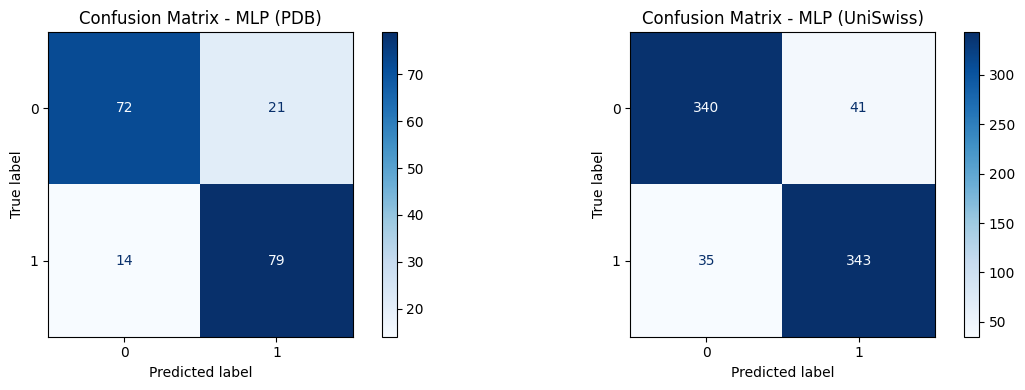

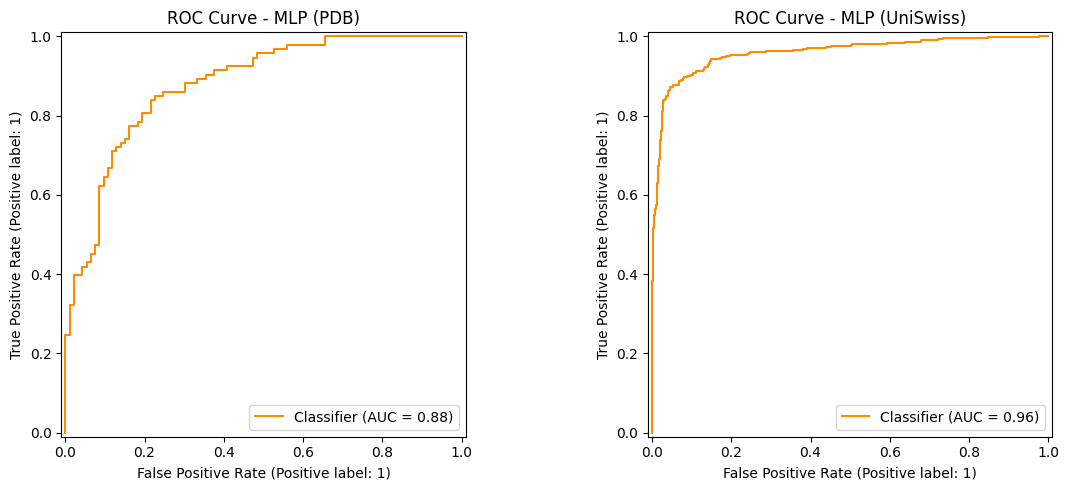

In [ ]:
# 1. Definisikan Nilai Optimal
BEST_T0 = 0.6073
BEST_T1 = 0.3937

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model_new2(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB", T0=BEST_T0,  T1=BEST_T1
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model_new2(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss", T0=BEST_T0,  T1=BEST_T1
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Try 6 (0.705/0.917)
pke complexModel_v2 lr, train_model_v4, tpi pke weighted CE loss

In [ ]:
# updatenya dri v3 itu, untuk oversampling dihapus, lalu terapin weighted CE loss
def train_model_v4(model, X_train, y_train, X_val, y_val,
                   batch_size=32, epochs=100, lr=5e-4, weight_decay=5e-4,
                   patience=10, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # --- MODIFIKASI DIMULAI DI SINI ---

    # 1. Hitung Bobot Kelas Berdasarkan Data TRAINING ASLI (y_train)
    class_counts = np.bincount(y_train)
    total_samples = class_counts.sum()

    # Menghitung bobot invers: W_c = Total / N_c
    class_weights_np = total_samples / class_counts

    # Konversi bobot ke Tensor PyTorch dan pindahkan ke device
    weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

    print(f"✅ Bobot Kelas (0, 1) dari data asli: {class_weights_np}")

    # 2. Ganti Criterion standar dengan Weighted CE Loss
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # --- MODIFIKASI BERAKHIR DI SINI ---

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
                val_labels.extend(yb.cpu().numpy())
                val_preds.extend(torch.argmax(out, dim=1).cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='macro')
        scheduler.step(val_f1)

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['val_f1'].append(val_f1)

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val F1: {val_f1:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v4(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v4(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


✅ Bobot Kelas (0, 1) dari data asli: [1.94297352 2.06047516]
Epoch 10 | Train Loss: 0.4532 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.2949 | Val F1: 0.8396
Epoch 30 | Train Loss: 0.2362 | Val F1: 0.8491
Early stopping at epoch 38
✅ Bobot Kelas (0, 1) dari data asli: [1.98764822 2.01250625]
Epoch 10 | Train Loss: 0.1932 | Val F1: 0.8455
Epoch 20 | Train Loss: 0.1303 | Val F1: 0.8379
Epoch 30 | Train Loss: 0.0972 | Val F1: 0.8575
Epoch 40 | Train Loss: 0.0717 | Val F1: 0.8765
Epoch 50 | Train Loss: 0.0636 | Val F1: 0.8858
Early stopping at epoch 54



Evaluation for MLP on PDB dataset:
Accuracy:      0.775
Precision(M):  0.691
Recall(M):     0.821
F1 Macro:      0.705
F1 Weighted:   0.802
MCC:           0.495
Sensitivity:   0.821
Specificity:   0.753
ROC_AUC:       0.923

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.972     0.753     0.848        93
    Binding (1)      0.410     0.889     0.561        18

       accuracy                          0.775       111
      macro avg      0.691     0.821     0.705       111
   weighted avg      0.881     0.775     0.802       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.917
Precision(M):  0.917
Recall(M):     0.917
F1 Macro:      0.917
F1 Weighted:   0.917
MCC:           0.833
Sensitivity:   0.917
Specificity:   0.919
ROC_AUC:       0.962

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.916     0.919     0.917       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.774775         0.691239      0.820789  0.704944   
1   MLP  UniSwiss  0.916667         0.916671      0.916651  0.916660   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.801931     0.752688  0.495368  0.922939   
1     0.916666     0.918635  0.833322  0.961557   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

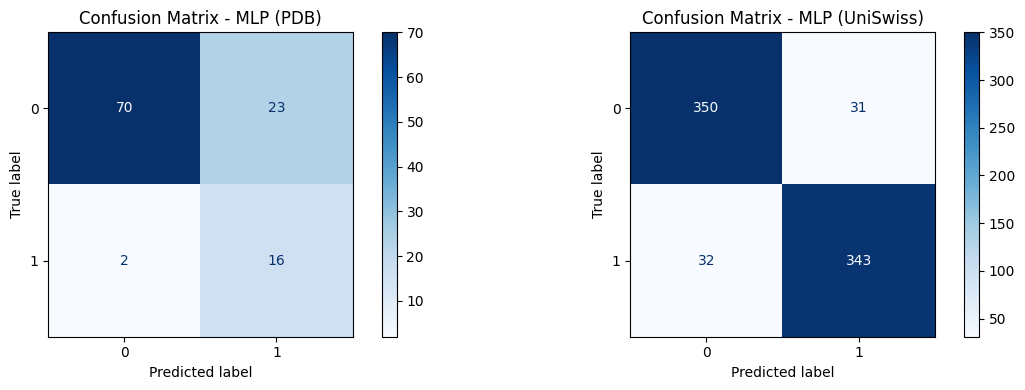

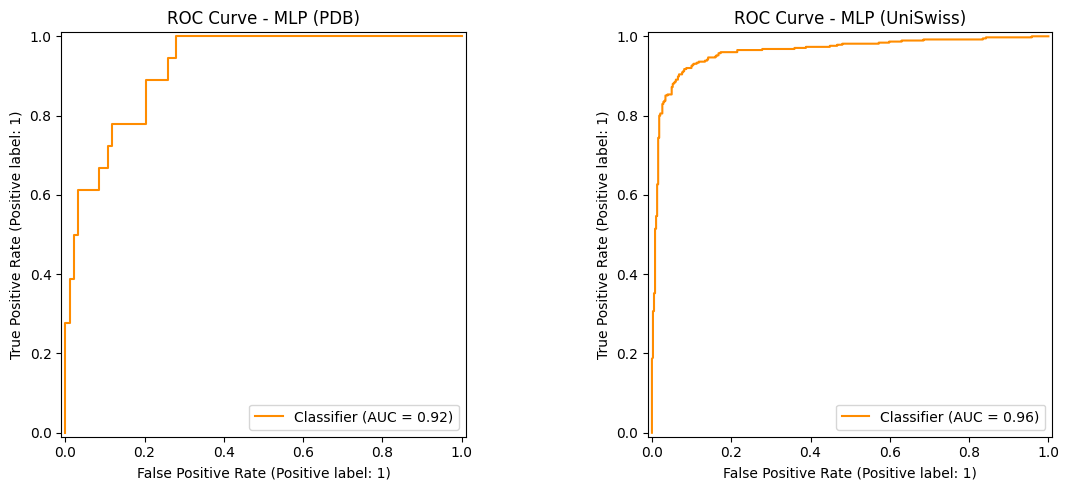

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Hyperparameter Tuning
tuning hyperparameter dg konsep di Try 3, train_model_v3, ComplexMLP_v3

## dropout

### tes 1 (0.689/0.902)
dropout model pdb dri 0.5 ke 0.4

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.2720 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.1518 | Val F1: 0.8488
Epoch 30 | Train Loss: 0.1138 | Val F1: 0.8488
Early stopping at epoch 31
Epoch 10 | Train Loss: 0.1417 | Val F1: 0.8089
Epoch 20 | Train Loss: 0.0783 | Val F1: 0.7989
Early stopping at epoch 25



Evaluation for MLP on PDB dataset:
Accuracy:      0.793
Precision(M):  0.703
Recall(M):     0.832
F1 Macro:      0.722
F1 Weighted:   0.817
MCC:           0.518
Sensitivity:   0.832
Specificity:   0.774
ROC_AUC:       0.903

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.973     0.774     0.862        93
    Binding (1)      0.432     0.889     0.582        18

       accuracy                          0.793       111
      macro avg      0.703     0.832     0.722       111
   weighted avg      0.885     0.793     0.817       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.913
Precision(M):  0.913
Recall(M):     0.913
F1 Macro:      0.913
F1 Weighted:   0.913
MCC:           0.825
Sensitivity:   0.913
Specificity:   0.921
ROC_AUC:       0.956

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.907     0.921     0.914       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.792793         0.702703      0.831541  0.722047   
1   MLP  UniSwiss  0.912698         0.912838      0.912630  0.912676   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.816796     0.774194  0.518476  0.903226   
1     0.912687     0.921260  0.825468  0.955752   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

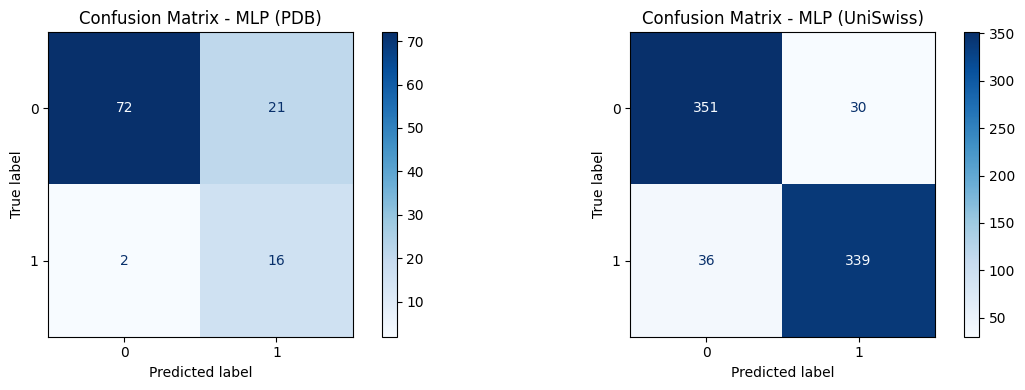

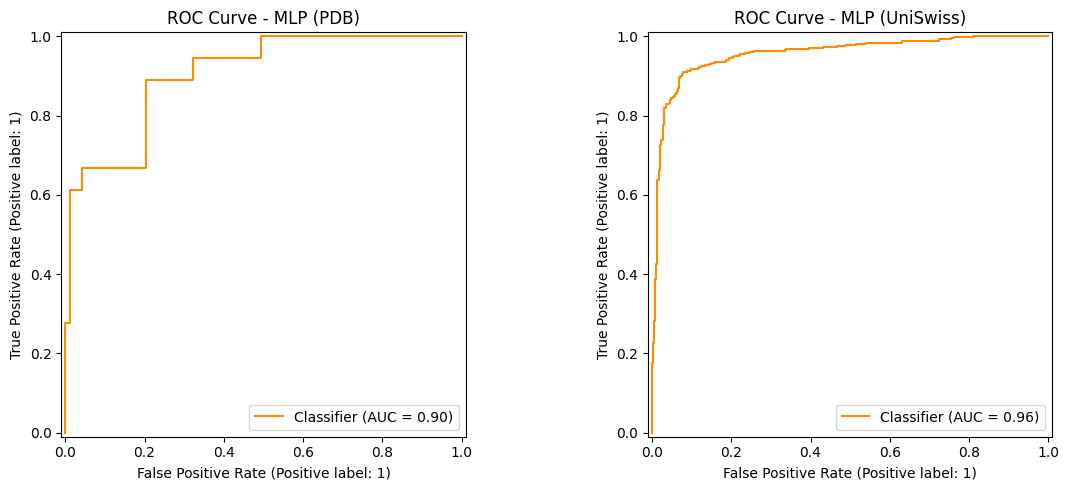

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

###  tes 2 (0.673/0.914)
dropout model pdb dri 0.5 ke 0.3

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.3, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.2012 | Val F1: 0.8585
Epoch 20 | Train Loss: 0.0988 | Val F1: 0.8393
Epoch 30 | Train Loss: 0.0583 | Val F1: 0.8488
Early stopping at epoch 36
Epoch 10 | Train Loss: 0.1777 | Val F1: 0.8089
Epoch 20 | Train Loss: 0.1172 | Val F1: 0.8069
Epoch 30 | Train Loss: 0.0683 | Val F1: 0.8372
Epoch 40 | Train Loss: 0.0507 | Val F1: 0.8477
Epoch 50 | Train Loss: 0.0419 | Val F1: 0.8379
Epoch 60 | Train Loss: 0.0346 | Val F1: 0.8372
Early stopping at epoch 68



Evaluation for MLP on PDB dataset:
Accuracy:      0.748
Precision(M):  0.666
Recall(M):     0.782
F1 Macro:      0.673
F1 Weighted:   0.779
MCC:           0.433
Sensitivity:   0.782
Specificity:   0.731
ROC_AUC:       0.896

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.958     0.731     0.829        93
    Binding (1)      0.375     0.833     0.517        18

       accuracy                          0.748       111
      macro avg      0.666     0.782     0.673       111
   weighted avg      0.863     0.748     0.779       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.914
Precision(M):  0.914
Recall(M):     0.914
F1 Macro:      0.914
F1 Weighted:   0.914
MCC:           0.828
Sensitivity:   0.914
Specificity:   0.919
ROC_AUC:       0.957

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.911     0.919     0.915       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.747748         0.666373      0.782258  0.673255   
1   MLP  UniSwiss  0.914021         0.914062      0.913984  0.914009   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.778669     0.731183  0.433406  0.896057   
1     0.914017     0.918635  0.828047  0.957459   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

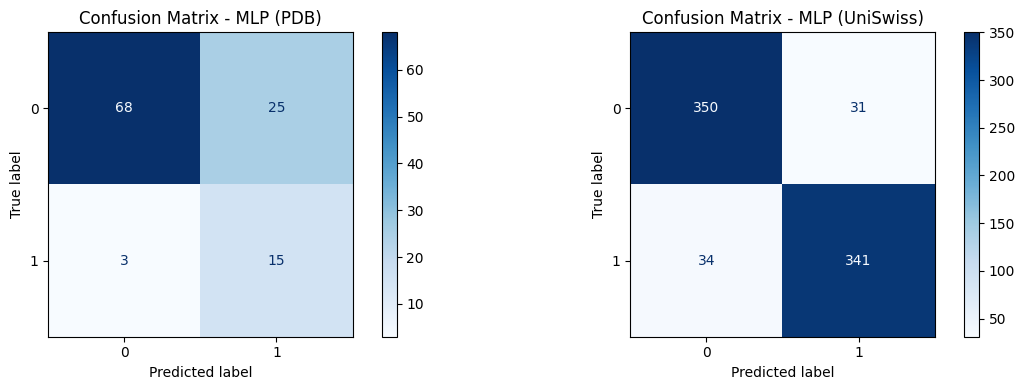

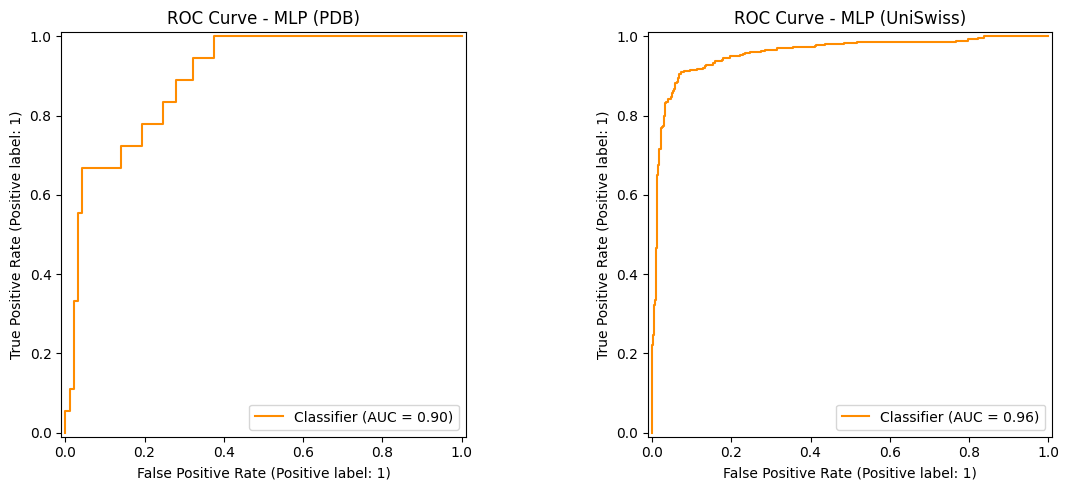

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 3 (0.690/0.918)
dropout model pdb dri 0.5 ke 0.2

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.2, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.1483 | Val F1: 0.8490
Epoch 20 | Train Loss: 0.0536 | Val F1: 0.8585
Epoch 30 | Train Loss: 0.0304 | Val F1: 0.8585
Early stopping at epoch 31
Epoch 10 | Train Loss: 0.1732 | Val F1: 0.7906
Epoch 20 | Train Loss: 0.0986 | Val F1: 0.7989
Early stopping at epoch 26



Evaluation for MLP on PDB dataset:
Accuracy:      0.766
Precision(M):  0.677
Recall(M):     0.793
F1 Macro:      0.690
F1 Weighted:   0.793
MCC:           0.455
Sensitivity:   0.793
Specificity:   0.753
ROC_AUC:       0.899

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.959     0.753     0.843        93
    Binding (1)      0.395     0.833     0.536        18

       accuracy                          0.766       111
      macro avg      0.677     0.793     0.690       111
   weighted avg      0.867     0.766     0.793       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.918
Precision(M):  0.918
Recall(M):     0.918
F1 Macro:      0.918
F1 Weighted:   0.918
MCC:           0.836
Sensitivity:   0.918
Specificity:   0.934
ROC_AUC:       0.957

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.906     0.934     0.920       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.765766         0.676820      0.793011  0.689544   
1   MLP  UniSwiss  0.917989         0.918491      0.917858  0.917943   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.793483     0.752688  0.455238  0.899044   
1     0.917958     0.934383  0.836349  0.957256   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

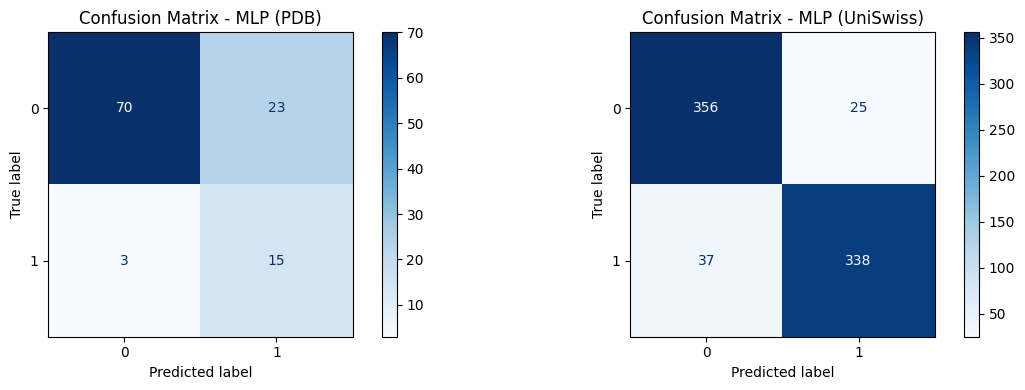

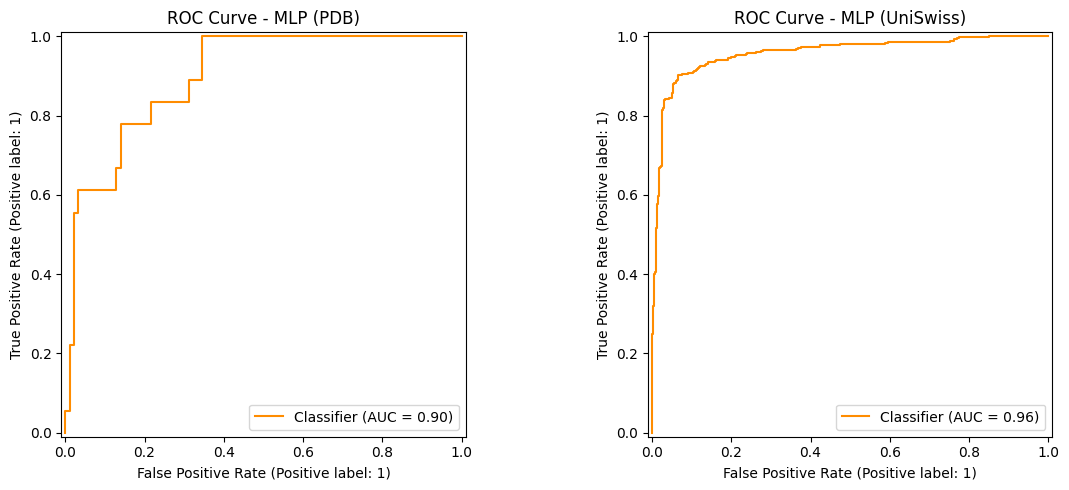

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 4 (0.706/0.903)
patience early stop pdb dari 15 ke 20

Epoch 10 | Train Loss: 0.3866 | Val F1: 0.7918
Epoch 20 | Train Loss: 0.1981 | Val F1: 0.8301
Epoch 30 | Train Loss: 0.1463 | Val F1: 0.8396
Epoch 40 | Train Loss: 0.1204 | Val F1: 0.8206
Early stopping at epoch 42
Epoch 10 | Train Loss: 0.1378 | Val F1: 0.8195
Epoch 20 | Train Loss: 0.0752 | Val F1: 0.7888
Epoch 30 | Train Loss: 0.0497 | Val F1: 0.8287
Early stopping at epoch 37

Evaluation for MLP on PDB dataset:
Accuracy:      0.784
Precision(M):  0.688
Recall(M):     0.804
F1 Macro:      0.706
F1 Weighted:   0.808
MCC:           0.478
Sensitivity:   0.804
Specificity:   0.774
ROC_AUC:       0.900

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.960     0.774     0.857        93
    Binding (1)      0.417     0.833     0.556        18

       accuracy                          0.784       111
      macro avg      0.688     0.804     0.706       111
   weighted avg      0.872     0.784     0.808       111


Evaluation for 

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.783784         0.688333      0.803763  0.706349   
1   MLP  UniSwiss  0.903439         0.903429      0.903444  0.903435   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.808237     0.774194  0.478367  0.899642   
1     0.903440     0.902887  0.806873  0.955822   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

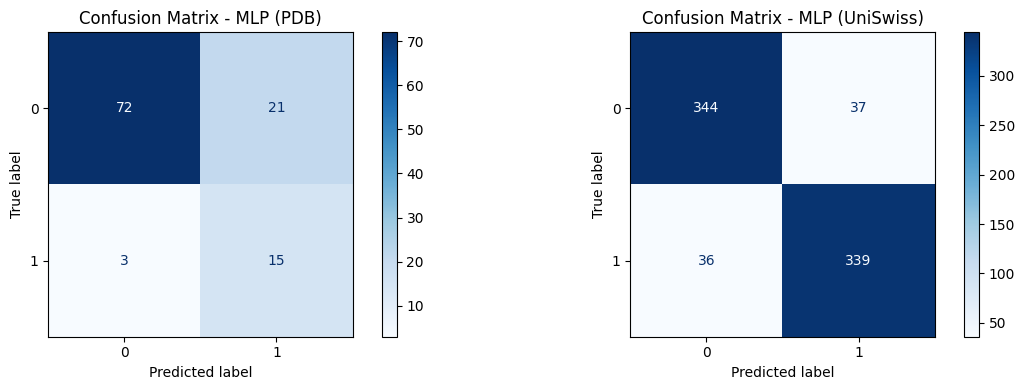

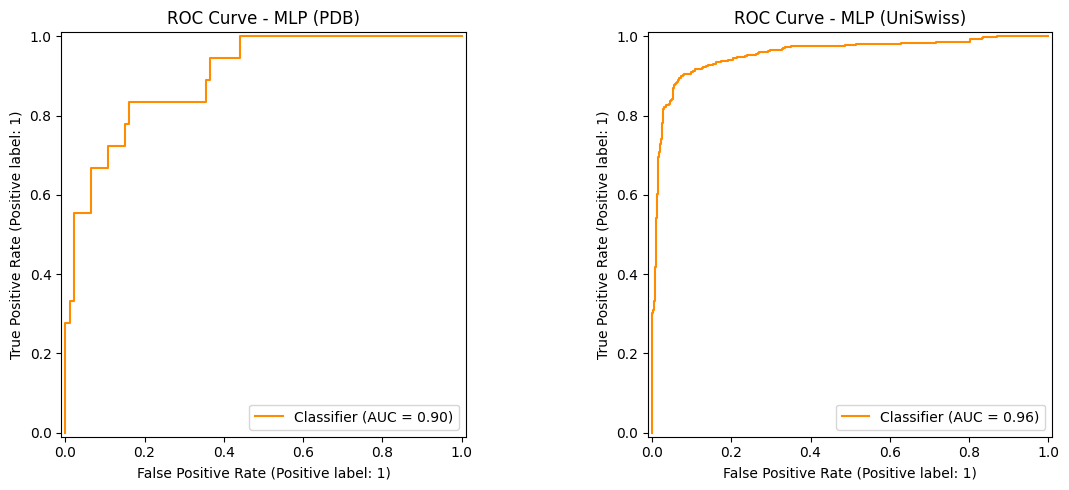

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## hidden_dim

### tes 5 (0.657/0.899)
hidden_dim pdb dari 256 jdi 512

Epoch 10 | Train Loss: 0.2345 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.0910 | Val F1: 0.8490
Early stopping at epoch 30
Epoch 10 | Train Loss: 0.1126 | Val F1: 0.8292
Epoch 20 | Train Loss: 0.0444 | Val F1: 0.7807
Early stopping at epoch 27

Evaluation for MLP on PDB dataset:
Accuracy:      0.730
Precision(M):  0.657
Recall(M):     0.772
F1 Macro:      0.657
F1 Weighted:   0.764
MCC:           0.413
Sensitivity:   0.772
Specificity:   0.710
ROC_AUC:       0.928

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.957     0.710     0.815        93
    Binding (1)      0.357     0.833     0.500        18

       accuracy                          0.730       111
      macro avg      0.657     0.772     0.657       111
   weighted avg      0.859     0.730     0.764       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.899
Precision(M):  0.900
Recall(M):     0.900
F1 Macro:      0.899
F1 Weighted:   0.899
MCC:       

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.729730         0.656832      0.771505  0.657407   
1   MLP  UniSwiss  0.899471         0.899528      0.899528  0.899471   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.763764     0.709677  0.412702  0.927718   
1     0.899471     0.892388  0.799055  0.954303   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

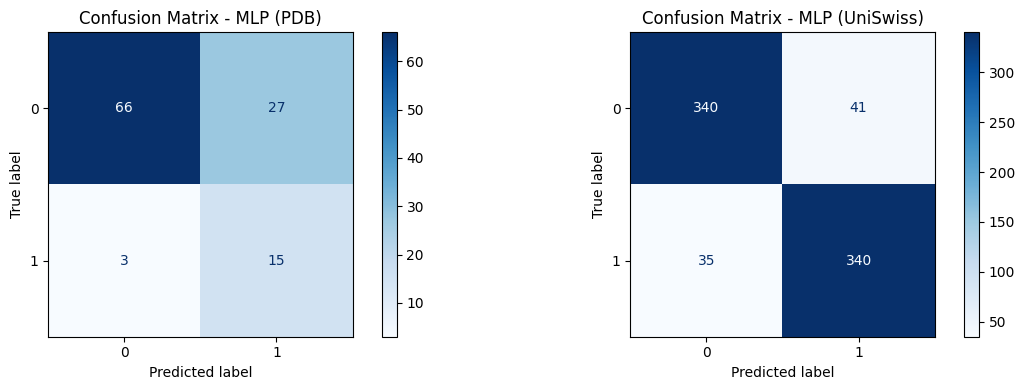

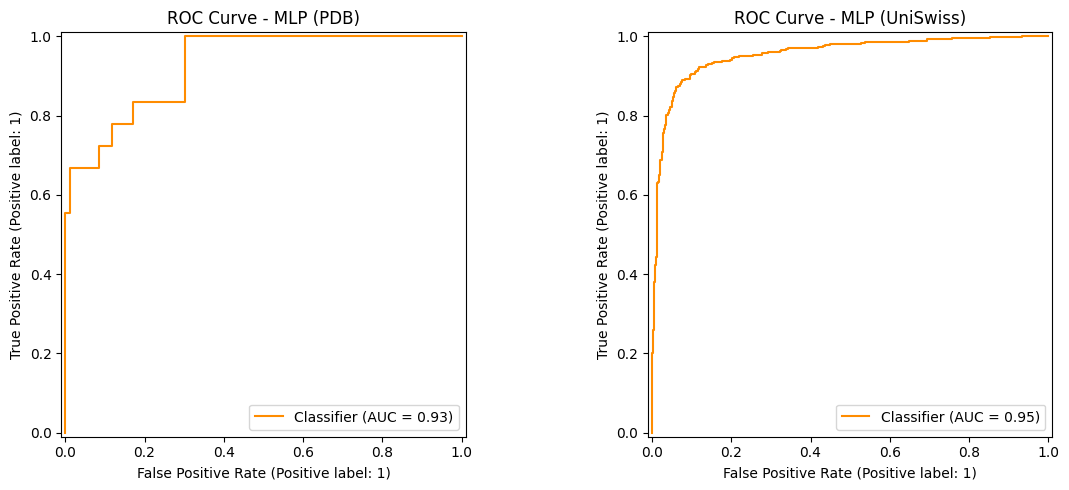

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=512, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=512, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 6 (0.664/0.897)
hidden_dim pdb dari 256 jdi 384

Epoch 10 | Train Loss: 0.3101 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.1505 | Val F1: 0.8585
Epoch 30 | Train Loss: 0.1083 | Val F1: 0.8491
Early stopping at epoch 40
Epoch 10 | Train Loss: 0.1199 | Val F1: 0.8089
Epoch 20 | Train Loss: 0.0588 | Val F1: 0.7898
Early stopping at epoch 27

Evaluation for MLP on PDB dataset:
Accuracy:      0.730
Precision(M):  0.667
Recall(M):     0.794
F1 Macro:      0.664
F1 Weighted:   0.764
MCC:           0.443
Sensitivity:   0.794
Specificity:   0.699
ROC_AUC:       0.918

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.970     0.699     0.812        93
    Binding (1)      0.364     0.889     0.516        18

       accuracy                          0.730       111
      macro avg      0.667     0.794     0.664       111
   weighted avg      0.872     0.730     0.764       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.897
Precision(M):  0.897
Recall(M):     0.897
F1 Mac

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.729730         0.666893      0.793907  0.664315   
1   MLP  UniSwiss  0.896825         0.896947      0.896903  0.896825   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.764440     0.698925  0.442949  0.917563   
1     0.896823     0.887139  0.793850  0.954891   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

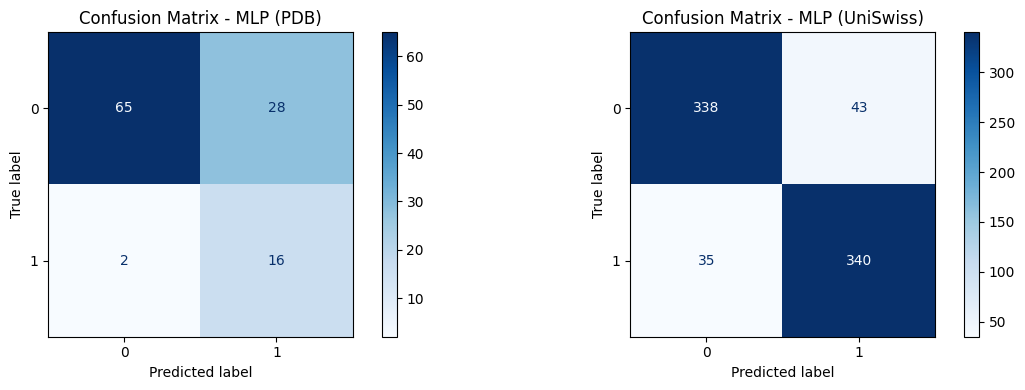

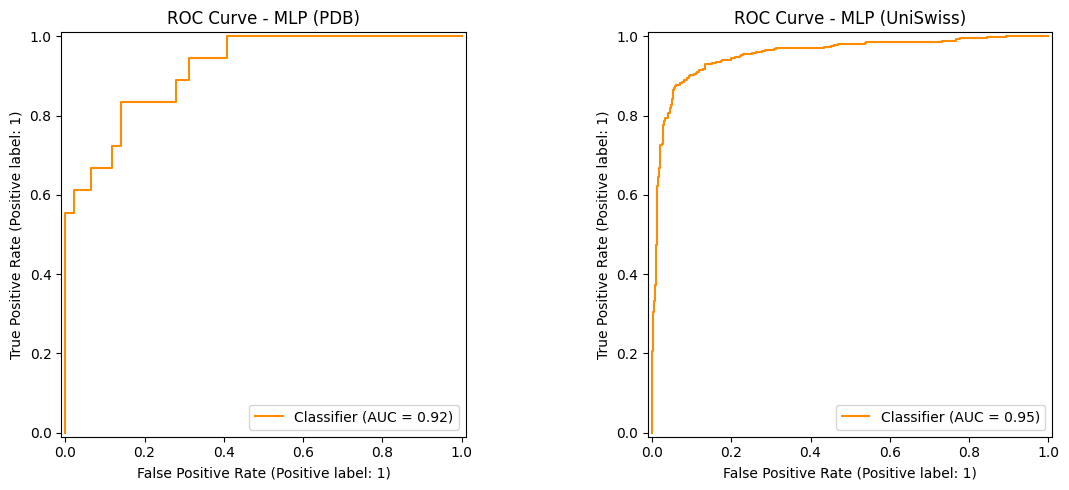

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## learning rate

### tes 7 (0.673/0.902)
lr keduanya dari 1e-4 jdi 2e-4

Epoch 10 | Train Loss: 0.2314 | Val F1: 0.8488
Epoch 20 | Train Loss: 0.0883 | Val F1: 0.8302
Epoch 30 | Train Loss: 0.0572 | Val F1: 0.8395
Early stopping at epoch 39
Epoch 10 | Train Loss: 0.1196 | Val F1: 0.8280
Epoch 20 | Train Loss: 0.0638 | Val F1: 0.8385
Epoch 30 | Train Loss: 0.0357 | Val F1: 0.8299
Epoch 40 | Train Loss: 0.0293 | Val F1: 0.8102
Early stopping at epoch 42

Evaluation for MLP on PDB dataset:
Accuracy:      0.748
Precision(M):  0.666
Recall(M):     0.782
F1 Macro:      0.673
F1 Weighted:   0.779
MCC:           0.433
Sensitivity:   0.782
Specificity:   0.731
ROC_AUC:       0.891

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.958     0.731     0.829        93
    Binding (1)      0.375     0.833     0.517        18

       accuracy                          0.748       111
      macro avg      0.666     0.782     0.673       111
   weighted avg      0.863     0.748     0.779       111


Evaluation for 

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.747748         0.666373      0.782258  0.673255   
1   MLP  UniSwiss  0.902116         0.902239      0.902194  0.902116   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.778669     0.731183  0.433406  0.891278   
1     0.902114     0.892388  0.804433  0.956966   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

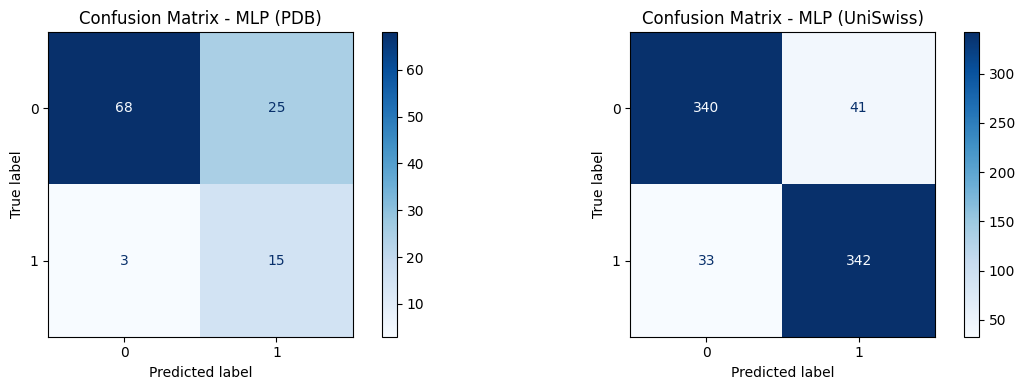

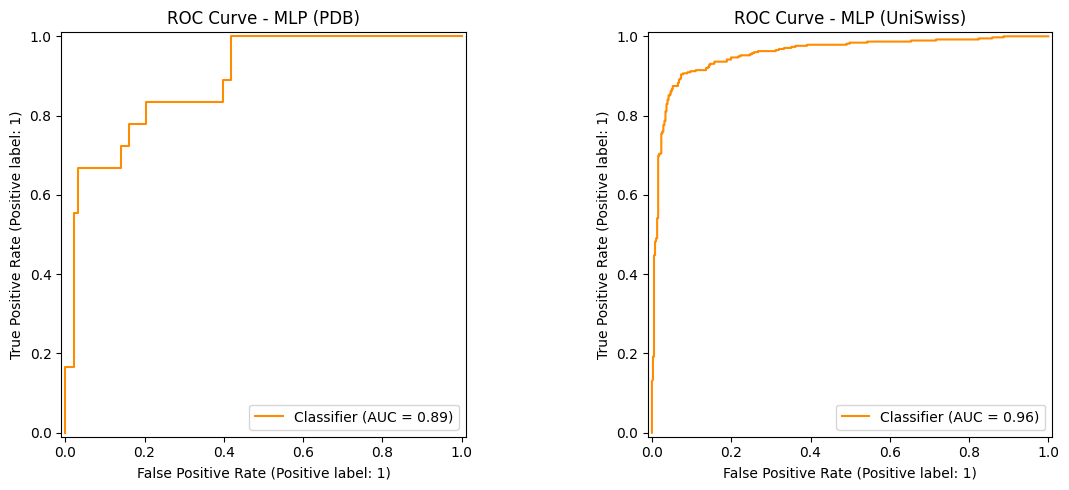

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=2e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=2e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 8 (0.673/0.903)
lr keduanya dari 1e-4 jdi 7e-5

Epoch 10 | Train Loss: 0.3848 | Val F1: 0.7925
Epoch 20 | Train Loss: 0.1952 | Val F1: 0.8302
Epoch 30 | Train Loss: 0.1434 | Val F1: 0.8396
Epoch 40 | Train Loss: 0.1194 | Val F1: 0.8396
Epoch 50 | Train Loss: 0.1210 | Val F1: 0.8396
Epoch 60 | Train Loss: 0.1104 | Val F1: 0.8396
Early stopping at epoch 63
Epoch 10 | Train Loss: 0.1353 | Val F1: 0.8280
Epoch 20 | Train Loss: 0.0629 | Val F1: 0.8188
Epoch 30 | Train Loss: 0.0427 | Val F1: 0.8477
Early stopping at epoch 32

Evaluation for MLP on PDB dataset:
Accuracy:      0.739
Precision(M):  0.671
Recall(M):     0.799
F1 Macro:      0.672
F1 Weighted:   0.772
MCC:           0.453
Sensitivity:   0.799
Specificity:   0.710
ROC_AUC:       0.916

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.971     0.710     0.820        93
    Binding (1)      0.372     0.889     0.525        18

       accuracy                          0.739       111
      macro avg      0.671     0.799 

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.738739         0.671341      0.799283  0.672233   
1   MLP  UniSwiss  0.903439         0.903429      0.903444  0.903435   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.771992     0.709677  0.452899  0.915771   
1     0.903440     0.902887  0.806873  0.956087   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

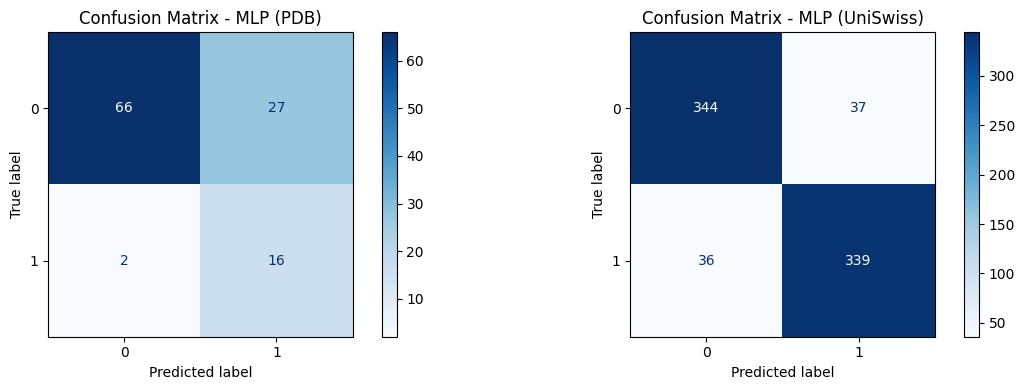

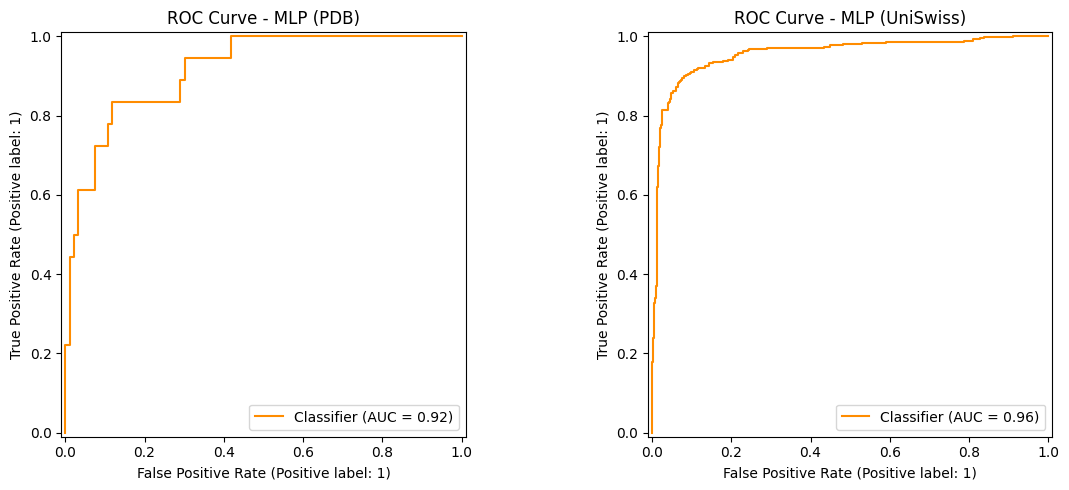

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=7e-5,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=7e-5,
    weight_decay=1e-4,
    patience=20,
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 9 (0.656/0.910)
weight decay keduanya dari 1e-4 jdi 1e-3

Epoch 10 | Train Loss: 0.3923 | Val F1: 0.8207
Epoch 20 | Train Loss: 0.1910 | Val F1: 0.8301
Early stopping at epoch 28
Epoch 10 | Train Loss: 0.1416 | Val F1: 0.8160
Epoch 20 | Train Loss: 0.0719 | Val F1: 0.7978
Early stopping at epoch 27

Evaluation for MLP on PDB dataset:
Accuracy:      0.721
Precision(M):  0.663
Recall(M):     0.789
F1 Macro:      0.656
F1 Weighted:   0.757
MCC:           0.433
Sensitivity:   0.789
Specificity:   0.688
ROC_AUC:       0.914

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.970     0.688     0.805        93
    Binding (1)      0.356     0.889     0.508        18

       accuracy                          0.721       111
      macro avg      0.663     0.789     0.656       111
   weighted avg      0.870     0.721     0.757       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.910
Precision(M):  0.910
Recall(M):     0.910
F1 Macro:      0.910
F1 Weighted:   0.910
MCC:       

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.720721         0.662626      0.788530  0.656484   
1   MLP  UniSwiss  0.910053         0.910045      0.910068  0.910050   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.756854     0.688172  0.433233  0.913978   
1     0.910054     0.908136  0.820114  0.953848   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

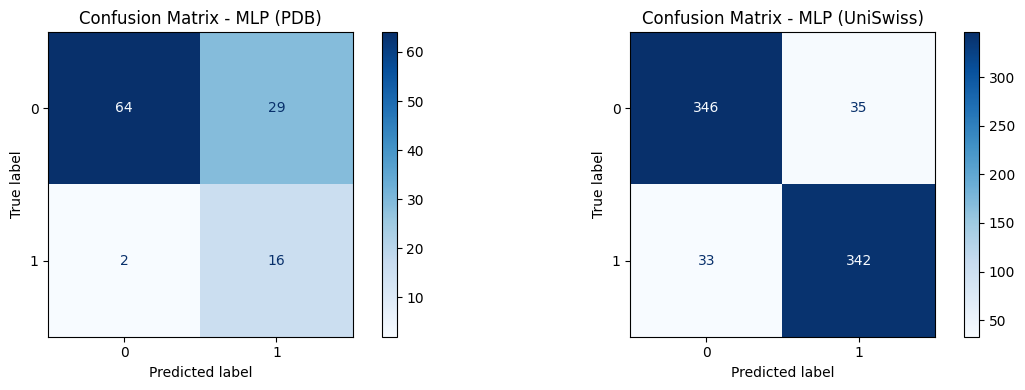

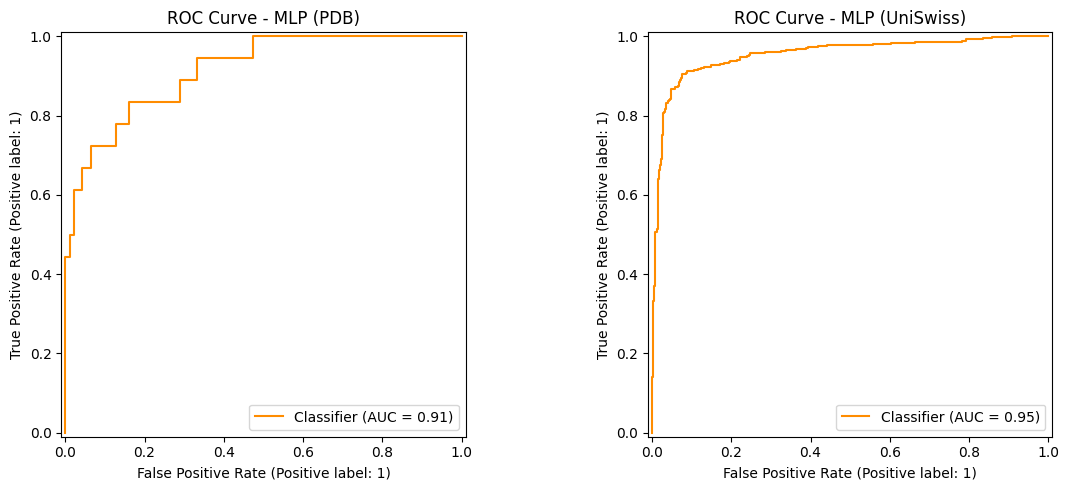

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-3,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-3,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 10 (0.673/0.915)
batch size keduanya dari 32 jdi 64

Epoch 10 | Train Loss: 0.4348 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.2726 | Val F1: 0.8396
Early stopping at epoch 28
Epoch 10 | Train Loss: 0.1385 | Val F1: 0.8171
Epoch 20 | Train Loss: 0.0790 | Val F1: 0.8188
Epoch 30 | Train Loss: 0.0467 | Val F1: 0.8188
Early stopping at epoch 36

Evaluation for MLP on PDB dataset:
Accuracy:      0.748
Precision(M):  0.666
Recall(M):     0.782
F1 Macro:      0.673
F1 Weighted:   0.779
MCC:           0.433
Sensitivity:   0.782
Specificity:   0.731
ROC_AUC:       0.906

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.958     0.731     0.829        93
    Binding (1)      0.375     0.833     0.517        18

       accuracy                          0.748       111
      macro avg      0.666     0.782     0.673       111
   weighted avg      0.863     0.748     0.779       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.915
Precision(M):  0.915
Recall(M):     0.915
F1 Mac

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.747748         0.666373      0.782258  0.673255   
1   MLP  UniSwiss  0.915344         0.915485      0.915276  0.915323   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.778669     0.731183  0.433406  0.905615   
1     0.915333     0.923885  0.830761  0.955787   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

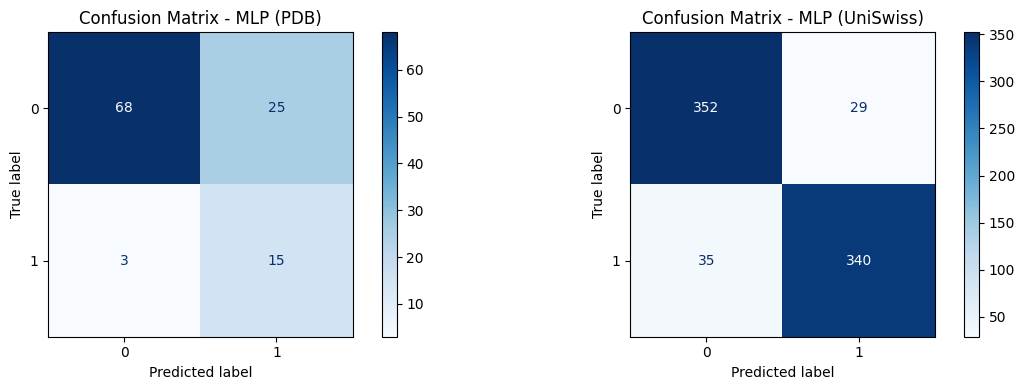

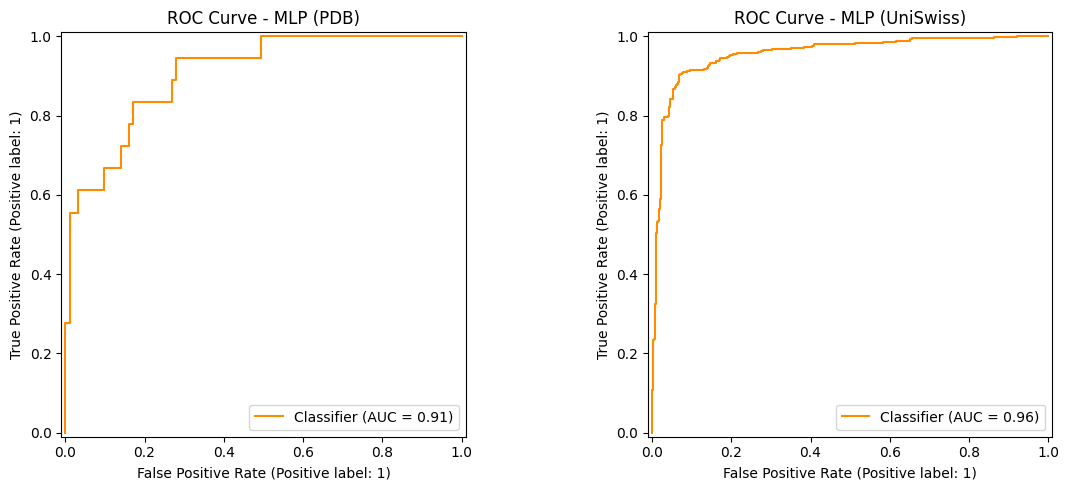

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=64,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=64,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

# Hyperparameter Tuning V2
tuning hyperparameter dg konsep di Try 3, train_model_v3, ComplexMLP_v2

## dropout

### tes 1 (0.665/0.909)
dropout model pdb dri 0.5 ke 0.4

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.2787 | Val F1: 0.8207
Epoch 20 | Train Loss: 0.1559 | Val F1: 0.8207
Early stopping at epoch 23
Epoch 10 | Train Loss: 0.1358 | Val F1: 0.8385
Epoch 20 | Train Loss: 0.0672 | Val F1: 0.8004
Early stopping at epoch 30



Evaluation for MLP on PDB dataset:
Accuracy:      0.739
Precision(M):  0.661
Recall(M):     0.777
F1 Macro:      0.665
F1 Weighted:   0.771
MCC:           0.423
Sensitivity:   0.777
Specificity:   0.720
ROC_AUC:       0.891

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.957     0.720     0.822        93
    Binding (1)      0.366     0.833     0.508        18

       accuracy                          0.739       111
      macro avg      0.661     0.777     0.665       111
   weighted avg      0.861     0.739     0.771       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.909
Precision(M):  0.909
Recall(M):     0.909
F1 Macro:      0.909
F1 Weighted:   0.909
MCC:           0.817
Sensitivity:   0.909
Specificity:   0.911
ROC_AUC:       0.955

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.908     0.911     0.910       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.738739         0.661498      0.776882  0.665280   
1   MLP  UniSwiss  0.908730         0.908734      0.908714  0.908722   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.771230     0.720430  0.422923  0.891278   
1     0.908729     0.910761  0.817448  0.955101   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

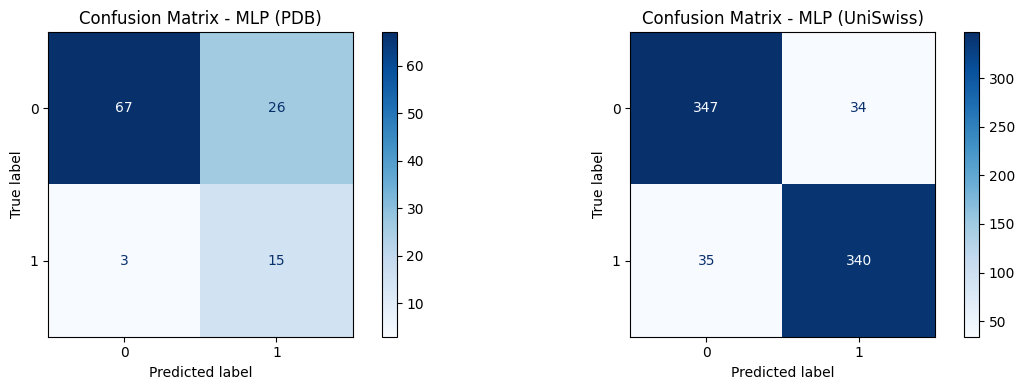

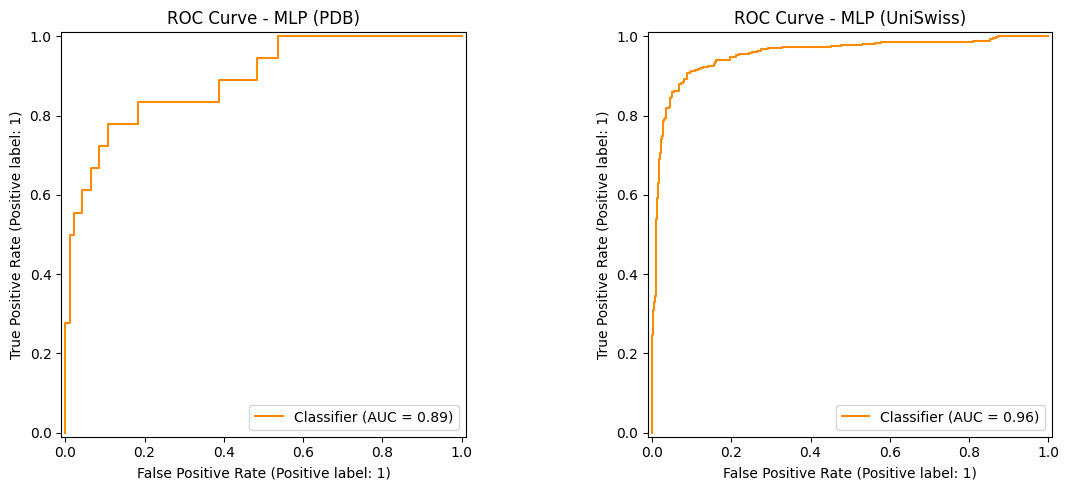

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

###  tes 2 (0.672/0.907)
dropout model pdb dri 0.5 ke 0.3

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.3, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.2042 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.0946 | Val F1: 0.8395
Epoch 30 | Train Loss: 0.0654 | Val F1: 0.8584
Epoch 40 | Train Loss: 0.0558 | Val F1: 0.8584
Early stopping at epoch 45
Epoch 10 | Train Loss: 0.1721 | Val F1: 0.8080
Epoch 20 | Train Loss: 0.1041 | Val F1: 0.8080
Epoch 30 | Train Loss: 0.0659 | Val F1: 0.8102
Epoch 40 | Train Loss: 0.0429 | Val F1: 0.8379
Epoch 50 | Train Loss: 0.0324 | Val F1: 0.8188
Early stopping at epoch 52



Evaluation for MLP on PDB dataset:
Accuracy:      0.739
Precision(M):  0.671
Recall(M):     0.799
F1 Macro:      0.672
F1 Weighted:   0.772
MCC:           0.453
Sensitivity:   0.799
Specificity:   0.710
ROC_AUC:       0.907

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.971     0.710     0.820        93
    Binding (1)      0.372     0.889     0.525        18

       accuracy                          0.739       111
      macro avg      0.671     0.799     0.672       111
   weighted avg      0.874     0.739     0.772       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.907
Precision(M):  0.908
Recall(M):     0.908
F1 Macro:      0.907
F1 Weighted:   0.907
MCC:           0.815
Sensitivity:   0.908
Specificity:   0.890
ROC_AUC:       0.958

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.924     0.890     0.906       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.738739         0.671341      0.799283  0.672233   
1   MLP  UniSwiss  0.907407         0.907868      0.907549  0.907397   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.771992     0.709677  0.452899  0.907407   
1     0.907389     0.889764  0.815417  0.958453   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

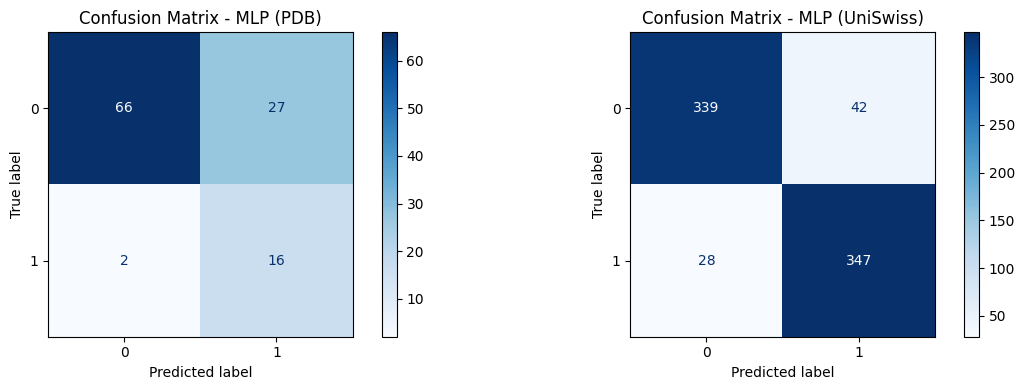

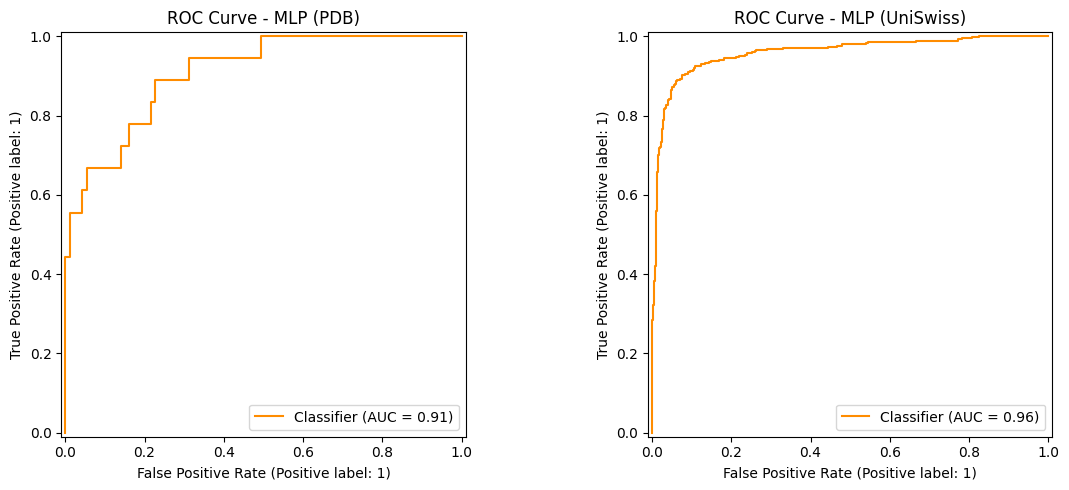

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 3 0.731/0.913)
dropout model pdb dri 0.5 ke 0.2

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.2, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)


Epoch 10 | Train Loss: 0.1563 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.0715 | Val F1: 0.8491
Epoch 30 | Train Loss: 0.0507 | Val F1: 0.8395
Early stopping at epoch 34
Epoch 10 | Train Loss: 0.1767 | Val F1: 0.8354
Epoch 20 | Train Loss: 0.0927 | Val F1: 0.8096
Epoch 30 | Train Loss: 0.0626 | Val F1: 0.8096
Early stopping at epoch 38



Evaluation for MLP on PDB dataset:
Accuracy:      0.802
Precision(M):  0.709
Recall(M):     0.837
F1 Macro:      0.731
F1 Weighted:   0.824
MCC:           0.531
Sensitivity:   0.837
Specificity:   0.785
ROC_AUC:       0.904

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.973     0.785     0.869        93
    Binding (1)      0.444     0.889     0.593        18

       accuracy                          0.802       111
      macro avg      0.709     0.837     0.731       111
   weighted avg      0.888     0.802     0.824       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.913
Precision(M):  0.913
Recall(M):     0.913
F1 Macro:      0.913
F1 Weighted:   0.913
MCC:           0.825
Sensitivity:   0.913
Specificity:   0.916
ROC_AUC:       0.958

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.911     0.916     0.914       381
    Binding (1)      0.

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.801802         0.708889      0.836918  0.730820   
1   MLP  UniSwiss  0.912698         0.912718      0.912672  0.912689   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.824217     0.784946  0.530578  0.903823   
1     0.912696     0.916010  0.825390  0.958033   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

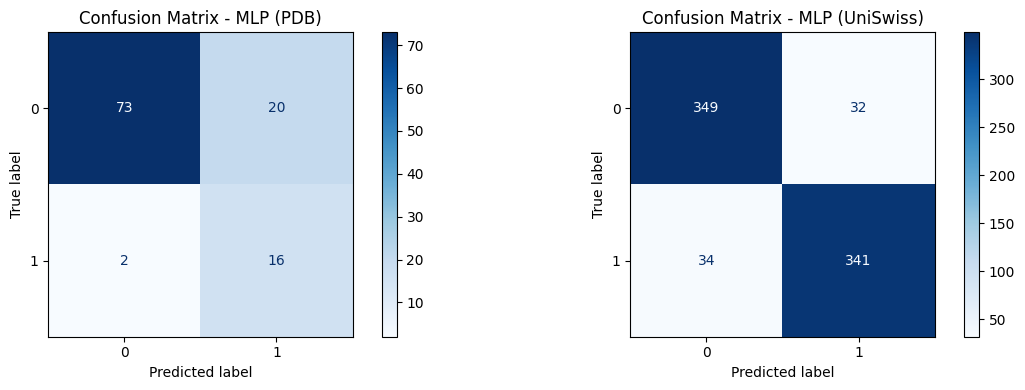

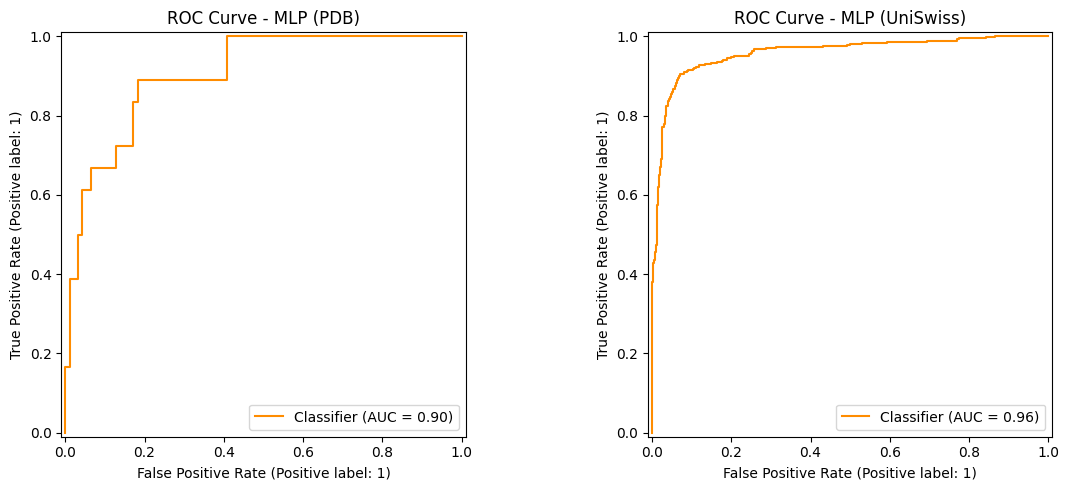

In [ ]:
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 4 (0.622/0.911)
patience early stop pdb dari 15 ke 20

Epoch 10 | Train Loss: 0.3834 | Val F1: 0.8302
Epoch 20 | Train Loss: 0.2141 | Val F1: 0.8299
Epoch 30 | Train Loss: 0.1729 | Val F1: 0.8296
Early stopping at epoch 39
Epoch 10 | Train Loss: 0.1365 | Val F1: 0.8464
Epoch 20 | Train Loss: 0.0835 | Val F1: 0.8004
Epoch 30 | Train Loss: 0.0416 | Val F1: 0.8287
Early stopping at epoch 34

Evaluation for MLP on PDB dataset:
Accuracy:      0.667
Precision(M):  0.664
Recall(M):     0.801
F1 Macro:      0.622
F1 Weighted:   0.710
MCC:           0.444
Sensitivity:   0.801
Specificity:   0.602
ROC_AUC:       0.907

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      1.000     0.602     0.752        93
    Binding (1)      0.327     1.000     0.493        18

       accuracy                          0.667       111
      macro avg      0.664     0.801     0.622       111
   weighted avg      0.891     0.667     0.710       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.911
P

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.666667         0.663636      0.801075  0.622414   
1   MLP  UniSwiss  0.911376         0.911380      0.911360  0.911368   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.709755     0.602151  0.443923  0.906810   
1     0.911375     0.913386  0.822739  0.955913   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

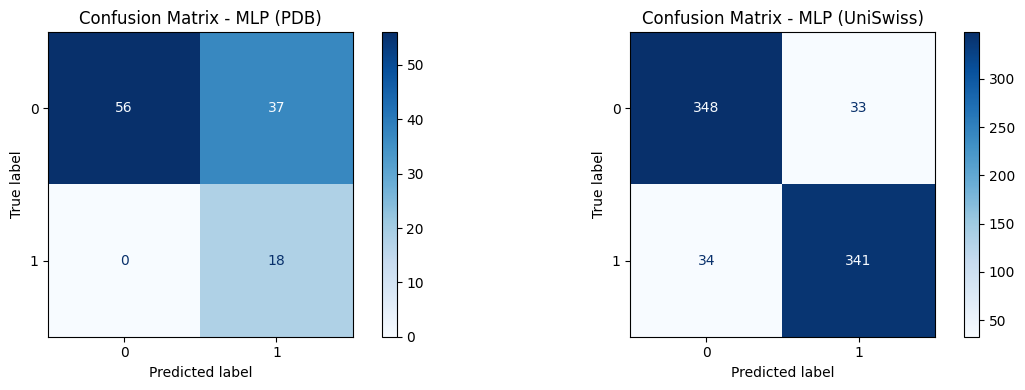

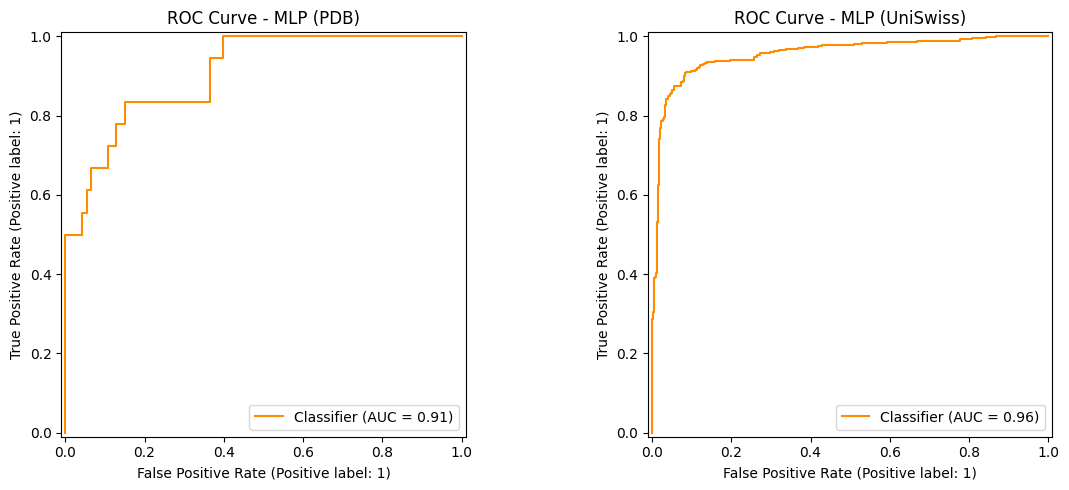

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## hidden_dim

### tes 5 (0.698/0.910)
hidden_dim pdb dari 256 jdi 512

Epoch 10 | Train Loss: 0.2421 | Val F1: 0.8490
Epoch 20 | Train Loss: 0.1083 | Val F1: 0.8396
Early stopping at epoch 24
Epoch 10 | Train Loss: 0.1094 | Val F1: 0.8287
Epoch 20 | Train Loss: 0.0526 | Val F1: 0.8287
Epoch 30 | Train Loss: 0.0270 | Val F1: 0.7997
Early stopping at epoch 33

Evaluation for MLP on PDB dataset:
Accuracy:      0.775
Precision(M):  0.682
Recall(M):     0.798
F1 Macro:      0.698
F1 Weighted:   0.801
MCC:           0.467
Sensitivity:   0.798
Specificity:   0.763
ROC_AUC:       0.913

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.959     0.763     0.850        93
    Binding (1)      0.405     0.833     0.545        18

       accuracy                          0.775       111
      macro avg      0.682     0.798     0.698       111
   weighted avg      0.870     0.775     0.801       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.910
Precision(M):  0.910
Recall(M):     0.910
F1 Mac

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.774775         0.682432      0.798387  0.697877   
1   MLP  UniSwiss  0.910053         0.910191      0.909984  0.910030   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.800865     0.763441  0.466628  0.913381   
1     0.910042     0.918635  0.820175  0.953487   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

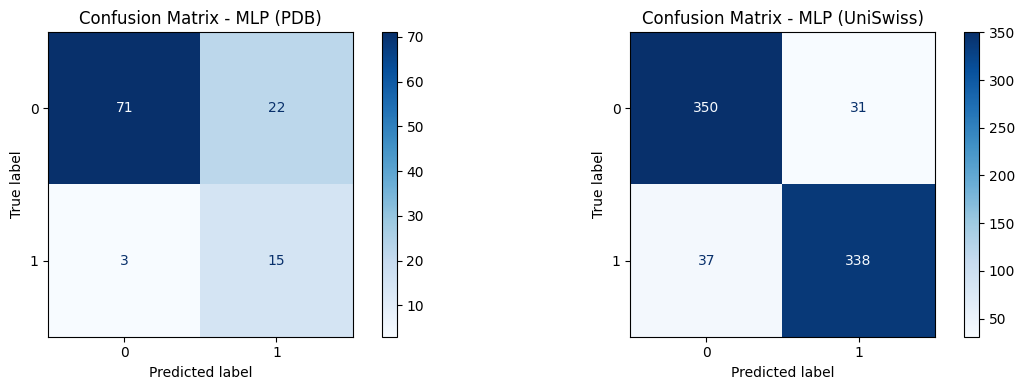

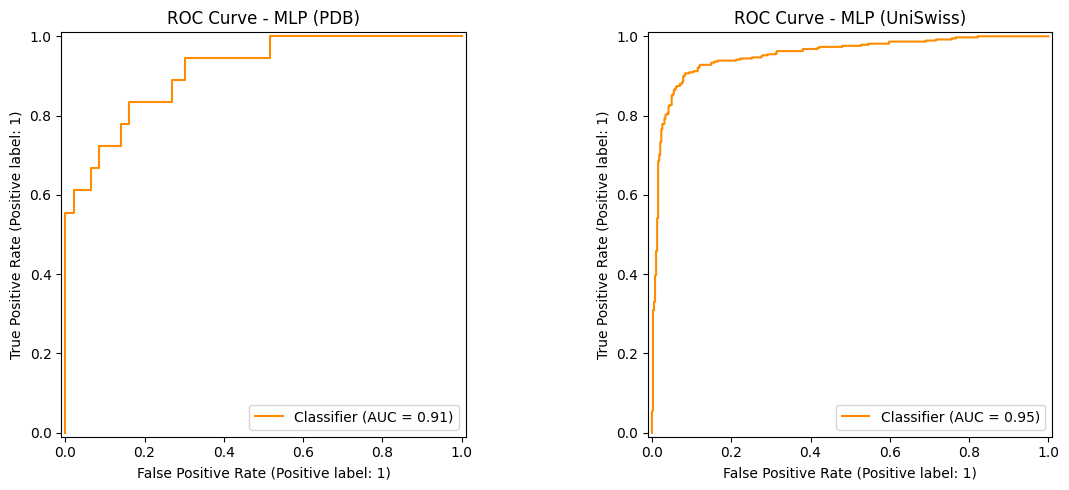

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=512, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=512, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 6 (0.656/0.902)
hidden_dim pdb dari 256 jdi 384

Epoch 10 | Train Loss: 0.2932 | Val F1: 0.8301
Epoch 20 | Train Loss: 0.1657 | Val F1: 0.8302
Epoch 30 | Train Loss: 0.1175 | Val F1: 0.8490
Early stopping at epoch 40
Epoch 10 | Train Loss: 0.1266 | Val F1: 0.8180
Epoch 20 | Train Loss: 0.0625 | Val F1: 0.7807
Epoch 30 | Train Loss: 0.0358 | Val F1: 0.7989
Early stopping at epoch 37

Evaluation for MLP on PDB dataset:
Accuracy:      0.721
Precision(M):  0.663
Recall(M):     0.789
F1 Macro:      0.656
F1 Weighted:   0.757
MCC:           0.433
Sensitivity:   0.789
Specificity:   0.688
ROC_AUC:       0.912

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.970     0.688     0.805        93
    Binding (1)      0.356     0.889     0.508        18

       accuracy                          0.721       111
      macro avg      0.663     0.789     0.656       111
   weighted avg      0.870     0.721     0.757       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.902
P

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.720721         0.662626      0.788530  0.656484   
1   MLP  UniSwiss  0.902116         0.902181      0.902068  0.902099   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.756854     0.688172  0.433233  0.911589   
1     0.902110     0.908136  0.804249  0.953064   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

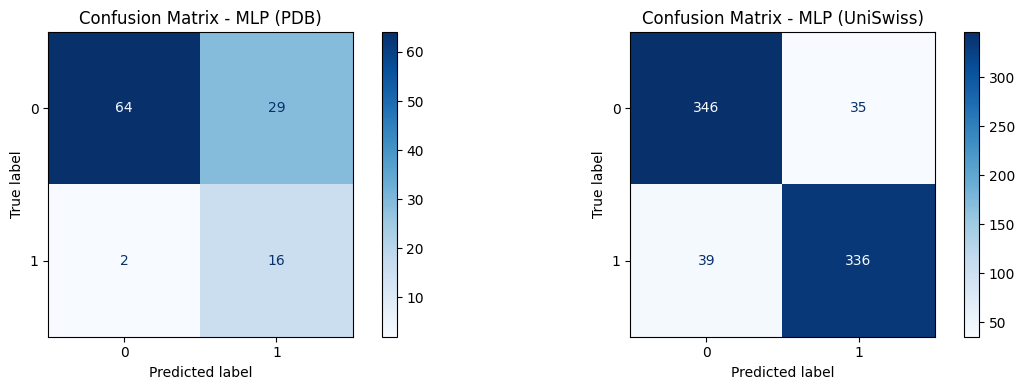

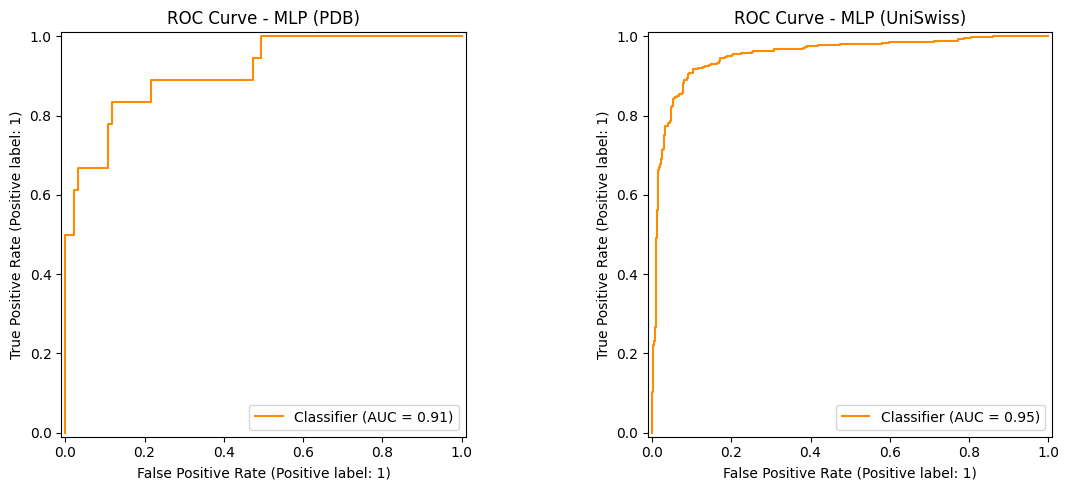

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4, #beda dg pdb
    weight_decay=1e-4, #beda dg pdb
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## learning rate

### tes 7 (0.695/0.905)
lr keduanya dari 1e-4 jdi 2e-4

Epoch 10 | Train Loss: 0.2519 | Val F1: 0.8396
Epoch 20 | Train Loss: 0.0897 | Val F1: 0.8207
Epoch 30 | Train Loss: 0.0542 | Val F1: 0.8301
Early stopping at epoch 36
Epoch 10 | Train Loss: 0.1285 | Val F1: 0.8080
Epoch 20 | Train Loss: 0.0726 | Val F1: 0.8379
Epoch 30 | Train Loss: 0.0305 | Val F1: 0.8292
Early stopping at epoch 35

Evaluation for MLP on PDB dataset:
Accuracy:      0.757
Precision(M):  0.690
Recall(M):     0.832
F1 Macro:      0.695
F1 Weighted:   0.788
MCC:           0.503
Sensitivity:   0.832
Specificity:   0.720
ROC_AUC:       0.916

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.985     0.720     0.832        93
    Binding (1)      0.395     0.944     0.557        18

       accuracy                          0.757       111
      macro avg      0.690     0.832     0.695       111
   weighted avg      0.890     0.757     0.788       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.905
P

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.756757         0.690321      0.832437  0.694838   
1   MLP  UniSwiss  0.904762         0.904974      0.904861  0.904759   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.787716     0.720430  0.503070  0.916368   
1     0.904755     0.892388  0.809835  0.957253   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

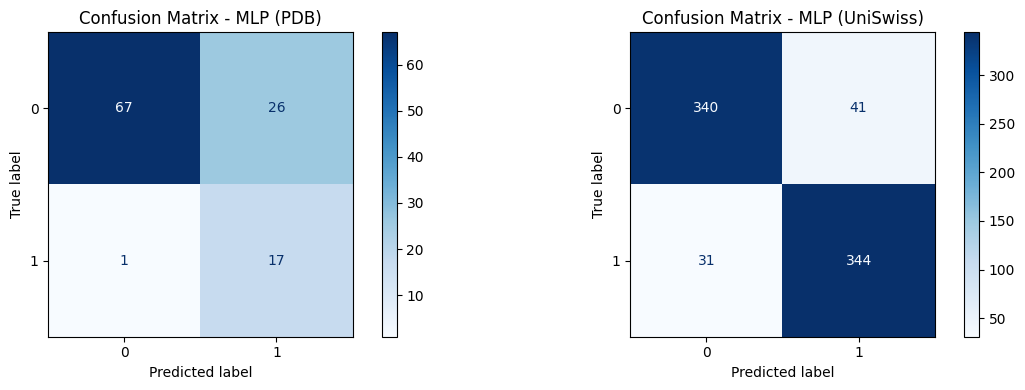

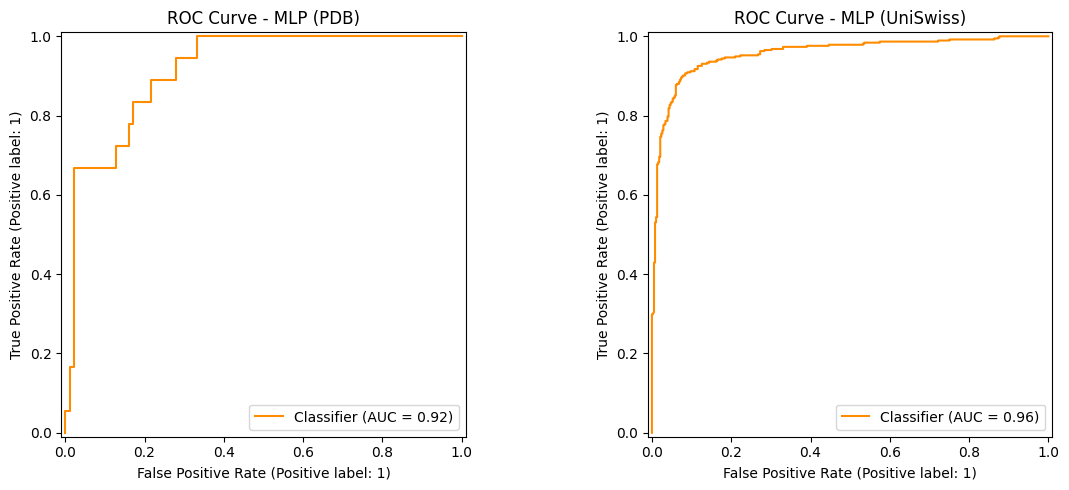

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=2e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=2e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

### tes 8 (0.699/0.899)
lr keduanya dari 1e-4 jdi 7e-5

Epoch 10 | Train Loss: 0.3901 | Val F1: 0.8014
Epoch 20 | Train Loss: 0.2009 | Val F1: 0.8393
Epoch 30 | Train Loss: 0.1049 | Val F1: 0.8393
Epoch 40 | Train Loss: 0.0832 | Val F1: 0.8296
Early stopping at epoch 42
Epoch 10 | Train Loss: 0.1384 | Val F1: 0.8667
Epoch 20 | Train Loss: 0.0745 | Val F1: 0.8372
Epoch 30 | Train Loss: 0.0420 | Val F1: 0.8195
Epoch 40 | Train Loss: 0.0289 | Val F1: 0.8584
Epoch 50 | Train Loss: 0.0274 | Val F1: 0.8677
Epoch 60 | Train Loss: 0.0244 | Val F1: 0.7989
Early stopping at epoch 64

Evaluation for MLP on PDB dataset:
Accuracy:      0.784
Precision(M):  0.680
Recall(M):     0.781
F1 Macro:      0.699
F1 Weighted:   0.807
MCC:           0.450
Sensitivity:   0.781
Specificity:   0.785
ROC_AUC:       0.888

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.948     0.785     0.859        93
    Binding (1)      0.412     0.778     0.538        18

       accuracy                          0.784 

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.783784         0.679908      0.781362  0.698643   
1   MLP  UniSwiss  0.899471         0.899488      0.899444  0.899460   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.806873     0.784946  0.449975  0.887694   
1     0.899468     0.902887  0.798932  0.955577   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

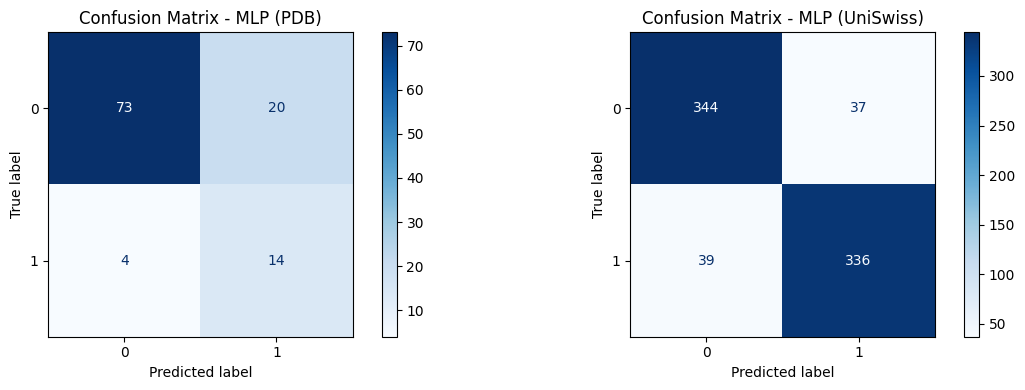

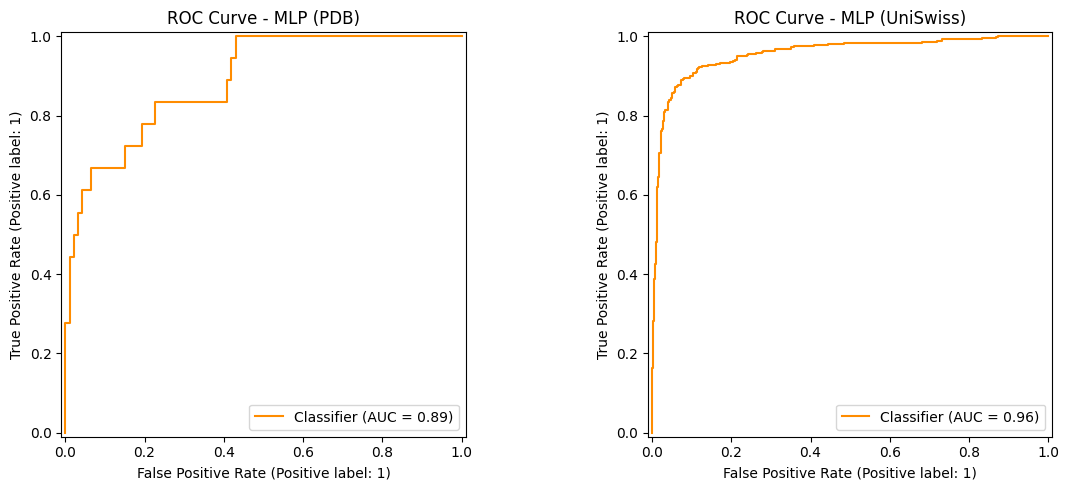

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=384, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=7e-5,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=7e-5,
    weight_decay=1e-4,
    patience=20,
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 9 (0.706/0.911)
weight decay keduanya dari 1e-4 jdi 1e-3

Epoch 10 | Train Loss: 0.3920 | Val F1: 0.8207
Epoch 20 | Train Loss: 0.1905 | Val F1: 0.8486
Epoch 30 | Train Loss: 0.1248 | Val F1: 0.8584
Early stopping at epoch 32
Epoch 10 | Train Loss: 0.1378 | Val F1: 0.8188
Epoch 20 | Train Loss: 0.0664 | Val F1: 0.8662
Epoch 30 | Train Loss: 0.0458 | Val F1: 0.8477
Early stopping at epoch 38

Evaluation for MLP on PDB dataset:
Accuracy:      0.784
Precision(M):  0.688
Recall(M):     0.804
F1 Macro:      0.706
F1 Weighted:   0.808
MCC:           0.478
Sensitivity:   0.804
Specificity:   0.774
ROC_AUC:       0.906

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.960     0.774     0.857        93
    Binding (1)      0.417     0.833     0.556        18

       accuracy                          0.784       111
      macro avg      0.688     0.804     0.706       111
   weighted avg      0.872     0.784     0.808       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.911
P

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.783784         0.688333      0.803763  0.706349   
1   MLP  UniSwiss  0.911376         0.911376      0.911402  0.911374   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.808237     0.774194  0.478367  0.906213   
1     0.911377     0.908136  0.822777  0.955241   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

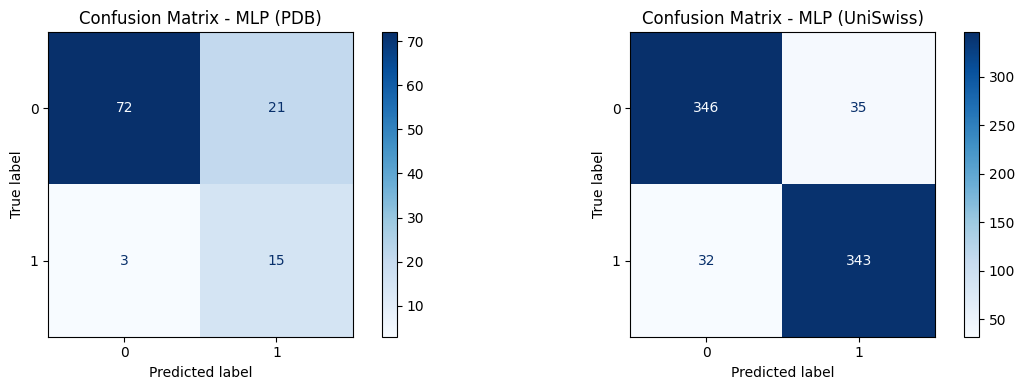

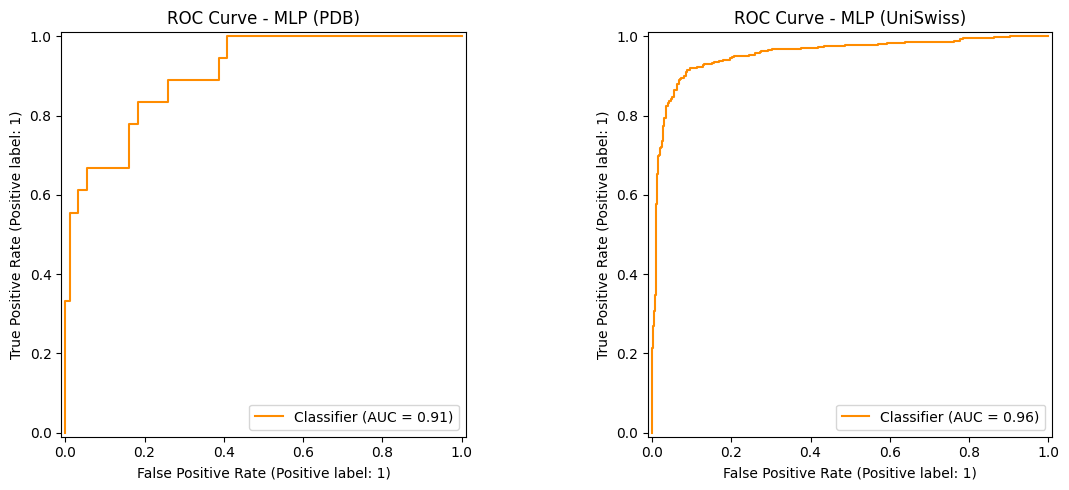

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-3,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-3,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

## tes 10 (0.665/0.907)
batch size keduanya dari 32 jdi 64

Epoch 10 | Train Loss: 0.4684 | Val F1: 0.7733
Epoch 20 | Train Loss: 0.2772 | Val F1: 0.8010
Early stopping at epoch 29
Epoch 10 | Train Loss: 0.1531 | Val F1: 0.7786
Epoch 20 | Train Loss: 0.0664 | Val F1: 0.7716
Early stopping at epoch 27

Evaluation for MLP on PDB dataset:
Accuracy:      0.739
Precision(M):  0.661
Recall(M):     0.777
F1 Macro:      0.665
F1 Weighted:   0.771
MCC:           0.423
Sensitivity:   0.777
Specificity:   0.720
ROC_AUC:       0.890

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.957     0.720     0.822        93
    Binding (1)      0.366     0.833     0.508        18

       accuracy                          0.739       111
      macro avg      0.661     0.777     0.665       111
   weighted avg      0.861     0.739     0.771       111


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.907
Precision(M):  0.908
Recall(M):     0.907
F1 Macro:      0.907
F1 Weighted:   0.907
MCC:       

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.738739         0.661498      0.776882  0.665280   
1   MLP  UniSwiss  0.907407         0.908054      0.907255  0.907343   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.771230     0.720430  0.422923  0.890084   
1     0.907362     0.926509  0.815308  0.957690   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

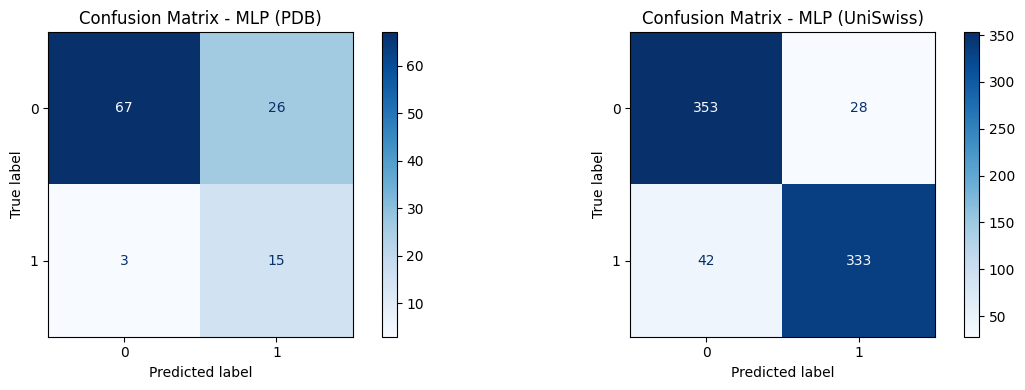

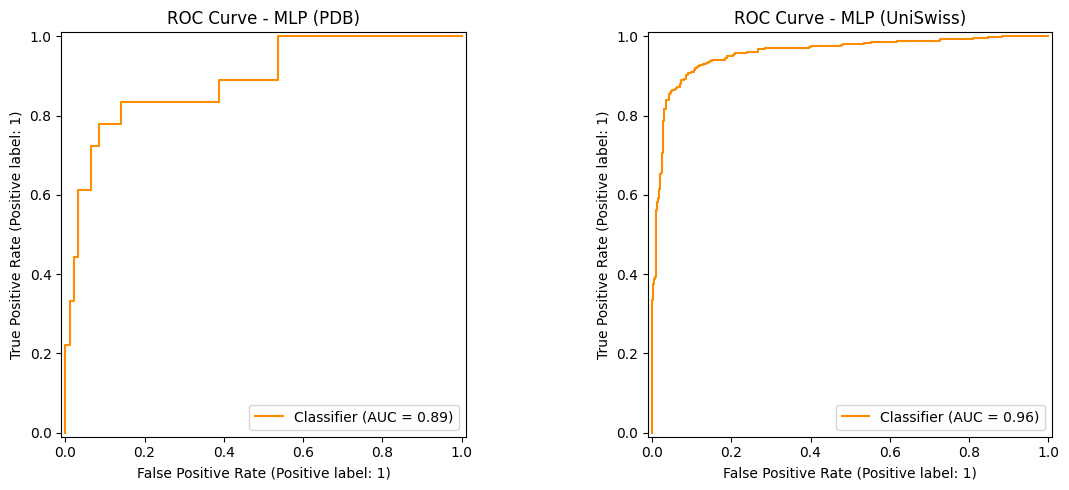

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v3(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.4, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=64,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=64,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)

# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

Epoch 10 | Train Loss: 0.5922 | Val F1: 0.7288
Epoch 20 | Train Loss: 0.4370 | Val F1: 0.7437
Epoch 30 | Train Loss: 0.3479 | Val F1: 0.7462
Early stopping at epoch 31
Epoch 10 | Train Loss: 0.2437 | Val F1: 0.8237
Epoch 20 | Train Loss: 0.1454 | Val F1: 0.8433
Epoch 30 | Train Loss: 0.1169 | Val F1: 0.8543
Early stopping at epoch 35

Evaluation for MLP on PDB dataset:
Accuracy:      0.790
Precision(M):  0.800
Recall(M):     0.790
F1 Macro:      0.789
F1 Weighted:   0.789
MCC:           0.591
Sensitivity:   0.790
Specificity:   0.882
ROC_AUC:       0.879

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.745     0.882     0.808        93
    Binding (1)      0.855     0.699     0.769        93

       accuracy                          0.790       186
      macro avg      0.800     0.790     0.789       186
   weighted avg      0.800     0.790     0.789       186


Evaluation for MLP on UniSwiss dataset:
Accuracy:      0.900
P

Model   Dataset  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0   MLP       PDB  0.790323         0.800359      0.790323  0.788556   
1   MLP  UniSwiss  0.899868         0.899867      0.899867  0.899867   

   F1_weighted  Specificity       MCC   ROC_AUC  \
0     0.788556     0.881720  0.590596  0.879292   
1     0.899868     0.900262  0.799733  0.958797   

                               Classification_Report  
0                   precision    recall  f1-score...  
1                   precision    recall  f1-score...

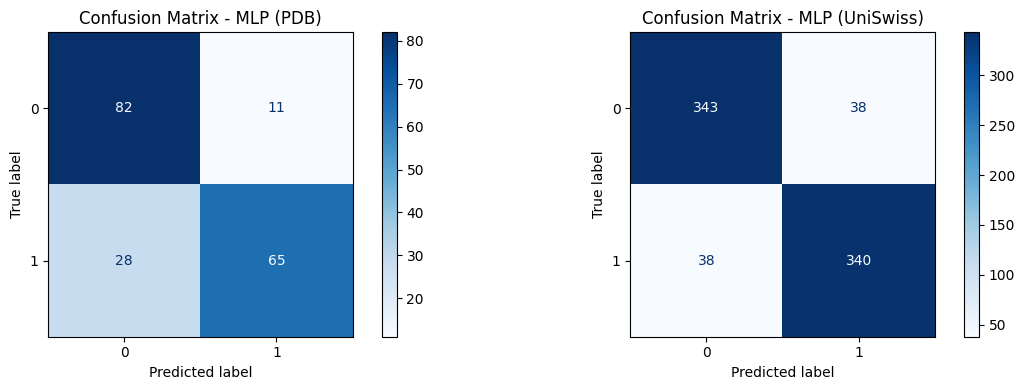

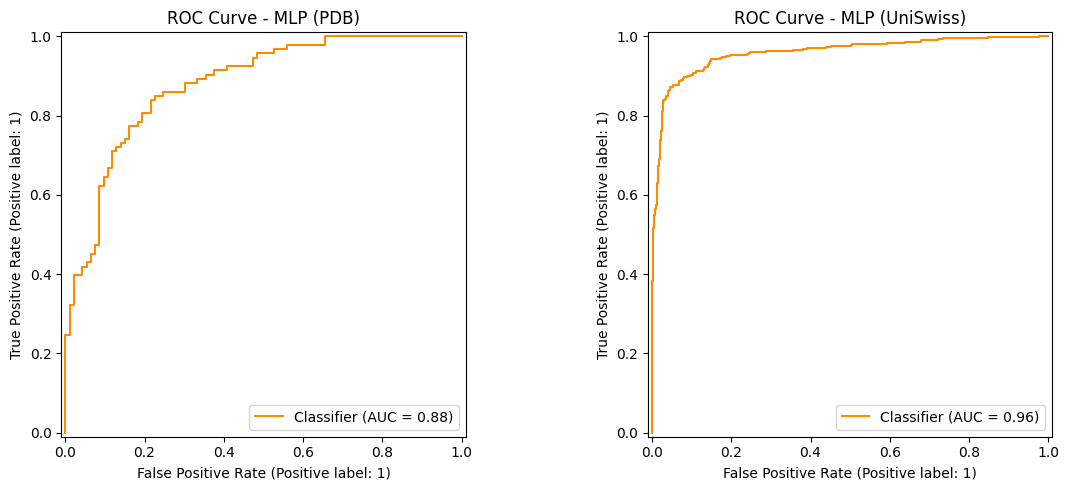

In [ ]:
# =============================
# 🔹 Contoh penggunaan
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pdb = ComplexMLP_v2(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)
model_uni = ComplexMLP_v2(input_dim=x_train_pdb.shape[1], hidden_dim=256, dropout=0.5, n_classes=2)

trained_pdb_model, history_pdb = train_model_v3(
    model=model_pdb,
    X_train=x_train_pdb,
    y_train=y_train_pdb,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15,
    device=device
)


trained_uni_model, history_uni = train_model_v3(
    model=model_uni,
    X_train=x_train_uni,
    y_train=y_train_uni,
    X_val=x_val_pdb,
    y_val=y_val_pdb,
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20, #beda dg pdb
    device=device
)
# Evaluate PDB BiLSTM model
pdb_mlp_metrics, y_pred_pdb_mlp, y_prob_pdb_mlp = evaluate_model(
    trained_pdb_model, x_pdb_test_emb, y_pdb_test, model_type='MLP', dataset_name="PDB"
)

# Evaluate UniSwiss BiLSTM model
uni_mlp_metrics, y_pred_uni_mlp, y_prob_uni_mlp = evaluate_model(
    trained_uni_model, x_uni_test_emb, y_uni_test, model_type='MLP', dataset_name="UniSwiss"
)

# Display results table
mlp_results_df = pd.DataFrame([pdb_mlp_metrics, uni_mlp_metrics])
display(mlp_results_df)

# Visualize metrics for BiLSTM
visualize_metrics(
    y_pdb_test, y_pred_pdb_mlp, y_prob_pdb_mlp,
    y_uni_test, y_pred_uni_mlp, y_prob_uni_mlp,
    model_name="MLP"
)

In [ ]:
torch.save(trained_pdb_model, "trained_pdb_model_full.pth")
torch.save(trained_uni_model, "trained_uni_model_full.pth")

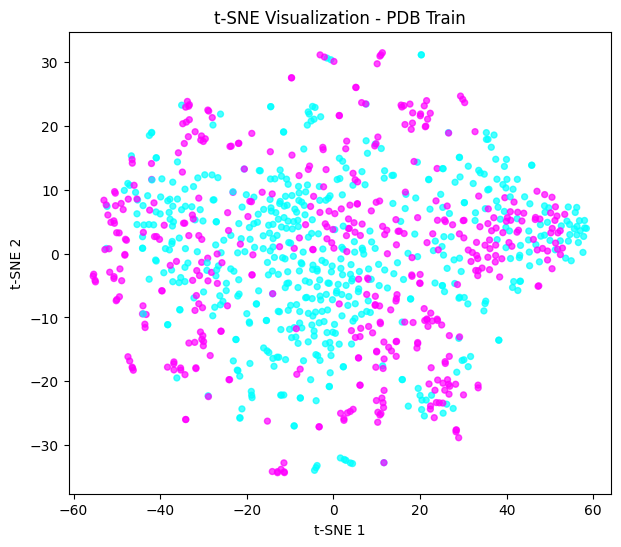

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/x_pdb_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/y_pdb_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - PDB Train")
plt.show()


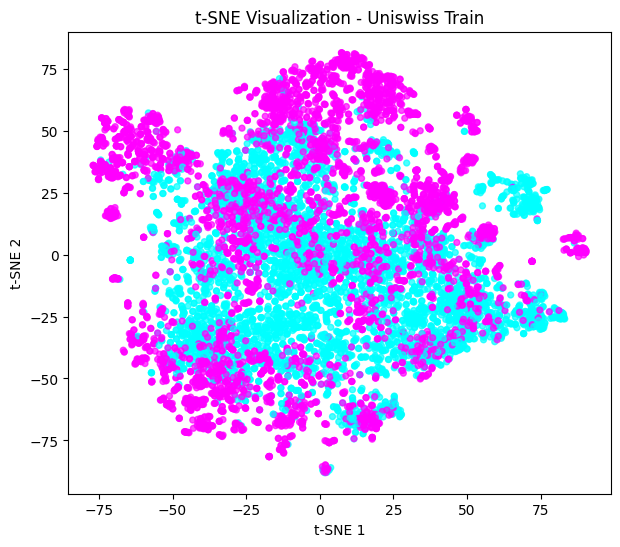

In [ ]:
# Load data
emb = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/x_uni_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/y_uni_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - Uniswiss Train")
plt.show()


# Kfold

In [ ]:
def run_kfold_training(base_model_class, X_all, y_all, input_dim, hidden_dim, dropout,
                       model_type_str, # <--- Tambahkan model_type_str di sini
                       k_folds=5, **kwargs):
    """
    Menjalankan K-Fold Cross-Validation dengan memanggil train_model_v3 dan
    evaluate_model yang sudah ada.
    """

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    all_fold_f1 = []

    print(f"=============================================")
    print(f"🚀 Memulai {k_folds}-Fold Cross-Validation untuk Model: {model_type_str}")
    print(f"=============================================")

    # Loop K-Fold
    for fold, (train_index, val_index) in enumerate(skf.split(X_all, y_all)):
        print(f"\n--- FOLD {fold+1}/{k_folds} ---")

        # 1. Pembagian Data
        X_train_fold, X_val_fold = X_all[train_index], X_all[val_index]
        y_train_fold, y_val_fold = y_all[train_index], y_all[val_index]

        # 2. Inisialisasi Model Baru untuk Fold Ini
        # Penting: Model baru harus diinisialisasi agar bobotnya acak di setiap fold
        model = base_model_class(input_dim=input_dim, hidden_dim=hidden_dim,
                                 dropout=dropout, n_classes=2)

        # 3. Panggil Fungsi Pelatihan yang Sudah Ada
        trained_model, history = train_model_v3(
            model=model,
            X_train=X_train_fold,
            y_train=y_train_fold,
            X_val=X_val_fold,
            y_val=y_val_fold,
            **kwargs
        )

        # 4. Panggil Fungsi Evaluasi yang Sudah Ada (Menggunakan Val Fold sebagai Test)
        metrics, _, _ = evaluate_model(
            trained_model,
            X_val_fold,
            y_val_fold,
            model_type=model_type_str, # <--- PERBAIKAN: Menggunakan string model yang benar
            dataset_name=f"Fold {fold+1} Validation"
        )

        fold_f1 = metrics['F1_macro']
        all_fold_f1.append(fold_f1)
        print(f"  > FOLD {fold+1} F1 Macro Final: {fold_f1:.4f}")

    # 5. Laporan Akhir K-Fold
    mean_f1 = np.mean(all_fold_f1)
    std_f1 = np.std(all_fold_f1)

    print(f"\n=============================================")
    print(f"✨ Hasil Akhir K-FOLD ({k_folds} Folds) - {model_type_str} ✨")
    print(f"---------------------------------------------")
    print(f"Rata-rata F1 Macro: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"=============================================")

    return mean_f1, std_f1


# modif dikit
def train_model_v4_new(model, X_train, y_train, X_val, y_val,
                   batch_size=32, epochs=100, lr=5e-4, weight_decay=5e-4,
                   patience=10, device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 1. Hitung Bobot Kelas (Inverse Frequency: Max Count / Class Count)
    class_counts = np.bincount(y_train)

    # Pencegahan error jika ada fold yang hanya memiliki 1 kelas (jarang terjadi di stratified)
    if 0 in class_counts:
        # Jika salah satu kelas tidak ada di train fold (sangat jarang jika stratified),
        # kita tidak dapat menghitung bobot, atau harus diberi bobot 0.
        # Untuk kasus ini, kita asumsikan 2 kelas ada.
        print("Peringatan: Salah satu kelas tidak ditemukan di Training Fold. Menggunakan bobot yang merata.")
        weights_np = [1.0] * len(class_counts)
    else:
        weights_np = max(class_counts) / class_counts

    weights_tensor = torch.tensor(weights_np, dtype=torch.float32).to(device)
    print(f"✅ Bobot Kelas (0, 1) dari data asli (Max/N): {weights_np}")

    # 2. Definisi Weighted CE Loss
    criterion = nn.CrossEntropyLoss(weight=weights_tensor) # <--- HANYA SATU DEFINISI INI

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

    for epoch in range(epochs):
        # Training Loop
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            # Periksa jika model memerlukan reshaping (untuk CNN/BiLSTM)
            # if isinstance(model, CNNModel) and xb.dim() == 2:
            #     xb = xb.unsqueeze(1) # Tambahkan channel dim (N, 1, 1280)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation Loop
        model.eval()
        val_preds, val_labels = [], []
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                # Periksa jika model memerlukan reshaping (untuk CNN/BiLSTM)
                # if isinstance(model, CNNModel) and xb.dim() == 2:
                #     xb = xb.unsqueeze(1) # Tambahkan channel dim (N, 1, 1280)

                out = model(xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
                val_labels.extend(yb.cpu().numpy())
                val_preds.extend(torch.argmax(out, dim=1).cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='macro')
        scheduler.step(val_f1)

        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['val_f1'].append(val_f1)

        # Early stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val F1: {val_f1:.4f}")

    # Load best weights
    model.load_state_dict(best_model_wts)
    return model, history

def run_kfold_training_new(base_model_class, X_all, y_all, input_dim, hidden_dim, dropout,
                       model_type_str, # <--- Tambahkan model_type_str di sini
                       k_folds=5, **kwargs):
    """
    Menjalankan K-Fold Cross-Validation dengan memanggil train_model_v3 dan
    evaluate_model yang sudah ada.
    """

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    all_fold_f1 = []

    print(f"=============================================")
    print(f"🚀 Memulai {k_folds}-Fold Cross-Validation untuk Model: {model_type_str}")
    print(f"=============================================")

    # Loop K-Fold
    for fold, (train_index, val_index) in enumerate(skf.split(X_all, y_all)):
        print(f"\n--- FOLD {fold+1}/{k_folds} ---")

        # 1. Pembagian Data
        X_train_fold, X_val_fold = X_all[train_index], X_all[val_index]
        y_train_fold, y_val_fold = y_all[train_index], y_all[val_index]

        # 2. Inisialisasi Model Baru untuk Fold Ini
        # Penting: Model baru harus diinisialisasi agar bobotnya acak di setiap fold
        model = base_model_class(input_dim=input_dim, hidden_dim=hidden_dim,
                                 dropout=dropout, n_classes=2)

        # 3. Panggil Fungsi Pelatihan yang Sudah Ada
        trained_model, history = train_model_v4_new(
            model=model,
            X_train=X_train_fold,
            y_train=y_train_fold,
            X_val=X_val_fold,
            y_val=y_val_fold,
            **kwargs
        )

        # 4. Panggil Fungsi Evaluasi yang Sudah Ada (Menggunakan Val Fold sebagai Test)
        metrics, _, _ = evaluate_model(
            trained_model,
            X_val_fold,
            y_val_fold,
            model_type=model_type_str, # <--- PERBAIKAN: Menggunakan string model yang benar
            dataset_name=f"Fold {fold+1} Validation"
        )

        fold_f1 = metrics['F1_macro']
        all_fold_f1.append(fold_f1)
        print(f"  > FOLD {fold+1} F1 Macro Final: {fold_f1:.4f}")

    # 5. Laporan Akhir K-Fold
    mean_f1 = np.mean(all_fold_f1)
    std_f1 = np.std(all_fold_f1)

    print(f"\n=============================================")
    print(f"✨ Hasil Akhir K-FOLD ({k_folds} Folds) - {model_type_str} ✨")
    print(f"---------------------------------------------")
    print(f"Rata-rata F1 Macro: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"=============================================")

    return mean_f1, std_f1

In [ ]:
x_pdb_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_pdb_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_pdb_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training(
    base_model_class=ComplexMLP_v2,
    X_all=x_pdb_train_emb,
    y_all=y_pdb_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=5,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15
)

🚀 Memulai 5-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/5 ---
Epoch 10 | Train Loss: 0.8166 | Val F1: 0.3103
Early stopping at epoch 16

Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.450
Precision(M):  0.225
Recall(M):     0.500
F1 Macro:      0.310
F1 Weighted:   0.279
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.636

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.450     1.000     0.621         9
    Binding (1)      0.000     0.000     0.000        11

       accuracy                          0.450        20
      macro avg      0.225     0.500     0.310        20
   weighted avg      0.202     0.450     0.279        20

  > FOLD 1 F1 Macro Final: 0.3103

--- FOLD 2/5 ---
Epoch 10 | Train Loss: 0.7149 | Val F1: 0.3103


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 20 | Train Loss: 0.6755 | Val F1: 0.4048
Epoch 30 | Train Loss: 0.6584 | Val F1: 0.3103
Early stopping at epoch 31

Evaluation for MLP on Fold 2 Validation dataset:
Accuracy:      0.450
Precision(M):  0.225
Recall(M):     0.500
F1 Macro:      0.310
F1 Weighted:   0.279
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.677

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.450     1.000     0.621         9
    Binding (1)      0.000     0.000     0.000        11

       accuracy                          0.450        20
      macro avg      0.225     0.500     0.310        20
   weighted avg      0.202     0.450     0.279        20

  > FOLD 2 F1 Macro Final: 0.3103

--- FOLD 3/5 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7463 | Val F1: 0.5489
Epoch 20 | Train Loss: 0.6771 | Val F1: 0.4373
Early stopping at epoch 21

Evaluation for MLP on Fold 3 Validation dataset:
Accuracy:      0.500
Precision(M):  0.495
Recall(M):     0.495
F1 Macro:      0.495
F1 Weighted:   0.500
MCC:           -0.010
Sensitivity:   0.495
Specificity:   0.444
ROC_AUC:       0.414

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.444     0.444     0.444         9
    Binding (1)      0.545     0.545     0.545        11

       accuracy                          0.500        20
      macro avg      0.495     0.495     0.495        20
   weighted avg      0.500     0.500     0.500        20

  > FOLD 3 F1 Macro Final: 0.4949

--- FOLD 4/5 ---
Epoch 10 | Train Loss: 0.7228 | Val F1: 0.3548
Early stopping at epoch 16

Evaluation for MLP on Fold 4 Validation dataset:
Accuracy:      0.550
Precision(M):  0.275
Recall(M):     0.500
F1 Macro:      0.355
F1 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7193 | Val F1: 0.3103
Epoch 20 | Train Loss: 0.7144 | Val F1: 0.3350
Epoch 30 | Train Loss: 0.6463 | Val F1: 0.3350
Early stopping at epoch 32

Evaluation for MLP on Fold 5 Validation dataset:
Accuracy:      0.350
Precision(M):  0.345
Recall(M):     0.369
F1 Macro:      0.335
F1 Weighted:   0.325
MCC:           -0.285
Sensitivity:   0.369
Specificity:   0.556
ROC_AUC:       0.323

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.357     0.556     0.435         9
    Binding (1)      0.333     0.182     0.235        11

       accuracy                          0.350        20
      macro avg      0.345     0.369     0.335        20
   weighted avg      0.344     0.350     0.325        20

  > FOLD 5 F1 Macro Final: 0.3350

✨ Hasil Akhir K-FOLD (5 Folds) - MLP ✨
---------------------------------------------
Rata-rata F1 Macro: 0.3611 ± 0.0690


In [ ]:
x_uni_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_uni_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_uni_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training(
    base_model_class=ComplexMLP_v2,
    X_all=x_uni_train_emb,
    y_all=y_uni_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=5,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20
)

🚀 Memulai 5-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/5 ---
Epoch 10 | Train Loss: 0.6996 | Val F1: 0.5489
Epoch 20 | Train Loss: 0.6541 | Val F1: 0.3350
Early stopping at epoch 30

Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.550
Precision(M):  0.551
Recall(M):     0.550
F1 Macro:      0.549
F1 Weighted:   0.549
MCC:           0.101
Sensitivity:   0.550
Specificity:   0.600
ROC_AUC:       0.440

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.545     0.600     0.571        10
    Binding (1)      0.556     0.500     0.526        10

       accuracy                          0.550        20
      macro avg      0.551     0.550     0.549        20
   weighted avg      0.551     0.550     0.549        20

  > FOLD 1 F1 Macro Final: 0.5489

--- FOLD 2/5 ---
Epoch 10 | Train Loss: 0.6403 | Val F1: 0.3333
Epoch 20 | Train Loss: 0.6339 | Val F1: 0.3333
Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Evaluation for MLP on Fold 2 Validation dataset:
Accuracy:      0.500
Precision(M):  0.250
Recall(M):     0.500
F1 Macro:      0.333
F1 Weighted:   0.333
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.000
ROC_AUC:       0.520

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000        10
    Binding (1)      0.500     1.000     0.667        10

       accuracy                          0.500        20
      macro avg      0.250     0.500     0.333        20
   weighted avg      0.250     0.500     0.333        20

  > FOLD 2 F1 Macro Final: 0.3333

--- FOLD 3/5 ---
Epoch 10 | Train Loss: 0.7386 | Val F1: 0.3333
Epoch 20 | Train Loss: 0.7261 | Val F1: 0.5833
Epoch 30 | Train Loss: 0.7038 | Val F1: 0.4373
Early stopping at epoch 40

Evaluation for MLP on Fold 3 Validation dataset:
Accuracy:      0.550
Precision(M):  0.567
Recall(M):     0.550
F1 Macro:      0.520
F1 Weighted:   0.520
MCC:      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
x_pdb_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_pdb_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_pdb_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training_new( #pke yg new
    base_model_class=ComplexMLP_v2,
    X_all=x_pdb_train_emb,
    y_all=y_pdb_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=5,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15
)

🚀 Memulai 5-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/5 ---
✅ Bobot Kelas (0, 1) dari data asli (Max/N): [1.16216216 1.        ]
Epoch 10 | Train Loss: 0.7019 | Val F1: 0.5396
Epoch 20 | Train Loss: 0.7388 | Val F1: 0.6419
Early stopping at epoch 26

Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.600
Precision(M):  0.600
Recall(M):     0.576
F1 Macro:      0.560
F1 Weighted:   0.574
MCC:           0.174
Sensitivity:   0.576
Specificity:   0.333
ROC_AUC:       0.596

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.600     0.333     0.429         9
    Binding (1)      0.600     0.818     0.692        11

       accuracy                          0.600        20
      macro avg      0.600     0.576     0.560        20
   weighted avg      0.600     0.600     0.574        20

  > FOLD 1 F1 Macro Final: 0.5604

--- FOLD 2/5 ---
✅ Bobot Kelas (0, 1) dari data asli (Max/N): [1.16216216 1.        ]
Epoch

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7513 | Val F1: 0.4357
Epoch 20 | Train Loss: 0.7056 | Val F1: 0.4048
Early stopping at epoch 21

Evaluation for MLP on Fold 5 Validation dataset:
Accuracy:      0.500
Precision(M):  0.500
Recall(M):     0.500
F1 Macro:      0.405
F1 Weighted:   0.405
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.900
ROC_AUC:       0.590

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.500     0.900     0.643        10
    Binding (1)      0.500     0.100     0.167        10

       accuracy                          0.500        20
      macro avg      0.500     0.500     0.405        20
   weighted avg      0.500     0.500     0.405        20

  > FOLD 5 F1 Macro Final: 0.4048

✨ Hasil Akhir K-FOLD (5 Folds) - MLP ✨
---------------------------------------------
Rata-rata F1 Macro: 0.4031 ± 0.0872


In [ ]:
x_uni_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_uni_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_uni_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training_new( #pke yg new
    base_model_class=ComplexMLP_v2,
    X_all=x_uni_train_emb,
    y_all=y_uni_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=5,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20
)

🚀 Memulai 5-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/5 ---
✅ Bobot Kelas (0, 1) dari data asli (Max/N): [1.         1.16216216]
Epoch 10 | Train Loss: 0.8129 | Val F1: 0.3548
Epoch 20 | Train Loss: 0.6628 | Val F1: 0.4667
Epoch 30 | Train Loss: 0.7243 | Val F1: 0.4667
Early stopping at epoch 32

Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.600
Precision(M):  0.789
Recall(M):     0.556
F1 Macro:      0.467
F1 Weighted:   0.493
MCC:           0.254
Sensitivity:   0.556
Specificity:   1.000
ROC_AUC:       0.576

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.579     1.000     0.733        11
    Binding (1)      1.000     0.111     0.200         9

       accuracy                          0.600        20
      macro avg      0.789     0.556     0.467        20
   weighted avg      0.768     0.600     0.493        20

  > FOLD 1 F1 Macro Final: 0.4667

--- FOLD 2/5 ---
✅ Bobot Kelas (0, 1) dari d

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7190 | Val F1: 0.3103
Epoch 20 | Train Loss: 0.7766 | Val F1: 0.3103
Early stopping at epoch 21

Evaluation for MLP on Fold 3 Validation dataset:
Accuracy:      0.450
Precision(M):  0.225
Recall(M):     0.500
F1 Macro:      0.310
F1 Weighted:   0.279
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.000
ROC_AUC:       0.424

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000        11
    Binding (1)      0.450     1.000     0.621         9

       accuracy                          0.450        20
      macro avg      0.225     0.500     0.310        20
   weighted avg      0.202     0.450     0.279        20

  > FOLD 3 F1 Macro Final: 0.3103

--- FOLD 4/5 ---
✅ Bobot Kelas (0, 1) dari data asli (Max/N): [1.         1.16216216]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7000 | Val F1: 0.3350
Epoch 20 | Train Loss: 0.6484 | Val F1: 0.3067
Early stopping at epoch 28

Evaluation for MLP on Fold 4 Validation dataset:
Accuracy:      0.350
Precision(M):  0.312
Recall(M):     0.379
F1 Macro:      0.307
F1 Weighted:   0.289
MCC:           -0.302
Sensitivity:   0.379
Specificity:   0.091
ROC_AUC:       0.545

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.250     0.091     0.133        11
    Binding (1)      0.375     0.667     0.480         9

       accuracy                          0.350        20
      macro avg      0.312     0.379     0.307        20
   weighted avg      0.306     0.350     0.289        20

  > FOLD 4 F1 Macro Final: 0.3067

--- FOLD 5/5 ---
✅ Bobot Kelas (0, 1) dari data asli (Max/N): [1.         1.22222222]
Epoch 10 | Train Loss: 0.6679 | Val F1: 0.3484
Epoch 20 | Train Loss: 0.6941 | Val F1: 0.1919
Early stopping at epoch 24

Evaluation for MLP o

In [ ]:
# try 20 fold
x_pdb_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_pdb_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_pdb_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training( #pke yg new
    base_model_class=ComplexMLP_v2,
    X_all=x_pdb_train_emb,
    y_all=y_pdb_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=20,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=15
)

🚀 Memulai 20-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/20 ---
Epoch 10 | Train Loss: 0.7200 | Val F1: 0.3750
Early stopping at epoch 16


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.600     1.000     0.750         3
    Binding (1)      0.000     0.000     0.000         2

       accuracy                          0.600         5
      macro avg      0.300     0.500     0.375         5
   weighted avg      0.360     0.600     0.450         5

  > FOLD 1 F1 Macro Final: 0.3750

--- FOLD 2/20 ---
Epoch 10 | Train Loss: 0.7496 | Val F1: 0.3750
Early stopping at epoch 16


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


Evaluation for MLP on Fold 2 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.600     1.000     0.750         3
    Binding (1)      0.000     0.000     0.000         2

       accuracy                          0.600         5
      macro avg      0.300     0.500     0.375         5
   weighted avg      0.360     0.600     0.450         5

  > FOLD 2 F1 Macro Final: 0.3750

--- FOLD 3/20 ---
Epoch 10 | Train Loss: 0.6679 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.6985 | Val F1: 0.5833
Epoch 30 | Train Loss: 0.6525 | Val F1: 0.5833
Early stopping at epoch 31

Evaluation for MLP on Fold 3 Validation dataset:
Accuracy:      0.600
Precision(M):  0.750
Recall(M):     0.667
F1 Macro:      0.583
F1 Weighted:   0.567
MCC:     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6747 | Val F1: 0.3750
Early stopping at epoch 16

Evaluation for MLP on Fold 5 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.600     1.000     0.750         3
    Binding (1)      0.000     0.000     0.000         2

       accuracy                          0.600         5
      macro avg      0.300     0.500     0.375         5
   weighted avg      0.360     0.600     0.450         5

  > FOLD 5 F1 Macro Final: 0.3750

--- FOLD 6/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7124 | Val F1: 0.1667
Epoch 20 | Train Loss: 0.7214 | Val F1: 0.1667
Early stopping at epoch 26

Evaluation for MLP on Fold 6 Validation dataset:
Accuracy:      0.200
Precision(M):  0.125
Recall(M):     0.250
F1 Macro:      0.167
F1 Weighted:   0.133
MCC:           -0.612
Sensitivity:   0.250
Specificity:   0.000
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         3
    Binding (1)      0.250     0.500     0.333         2

       accuracy                          0.200         5
      macro avg      0.125     0.250     0.167         5
   weighted avg      0.100     0.200     0.133         5

  > FOLD 6 F1 Macro Final: 0.1667

--- FOLD 7/20 ---
Epoch 10 | Train Loss: 0.7304 | Val F1: 0.3750
Epoch 20 | Train Loss: 0.7813 | Val F1: 0.7619
Epoch 30 | Train Loss: 0.6819 | Val F1: 0.7619
Early stopping at epoch 31

Evaluation for MLP on Fold 7 Validation d

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6910 | Val F1: 0.5833
Early stopping at epoch 20

Evaluation for MLP on Fold 9 Validation dataset:
Accuracy:      0.600
Precision(M):  0.750
Recall(M):     0.667
F1 Macro:      0.583
F1 Weighted:   0.567
MCC:           0.408
Sensitivity:   0.667
Specificity:   0.333
ROC_AUC:       0.833

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      1.000     0.333     0.500         3
    Binding (1)      0.500     1.000     0.667         2

       accuracy                          0.600         5
      macro avg      0.750     0.667     0.583         5
   weighted avg      0.800     0.600     0.567         5

  > FOLD 9 F1 Macro Final: 0.5833

--- FOLD 10/20 ---
Epoch 10 | Train Loss: 0.7483 | Val F1: 0.3750
Early stopping at epoch 16

Evaluation for MLP on Fold 10 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensit

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7038 | Val F1: 0.3750
Early stopping at epoch 16

Evaluation for MLP on Fold 11 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.000
ROC_AUC:       0.833

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         2
    Binding (1)      0.600     1.000     0.750         3

       accuracy                          0.600         5
      macro avg      0.300     0.500     0.375         5
   weighted avg      0.360     0.600     0.450         5

  > FOLD 11 F1 Macro Final: 0.3750

--- FOLD 12/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7795 | Val F1: 0.3750
Early stopping at epoch 16

Evaluation for MLP on Fold 12 Validation dataset:
Accuracy:      0.400
Precision(M):  0.250
Recall(M):     0.333
F1 Macro:      0.286
F1 Weighted:   0.343
MCC:           -0.408
Sensitivity:   0.333
Specificity:   0.000
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         2
    Binding (1)      0.500     0.667     0.571         3

       accuracy                          0.400         5
      macro avg      0.250     0.333     0.286         5
   weighted avg      0.300     0.400     0.343         5

  > FOLD 12 F1 Macro Final: 0.2857

--- FOLD 13/20 ---
Epoch 10 | Train Loss: 0.7355 | Val F1: 0.2857
Early stopping at epoch 16

Evaluation for MLP on Fold 13 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sen

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7275 | Val F1: 0.1667
Epoch 20 | Train Loss: 0.6420 | Val F1: 0.1667
Early stopping at epoch 22

Evaluation for MLP on Fold 14 Validation dataset:
Accuracy:      0.200
Precision(M):  0.167
Recall(M):     0.167
F1 Macro:      0.167
F1 Weighted:   0.200
MCC:           -0.667
Sensitivity:   0.167
Specificity:   0.000
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         2
    Binding (1)      0.333     0.333     0.333         3

       accuracy                          0.200         5
      macro avg      0.167     0.167     0.167         5
   weighted avg      0.200     0.200     0.200         5

  > FOLD 14 F1 Macro Final: 0.1667

--- FOLD 15/20 ---
Epoch 10 | Train Loss: 0.7552 | Val F1: 0.2857
Early stopping at epoch 16

Evaluation for MLP on Fold 15 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.28

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

  > FOLD 15 F1 Macro Final: 0.2857

--- FOLD 16/20 ---
Epoch 10 | Train Loss: 0.6616 | Val F1: 0.2857
Early stopping at epoch 16

Evaluation for MLP on Fold 16 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.400     1.000     0.571         2
    Binding (1)      0.000     0.000     0.000         3

       accuracy                          0.400         5
      macro avg      0.200     0.500     0.286         5
   weighted avg      0.160     0.400     0.229         5

  > FOLD 16 F1 Macro Final: 0.2857

--- FOLD 17/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7339 | Val F1: 0.7619
Epoch 20 | Train Loss: 0.6965 | Val F1: 0.7619
Epoch 30 | Train Loss: 0.6386 | Val F1: 1.0000
Early stopping at epoch 32

Evaluation for MLP on Fold 17 Validation dataset:
Accuracy:      1.000
Precision(M):  1.000
Recall(M):     1.000
F1 Macro:      1.000
F1 Weighted:   1.000
MCC:           1.000
Sensitivity:   1.000
Specificity:   1.000
ROC_AUC:       1.000

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      1.000     1.000     1.000         2
    Binding (1)      1.000     1.000     1.000         3

       accuracy                          1.000         5
      macro avg      1.000     1.000     1.000         5
   weighted avg      1.000     1.000     1.000         5

  > FOLD 17 F1 Macro Final: 1.0000

--- FOLD 18/20 ---
Epoch 10 | Train Loss: 0.7542 | Val F1: 0.3750
Early stopping at epoch 20

Evaluation for MLP on Fold 18 Validation dataset:
Accuracy:      0.800
Precision(M):  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

  > FOLD 19 F1 Macro Final: 0.2857

--- FOLD 20/20 ---
Epoch 10 | Train Loss: 0.7343 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.6856 | Val F1: 0.7619
Early stopping at epoch 28

Evaluation for MLP on Fold 20 Validation dataset:
Accuracy:      0.800
Precision(M):  0.875
Recall(M):     0.750
F1 Macro:      0.762
F1 Weighted:   0.781
MCC:           0.612
Sensitivity:   0.750
Specificity:   0.500
ROC_AUC:       1.000

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      1.000     0.500     0.667         2
    Binding (1)      0.750     1.000     0.857         3

       accuracy                          0.800         5
      macro avg      0.875     0.750     0.762         5
   weighted avg      0.850     0.800     0.781         5

  > FOLD 20 F1 Macro Final: 0.7619

✨ Hasil Akhir K-FOLD (20 Folds) - MLP ✨
---------------------------------------------
Rata-rata F1 Macro: 0.4420 ± 0.2195


In [ ]:
x_uni_train_emb = np.random.rand(100, 1280).astype(np.float32)
y_uni_train = np.random.randint(0, 2, 100).astype(np.int64)
input_dim_pdb = x_uni_train_emb.shape[1]

# Panggil K-Fold
trained_f1_mean, trained_f1_std = run_kfold_training( #pke yg new
    base_model_class=ComplexMLP_v2,
    X_all=x_uni_train_emb,
    y_all=y_uni_train,
    input_dim=input_dim_pdb,
    hidden_dim=256,
    dropout=0.5,
    model_type_str='MLP', # <--- PERBAIKAN: Menentukan tipe model secara eksplisit
    k_folds=20,
    # Meneruskan parameter untuk train_model_v3:
    batch_size=32,
    epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=20
)

🚀 Memulai 20-Fold Cross-Validation untuk Model: MLP

--- FOLD 1/20 ---
Epoch 10 | Train Loss: 0.7441 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.6654 | Val F1: 0.1667
Epoch 30 | Train Loss: 0.6942 | Val F1: 0.1667
Early stopping at epoch 31

Evaluation for MLP on Fold 1 Validation dataset:
Accuracy:      0.200
Precision(M):  0.125
Recall(M):     0.250
F1 Macro:      0.167
F1 Weighted:   0.133
MCC:           -0.612
Sensitivity:   0.250
Specificity:   0.000
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         3
    Binding (1)      0.250     0.500     0.333         2

       accuracy                          0.200         5
      macro avg      0.125     0.250     0.167         5
   weighted avg      0.100     0.200     0.133         5

  > FOLD 1 F1 Macro Final: 0.1667

--- FOLD 2/20 ---
Epoch 10 | Train Loss: 0.8041 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.6624 | Val F1: 0.583

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6518 | Val F1: 0.4000
Epoch 20 | Train Loss: 0.7167 | Val F1: 0.4000
Early stopping at epoch 23

Evaluation for MLP on Fold 4 Validation dataset:
Accuracy:      0.400
Precision(M):  0.417
Recall(M):     0.417
F1 Macro:      0.400
F1 Weighted:   0.400
MCC:           -0.167
Sensitivity:   0.417
Specificity:   0.333
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.500     0.333     0.400         3
    Binding (1)      0.333     0.500     0.400         2

       accuracy                          0.400         5
      macro avg      0.417     0.417     0.400         5
   weighted avg      0.433     0.400     0.400         5

  > FOLD 4 F1 Macro Final: 0.4000

--- FOLD 5/20 ---
Epoch 10 | Train Loss: 0.7309 | Val F1: 0.7619
Epoch 20 | Train Loss: 0.6941 | Val F1: 0.3750
Early stopping at epoch 30

Evaluation for MLP on Fold 5 Validation dataset:
Accuracy:      0.800
Precision(M):  0.8

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6975 | Val F1: 0.5833
Epoch 20 | Train Loss: 0.6971 | Val F1: 0.5833
Early stopping at epoch 25

Evaluation for MLP on Fold 7 Validation dataset:
Accuracy:      0.600
Precision(M):  0.583
Recall(M):     0.583
F1 Macro:      0.583
F1 Weighted:   0.600
MCC:           0.167
Sensitivity:   0.583
Specificity:   0.667
ROC_AUC:       0.333

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.667     0.667     0.667         3
    Binding (1)      0.500     0.500     0.500         2

       accuracy                          0.600         5
      macro avg      0.583     0.583     0.583         5
   weighted avg      0.600     0.600     0.600         5

  > FOLD 7 F1 Macro Final: 0.5833

--- FOLD 8/20 ---
Epoch 10 | Train Loss: 0.6986 | Val F1: 0.3750
Epoch 20 | Train Loss: 0.7333 | Val F1: 0.3750
Early stopping at epoch 21

Evaluation for MLP on Fold 8 Validation dataset:
Accuracy:      0.600
Precision(M):  0.30

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7049 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.7024 | Val F1: 0.5833
Epoch 30 | Train Loss: 0.6291 | Val F1: 0.2857
Early stopping at epoch 40

Evaluation for MLP on Fold 9 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.000
ROC_AUC:       0.667

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         3
    Binding (1)      0.400     1.000     0.571         2

       accuracy                          0.400         5
      macro avg      0.200     0.500     0.286         5
   weighted avg      0.160     0.400     0.229         5

  > FOLD 9 F1 Macro Final: 0.2857

--- FOLD 10/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7390 | Val F1: 0.3750
Epoch 20 | Train Loss: 0.6889 | Val F1: 0.2857
Early stopping at epoch 21

Evaluation for MLP on Fold 10 Validation dataset:
Accuracy:      0.400
Precision(M):  0.250
Recall(M):     0.333
F1 Macro:      0.286
F1 Weighted:   0.343
MCC:           -0.408
Sensitivity:   0.333
Specificity:   0.667
ROC_AUC:       0.167

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.500     0.667     0.571         3
    Binding (1)      0.000     0.000     0.000         2

       accuracy                          0.400         5
      macro avg      0.250     0.333     0.286         5
   weighted avg      0.300     0.400     0.343         5

  > FOLD 10 F1 Macro Final: 0.2857

--- FOLD 11/20 ---
Epoch 10 | Train Loss: 0.7645 | Val F1: 0.4000
Epoch 20 | Train Loss: 0.6600 | Val F1: 0.1667
Epoch 30 | Train Loss: 0.6686 | Val F1: 0.5833
Early stopping at epoch 31

Evaluation for MLP on Fold 11 Validati

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7513 | Val F1: 1.0000
Epoch 20 | Train Loss: 0.6921 | Val F1: 0.5833
Early stopping at epoch 30

Evaluation for MLP on Fold 13 Validation dataset:
Accuracy:      0.600
Precision(M):  0.750
Recall(M):     0.667
F1 Macro:      0.583
F1 Weighted:   0.567
MCC:           0.408
Sensitivity:   0.667
Specificity:   0.333
ROC_AUC:       1.000

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      1.000     0.333     0.500         3
    Binding (1)      0.500     1.000     0.667         2

       accuracy                          0.600         5
      macro avg      0.750     0.667     0.583         5
   weighted avg      0.800     0.600     0.567         5

  > FOLD 13 F1 Macro Final: 0.5833

--- FOLD 14/20 ---
Epoch 10 | Train Loss: 0.7450 | Val F1: 0.3750
Epoch 20 | Train Loss: 0.6404 | Val F1: 0.3750
Early stopping at epoch 21

Evaluation for MLP on Fold 14 Validation dataset:
Accuracy:      0.600
Precision(M):  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6847 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.7116 | Val F1: 0.2857
Epoch 30 | Train Loss: 0.6795 | Val F1: 0.2857
Early stopping at epoch 32

Evaluation for MLP on Fold 15 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.333

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.400     1.000     0.571         2
    Binding (1)      0.000     0.000     0.000         3

       accuracy                          0.400         5
      macro avg      0.200     0.500     0.286         5
   weighted avg      0.160     0.400     0.229         5

  > FOLD 15 F1 Macro Final: 0.2857

--- FOLD 16/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7017 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.7011 | Val F1: 0.2857
Early stopping at epoch 21

Evaluation for MLP on Fold 16 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.667

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.400     1.000     0.571         2
    Binding (1)      0.000     0.000     0.000         3

       accuracy                          0.400         5
      macro avg      0.200     0.500     0.286         5
   weighted avg      0.160     0.400     0.229         5

  > FOLD 16 F1 Macro Final: 0.2857

--- FOLD 17/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6580 | Val F1: 0.5833
Epoch 20 | Train Loss: 0.6622 | Val F1: 0.5833
Early stopping at epoch 25

Evaluation for MLP on Fold 17 Validation dataset:
Accuracy:      0.600
Precision(M):  0.583
Recall(M):     0.583
F1 Macro:      0.583
F1 Weighted:   0.600
MCC:           0.167
Sensitivity:   0.583
Specificity:   0.500
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.500     0.500     0.500         2
    Binding (1)      0.667     0.667     0.667         3

       accuracy                          0.600         5
      macro avg      0.583     0.583     0.583         5
   weighted avg      0.600     0.600     0.600         5

  > FOLD 17 F1 Macro Final: 0.5833

--- FOLD 18/20 ---
Epoch 10 | Train Loss: 0.7385 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.6998 | Val F1: 0.2857
Early stopping at epoch 21

Evaluation for MLP on Fold 18 Validation dataset:
Accuracy:      0.400
Precision(M):  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.7792 | Val F1: 0.2857
Epoch 20 | Train Loss: 0.7095 | Val F1: 0.2857
Early stopping at epoch 21

Evaluation for MLP on Fold 19 Validation dataset:
Accuracy:      0.400
Precision(M):  0.200
Recall(M):     0.500
F1 Macro:      0.286
F1 Weighted:   0.229
MCC:           0.000
Sensitivity:   0.500
Specificity:   1.000
ROC_AUC:       0.000

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.400     1.000     0.571         2
    Binding (1)      0.000     0.000     0.000         3

       accuracy                          0.400         5
      macro avg      0.200     0.500     0.286         5
   weighted avg      0.160     0.400     0.229         5

  > FOLD 19 F1 Macro Final: 0.2857

--- FOLD 20/20 ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 10 | Train Loss: 0.6857 | Val F1: 0.3750
Epoch 20 | Train Loss: 0.7269 | Val F1: 0.7619
Epoch 30 | Train Loss: 0.7702 | Val F1: 0.3750
Early stopping at epoch 40

Evaluation for MLP on Fold 20 Validation dataset:
Accuracy:      0.600
Precision(M):  0.300
Recall(M):     0.500
F1 Macro:      0.375
F1 Weighted:   0.450
MCC:           0.000
Sensitivity:   0.500
Specificity:   0.000
ROC_AUC:       0.500

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.000     0.000     0.000         2
    Binding (1)      0.600     1.000     0.750         3

       accuracy                          0.600         5
      macro avg      0.300     0.500     0.375         5
   weighted avg      0.360     0.600     0.450         5

  > FOLD 20 F1 Macro Final: 0.3750

✨ Hasil Akhir K-FOLD (20 Folds) - MLP ✨
---------------------------------------------
Rata-rata F1 Macro: 0.3924 ± 0.1459


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# kfold new
